In [1]:
import re
from typing import Dict, List, Text, Tuple
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc, f1_score, average_precision_score

import matplotlib.pyplot as plt
from matplotlib import colors

from tqdm import tqdm

import numpy as np
import tensorflow as tf

#from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, Input, BatchNormalization
#from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam

from typing import Callable, Tuple
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']


In [3]:
train_file = '../data/next_day_wildfire_spread_train*'
validation_file = '../data/next_day_wildfire_spread_eval*'
test_file = '../data/next_day_wildfire_spread_test*'

In [4]:
class WildfireDataset(Dataset):
    def __init__(self, tf_dataset):
        self.data = list(tf_dataset.as_numpy_iterator()) # Correctly iterate over the dataset


    def __len__(self):
        """ Return dataset size. """
        return len(self.data)

    def __getitem__(self, idx):
        """ Get a single sample. """
        inputs, label = self.data[idx]
        inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to PyTorch tensor
        label = torch.tensor(label, dtype=torch.float32)
        return inputs, label


In [5]:
def normalize_feature(feature, feature_name):
    """ Normalize features except 'PrevFireMask'. """
    if feature_name == 'PrevFireMask':
        return feature
    else:
        return (feature - tf.reduce_mean(feature)) / (tf.math.reduce_std(feature) + 1e-6)

def _parse_function(example_proto):
    """ Parses TFRecord into tensors and normalizes features. """
    feature_description = {feat: tf.io.FixedLenFeature([64, 64], tf.float32) for feat in INPUT_FEATURES + OUTPUT_FEATURES}

    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    inputs_list = [normalize_feature(tf.expand_dims(parsed_example[feat], -1), feat) for feat in INPUT_FEATURES]
    inputs = tf.concat(inputs_list, axis=-1)  # Convert to NumPy

    label = tf.expand_dims(parsed_example['FireMask'], -1)  # Shape: [64, 64, 1]
    label = tf.where(label < 0, 0.0, label)
    label = tf.where(label > 0, 1.0, label)

    return inputs, label

In [6]:
def get_tensorflow_dataset(file_pattern):
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Convert train, validation, and test datasets
train_numpy = get_tensorflow_dataset(train_file)
val_numpy = get_tensorflow_dataset(validation_file)
test_numpy = get_tensorflow_dataset(test_file)
print(train_numpy)
# Create PyTorch datasets
train_dataset = WildfireDataset(train_numpy)
val_dataset = WildfireDataset(val_numpy)
test_dataset = WildfireDataset(test_numpy)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 12), dtype=tf.float32, name=None), TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None))>


2025-04-24 16:14:00.437685: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-04-24 16:14:04.485911: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-24 16:14:04.922807: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Example batch
for inputs, labels in test_loader:
    print(inputs.shape, labels.shape)
    print(labels[31][32])  # Expected: [batch_size, 64, 64, num_features], [batch_size, 64, 64, 1]
    break

torch.Size([32, 64, 64, 12]) torch.Size([32, 64, 64, 1])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [23]:
import numpy as np
def convert_to_numpy(dataset): 
    X, y = [], []
    for inputs, label in dataset:
        inputs = inputs.numpy()  # Convert to NumPy
        label = label.numpy()

        # Flatten from (64, 64, num_features) to (64*64, num_features)
        inputs = inputs.reshape(-1, inputs.shape[-1])
        label = label.reshape(-1)  # Flatten labels from (64, 64, 1) to (64*64,)

        X.append(inputs)
        y.append(label)

    # Concatenate all samples
    X = np.vstack(X)
    y = np.hstack(y)

    return X, y
X_train, y_train = convert_to_numpy(train_numpy)
X_val, y_val = convert_to_numpy(val_numpy)
X_test, y_test = convert_to_numpy(test_numpy)

Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [25]:
val_accuracy = logistic_regression.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.9867


AUC-ROC: 0.6457
AUC-PR: 0.0784
Precision: 0.5299
Recall: 0.0058
F1 Score: 0.0114


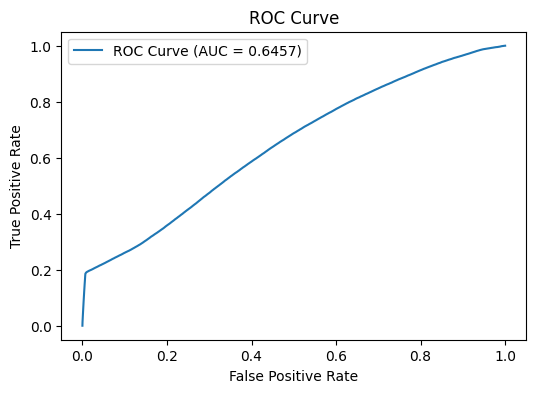

C:\Users\Shreyas Raman\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


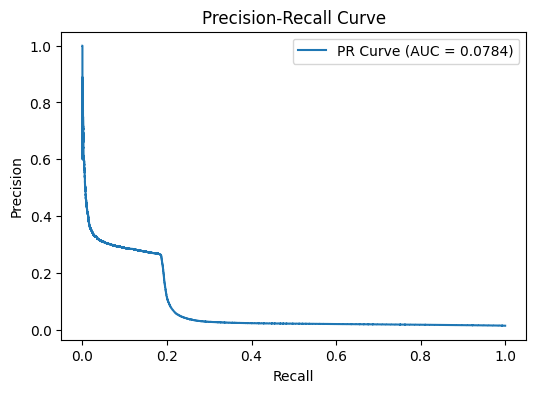

In [29]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
# Get predicted probabilities for the positive class
y_val_probs = logistic_regression.predict_proba(X_val)[:, 1]  # Get probability of class 1

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_val, y_val_probs)
print(f"AUC-ROC: {auc_roc:.4f}")

# Calculate AUC-PR
auc_pr = average_precision_score(y_val, y_val_probs)
print(f"AUC-PR: {auc_pr:.4f}")

y_val_pred = (y_val_probs >= 0.5).astype(int)

# Ensure y_val is binary integers
y_val_binary = np.array(y_val).astype(int)

# Calculate standard classification metrics
precision_val = precision_score(y_val_binary, y_val_pred)
recall_val = recall_score(y_val_binary, y_val_pred)
f1_val = f1_score(y_val_binary, y_val_pred)

print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_roc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_val_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR Curve (AUC = {auc_pr:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

AUC-ROC: 0.7087
AUC-PR: 0.1306
Precision: 0.4307
Recall: 0.0052
F1 Score: 0.0103


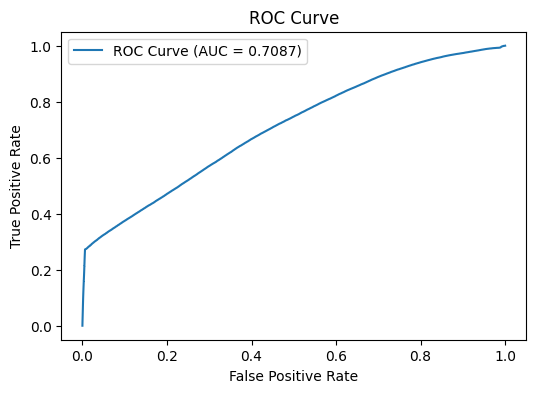

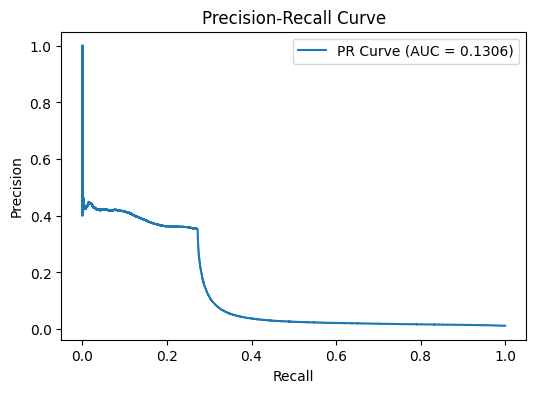

In [30]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
# Get predicted probabilities for the positive class
y_test_probs = logistic_regression.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_test_probs)
print(f"AUC-ROC: {auc_roc:.4f}")

# Calculate AUC-PR
auc_pr = average_precision_score(y_test, y_test_probs)
print(f"AUC-PR: {auc_pr:.4f}")

y_test_pred = (y_test_probs >= 0.5).astype(int)

# Ensure y_val is binary integers
y_test_binary = np.array(y_test).astype(int)

# Calculate standard classification metrics
precision_test = precision_score(y_test_binary, y_test_pred)
recall_test = recall_score(y_test_binary, y_test_pred)
f1_test = f1_score(y_test_binary, y_test_pred)

print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_roc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR Curve (AUC = {auc_pr:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

RNN

In [10]:
import random
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
 torch.cuda.manual_seed_all(SEED)
# define model
class RNNClassifier(nn.Module):
 def __init__(self, input_size, hidden_size, num_layers, num_classes):
  super(RNNClassifier, self).__init__()
  self.hidden_size = hidden_size
  self.num_layers = num_layers
  self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
  self.fc = nn.Linear(hidden_size, num_classes)
 def forward(self, x):
    x = x.view(x.size(0), 1, -1)
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    out, _ = self.rnn(x, h0)
    logit = self.fc(out[:, -1, :])
    return logit

In [9]:
def evaluate_model_metrics(model, data_loader, threshold=0.5, device=None):
    """
    Evaluate model using multiple metrics: AUC PR, Precision, Recall, and F1-score.

    Args:
        model: The trained model to evaluate
        data_loader: Data loader for evaluation
        threshold: Classification threshold (default 0.5)
        device: Device to use for evaluation

    Returns:
        metrics: Dictionary containing AUC PR, precision, recall, and F1-score
    """

    model.eval()

    all_targets = []
    all_predictions = []
    all_binary_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(outputs)

            # Binary predictions using threshold
            binary_preds = (probs > threshold).float()

            # Collect all predictions and targets
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(probs.cpu().numpy())
            all_binary_predictions.append(binary_preds.cpu().numpy())

    # Concatenate all batches
    all_targets = np.concatenate(all_targets).flatten()
    all_predictions = np.concatenate(all_predictions).flatten()
    all_binary_predictions = np.concatenate(all_binary_predictions).flatten()

    # Calculate metrics
    auc_pr = average_precision_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_binary_predictions, zero_division=0)
    recall = recall_score(all_targets, all_binary_predictions, zero_division=0)
    f1 = f1_score(all_targets, all_binary_predictions, zero_division=0)

    metrics = {
        'auc_pr': auc_pr,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics
     

In [10]:
def train_model(model, train_loader, val_loader, lr=0.001,pos_weight=3.0, num_epochs=10, device=None): #For Validation dataset
    """Train the wildfire segmentation model with comprehensive metrics."""
    # Set device
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([pos_weight], device=device)
    )

    # Optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr
    )

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_reg_loss': [],
        'val_reg_loss': [],
        'val_auc_pr': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1_score': []
    }

    # Best model tracking
    best_auc_pr = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_reg_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.view(targets.size(0), -1).float()
            #targets = targets.view(-1, 4096).float()
            # Calculate losses 
            bce_loss = criterion(outputs, targets)
            #reg_loss = model.get_regularization_loss()
            #total_loss = bce_loss + reg_loss
            total_loss = bce_loss

            total_loss.backward()
            optimizer.step()

            train_loss += bce_loss.item() * inputs.size(0)
            #train_reg_loss += reg_loss.item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        #avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        #history['train_reg_loss'].append(avg_train_reg_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        #val_reg_loss = 0.0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                targets = targets.view(targets.size(0), -1).float()
                #targets = targets.view(-1, 4096).float()
                # Calculate losses
                bce_loss = criterion(outputs, targets)
                #reg_loss = model.get_regularization_loss()

                val_loss += bce_loss.item() * inputs.size(0)
                #val_reg_loss += reg_loss.item() * inputs.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        #avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
        history['val_loss'].append(avg_val_loss)
        #history['val_reg_loss'].append(avg_val_reg_loss)

        # Calculate metrics
        metrics = evaluate_model_metrics(model, val_loader, device=device)

        # Store metrics in history
        for metric_name, metric_value in metrics.items():
            history[f'val_{metric_name}'].append(metric_value)

        # Save best model based on AUC PR
        auc_pr = metrics['auc_pr']
        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_model_state = model.state_dict().copy()
            print(f"New best model with AUC PR: {best_auc_pr:.4f}")

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f} "
              f"AUC PR: {metrics['auc_pr']:.4f} "
              f"Precision: {metrics['precision']:.4f} "
              f"Recall: {metrics['recall']:.4f} "
              f"F1: {metrics['f1_score']:.4f}")

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    final_metrics = evaluate_model_metrics(model, val_loader, device=device)
    print("\nFinal Model Performance:")
    print(f"AUC PR: {final_metrics['auc_pr']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1 Score: {final_metrics['f1_score']:.4f}")

    return model, history, final_metrics
     

In [11]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_auc_pr'], label='AUC PR')
    plt.plot(epochs, history['val_precision'], label='Precision')
    plt.plot(epochs, history['val_recall'], label='Recall')
    plt.plot(epochs, history['val_f1_score'], label='F1 Score')
    plt.title('Validation Metrics Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
lr_list = [0.01, 0.001,0.0001]
history_withlr = []
final_metrics_withlr = []
n_inputs=64*64*12
n_outputs=64*64*1
for lr in lr_list:
    print(f"learning rate: {lr}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = RNNClassifier(input_size=n_inputs, hidden_size=512, num_layers=2,num_classes=n_outputs).to(device)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_trained, history, final_metrics = train_model(model, train_loader, val_loader, lr=lr, pos_weight=3, num_epochs=100, device=device)
    #model_withlr.append(model_trained)
    history_withlr.append(history)
    final_metrics_withlr.append(final_metrics)

learning rate: 0.01


[Epoch 1/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.29it/s]


New best model with AUC PR: 0.0673
Epoch [1/100] Train Loss: 0.1724 Val Loss: 0.2011 AUC PR: 0.0673 Precision: 0.1120 Recall: 0.1695 F1: 0.1349


[Epoch 2/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.02it/s]


Epoch [2/100] Train Loss: 0.1411 Val Loss: 0.2124 AUC PR: 0.0670 Precision: 0.1197 Recall: 0.1526 F1: 0.1342


[Epoch 3/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.42it/s]


New best model with AUC PR: 0.0893
Epoch [3/100] Train Loss: 0.1450 Val Loss: 0.2103 AUC PR: 0.0893 Precision: 0.1614 Recall: 0.1658 F1: 0.1636


[Epoch 4/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.95it/s]


Epoch [4/100] Train Loss: 0.1444 Val Loss: 0.2305 AUC PR: 0.0781 Precision: 0.1483 Recall: 0.1612 F1: 0.1545


[Epoch 5/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.24it/s]


Epoch [5/100] Train Loss: 0.1461 Val Loss: 0.2343 AUC PR: 0.0646 Precision: 0.1105 Recall: 0.1796 F1: 0.1368


[Epoch 6/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 37.05it/s]


Epoch [6/100] Train Loss: 0.1469 Val Loss: 0.2396 AUC PR: 0.0660 Precision: 0.1221 Recall: 0.1709 F1: 0.1424


[Epoch 7/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.06it/s]


Epoch [7/100] Train Loss: 0.1452 Val Loss: 0.2242 AUC PR: 0.0814 Precision: 0.1423 Recall: 0.1818 F1: 0.1596


[Epoch 8/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.44it/s]


Epoch [8/100] Train Loss: 0.1447 Val Loss: 0.2507 AUC PR: 0.0745 Precision: 0.1417 Recall: 0.1681 F1: 0.1538


[Epoch 9/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.57it/s]


Epoch [9/100] Train Loss: 0.1432 Val Loss: 0.2598 AUC PR: 0.0690 Precision: 0.1315 Recall: 0.1721 F1: 0.1491


[Epoch 10/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.42it/s]


Epoch [10/100] Train Loss: 0.1421 Val Loss: 0.2518 AUC PR: 0.0719 Precision: 0.1164 Recall: 0.2003 F1: 0.1472


[Epoch 11/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.20it/s]


Epoch [11/100] Train Loss: 0.1410 Val Loss: 0.2747 AUC PR: 0.0614 Precision: 0.1156 Recall: 0.1683 F1: 0.1371


[Epoch 12/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.91it/s]


Epoch [12/100] Train Loss: 0.1447 Val Loss: 0.2566 AUC PR: 0.0692 Precision: 0.1197 Recall: 0.1788 F1: 0.1434


[Epoch 13/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.78it/s]


Epoch [13/100] Train Loss: 0.1384 Val Loss: 0.2608 AUC PR: 0.0818 Precision: 0.1442 Recall: 0.1863 F1: 0.1626


[Epoch 14/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.19it/s]


Epoch [14/100] Train Loss: 0.1383 Val Loss: 0.2684 AUC PR: 0.0677 Precision: 0.1222 Recall: 0.1555 F1: 0.1368


[Epoch 15/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.21it/s]


Epoch [15/100] Train Loss: 0.1340 Val Loss: 0.2699 AUC PR: 0.0758 Precision: 0.1427 Recall: 0.1513 F1: 0.1469


[Epoch 16/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.23it/s]


Epoch [16/100] Train Loss: 0.1360 Val Loss: 0.2723 AUC PR: 0.0755 Precision: 0.1402 Recall: 0.1750 F1: 0.1557


[Epoch 17/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 34.69it/s]


Epoch [17/100] Train Loss: 0.1363 Val Loss: 0.2935 AUC PR: 0.0605 Precision: 0.1097 Recall: 0.1710 F1: 0.1337


[Epoch 18/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.70it/s]


Epoch [18/100] Train Loss: 0.1352 Val Loss: 0.2797 AUC PR: 0.0663 Precision: 0.1210 Recall: 0.1578 F1: 0.1370


[Epoch 19/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.68it/s]


Epoch [19/100] Train Loss: 0.1348 Val Loss: 0.2825 AUC PR: 0.0728 Precision: 0.1352 Recall: 0.1523 F1: 0.1432


[Epoch 20/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.55it/s]


Epoch [20/100] Train Loss: 0.1337 Val Loss: 0.2830 AUC PR: 0.0702 Precision: 0.1285 Recall: 0.1754 F1: 0.1483


[Epoch 21/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.55it/s]


Epoch [21/100] Train Loss: 0.1354 Val Loss: 0.2915 AUC PR: 0.0656 Precision: 0.1242 Recall: 0.1591 F1: 0.1395


[Epoch 22/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.43it/s]


Epoch [22/100] Train Loss: 0.1330 Val Loss: 0.2885 AUC PR: 0.0670 Precision: 0.1238 Recall: 0.1566 F1: 0.1383


[Epoch 23/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.13it/s]


Epoch [23/100] Train Loss: 0.1321 Val Loss: 0.3037 AUC PR: 0.0672 Precision: 0.1273 Recall: 0.1484 F1: 0.1370


[Epoch 24/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.92it/s]


Epoch [24/100] Train Loss: 0.1310 Val Loss: 0.3170 AUC PR: 0.0617 Precision: 0.1166 Recall: 0.1677 F1: 0.1376


[Epoch 25/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 73.68it/s]


Epoch [25/100] Train Loss: 0.1297 Val Loss: 0.3015 AUC PR: 0.0736 Precision: 0.1335 Recall: 0.1760 F1: 0.1518


[Epoch 26/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.16it/s]


Epoch [26/100] Train Loss: 0.1284 Val Loss: 0.2883 AUC PR: 0.0776 Precision: 0.1401 Recall: 0.1824 F1: 0.1585


[Epoch 27/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.77it/s]


Epoch [27/100] Train Loss: 0.1284 Val Loss: 0.2983 AUC PR: 0.0782 Precision: 0.1532 Recall: 0.1645 F1: 0.1587


[Epoch 28/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.07it/s]


Epoch [28/100] Train Loss: 0.1277 Val Loss: 0.3048 AUC PR: 0.0711 Precision: 0.1280 Recall: 0.1662 F1: 0.1446


[Epoch 29/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.18it/s]


Epoch [29/100] Train Loss: 0.1266 Val Loss: 0.3033 AUC PR: 0.0702 Precision: 0.1286 Recall: 0.1763 F1: 0.1487


[Epoch 30/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.56it/s]


Epoch [30/100] Train Loss: 0.1273 Val Loss: 0.3234 AUC PR: 0.0708 Precision: 0.1406 Recall: 0.1653 F1: 0.1520


[Epoch 31/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.59it/s]


Epoch [31/100] Train Loss: 0.1255 Val Loss: 0.3195 AUC PR: 0.0725 Precision: 0.1342 Recall: 0.1632 F1: 0.1473


[Epoch 32/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.28it/s]


Epoch [32/100] Train Loss: 0.1259 Val Loss: 0.3207 AUC PR: 0.0711 Precision: 0.1421 Recall: 0.1602 F1: 0.1506


[Epoch 33/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.96it/s]


Epoch [33/100] Train Loss: 0.1244 Val Loss: 0.3308 AUC PR: 0.0673 Precision: 0.1270 Recall: 0.1543 F1: 0.1394


[Epoch 34/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.88it/s]


Epoch [34/100] Train Loss: 0.1253 Val Loss: 0.3370 AUC PR: 0.0683 Precision: 0.1329 Recall: 0.1461 F1: 0.1392


[Epoch 35/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.70it/s]


Epoch [35/100] Train Loss: 0.1240 Val Loss: 0.3362 AUC PR: 0.0721 Precision: 0.1334 Recall: 0.1841 F1: 0.1547


[Epoch 36/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.76it/s]


Epoch [36/100] Train Loss: 0.1286 Val Loss: 0.3355 AUC PR: 0.0682 Precision: 0.1285 Recall: 0.1508 F1: 0.1388


[Epoch 37/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 72.56it/s]


Epoch [37/100] Train Loss: 0.1233 Val Loss: 0.3400 AUC PR: 0.0735 Precision: 0.1405 Recall: 0.1713 F1: 0.1544


[Epoch 38/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.53it/s]


Epoch [38/100] Train Loss: 0.1221 Val Loss: 0.3451 AUC PR: 0.0742 Precision: 0.1474 Recall: 0.1722 F1: 0.1588


[Epoch 39/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.17it/s]


Epoch [39/100] Train Loss: 0.1225 Val Loss: 0.3447 AUC PR: 0.0738 Precision: 0.1363 Recall: 0.1735 F1: 0.1526


[Epoch 40/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.05it/s]


Epoch [40/100] Train Loss: 0.1235 Val Loss: 0.3429 AUC PR: 0.0688 Precision: 0.1296 Recall: 0.1612 F1: 0.1437


[Epoch 41/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.13it/s]


Epoch [41/100] Train Loss: 0.1201 Val Loss: 0.3459 AUC PR: 0.0691 Precision: 0.1317 Recall: 0.1541 F1: 0.1420


[Epoch 42/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 68.01it/s]


Epoch [42/100] Train Loss: 0.1233 Val Loss: 0.3487 AUC PR: 0.0691 Precision: 0.1301 Recall: 0.1691 F1: 0.1471


[Epoch 43/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.73it/s]


Epoch [43/100] Train Loss: 0.1217 Val Loss: 0.3512 AUC PR: 0.0774 Precision: 0.1488 Recall: 0.1779 F1: 0.1620


[Epoch 44/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.35it/s]


Epoch [44/100] Train Loss: 0.1205 Val Loss: 0.3603 AUC PR: 0.0689 Precision: 0.1328 Recall: 0.1642 F1: 0.1468


[Epoch 45/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.00it/s]


Epoch [45/100] Train Loss: 0.1207 Val Loss: 0.3516 AUC PR: 0.0696 Precision: 0.1335 Recall: 0.1655 F1: 0.1478


[Epoch 46/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.54it/s]


Epoch [46/100] Train Loss: 0.1211 Val Loss: 0.3590 AUC PR: 0.0740 Precision: 0.1417 Recall: 0.1739 F1: 0.1561


[Epoch 47/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.89it/s]


Epoch [47/100] Train Loss: 0.1178 Val Loss: 0.3595 AUC PR: 0.0743 Precision: 0.1418 Recall: 0.1750 F1: 0.1566


[Epoch 48/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 65.20it/s]


Epoch [48/100] Train Loss: 0.1183 Val Loss: 0.3552 AUC PR: 0.0783 Precision: 0.1477 Recall: 0.1764 F1: 0.1608


[Epoch 49/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.90it/s]


Epoch [49/100] Train Loss: 0.1194 Val Loss: 0.3517 AUC PR: 0.0755 Precision: 0.1380 Recall: 0.1936 F1: 0.1611


[Epoch 50/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.30it/s]


Epoch [50/100] Train Loss: 0.1203 Val Loss: 0.3564 AUC PR: 0.0776 Precision: 0.1430 Recall: 0.1900 F1: 0.1632


[Epoch 51/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.75it/s]


Epoch [51/100] Train Loss: 0.1198 Val Loss: 0.3553 AUC PR: 0.0713 Precision: 0.1284 Recall: 0.1702 F1: 0.1463


[Epoch 52/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.47it/s]


Epoch [52/100] Train Loss: 0.1187 Val Loss: 0.3549 AUC PR: 0.0726 Precision: 0.1334 Recall: 0.1754 F1: 0.1515


[Epoch 53/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 65.95it/s]


Epoch [53/100] Train Loss: 0.1173 Val Loss: 0.3671 AUC PR: 0.0708 Precision: 0.1342 Recall: 0.1729 F1: 0.1511


[Epoch 54/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 66.83it/s]


Epoch [54/100] Train Loss: 0.1157 Val Loss: 0.3647 AUC PR: 0.0746 Precision: 0.1387 Recall: 0.1769 F1: 0.1555


[Epoch 55/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.26it/s]


Epoch [55/100] Train Loss: 0.1167 Val Loss: 0.3800 AUC PR: 0.0707 Precision: 0.1329 Recall: 0.1723 F1: 0.1501


[Epoch 56/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.44it/s]


Epoch [56/100] Train Loss: 0.1168 Val Loss: 0.3725 AUC PR: 0.0728 Precision: 0.1369 Recall: 0.1769 F1: 0.1544


[Epoch 57/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.61it/s]


Epoch [57/100] Train Loss: 0.1167 Val Loss: 0.3728 AUC PR: 0.0689 Precision: 0.1280 Recall: 0.1679 F1: 0.1452


[Epoch 58/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.42it/s]


Epoch [58/100] Train Loss: 0.1176 Val Loss: 0.3706 AUC PR: 0.0707 Precision: 0.1366 Recall: 0.1544 F1: 0.1449


[Epoch 59/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.77it/s]


Epoch [59/100] Train Loss: 0.1186 Val Loss: 0.3813 AUC PR: 0.0702 Precision: 0.1349 Recall: 0.1631 F1: 0.1477


[Epoch 60/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.49it/s]


Epoch [60/100] Train Loss: 0.1157 Val Loss: 0.3794 AUC PR: 0.0742 Precision: 0.1417 Recall: 0.1659 F1: 0.1528


[Epoch 61/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.85it/s]


Epoch [61/100] Train Loss: 0.1141 Val Loss: 0.3784 AUC PR: 0.0746 Precision: 0.1363 Recall: 0.1879 F1: 0.1580


[Epoch 62/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.17it/s]


Epoch [62/100] Train Loss: 0.1160 Val Loss: 0.3886 AUC PR: 0.0670 Precision: 0.1255 Recall: 0.1589 F1: 0.1402


[Epoch 63/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.09it/s]


Epoch [63/100] Train Loss: 0.1156 Val Loss: 0.3851 AUC PR: 0.0717 Precision: 0.1367 Recall: 0.1743 F1: 0.1533


[Epoch 64/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 66.72it/s]


Epoch [64/100] Train Loss: 0.1164 Val Loss: 0.3828 AUC PR: 0.0771 Precision: 0.1469 Recall: 0.1657 F1: 0.1557


[Epoch 65/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.17it/s]


Epoch [65/100] Train Loss: 0.1151 Val Loss: 0.3921 AUC PR: 0.0720 Precision: 0.1421 Recall: 0.1514 F1: 0.1466


[Epoch 66/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 66.86it/s]


Epoch [66/100] Train Loss: 0.1149 Val Loss: 0.3816 AUC PR: 0.0754 Precision: 0.1394 Recall: 0.1741 F1: 0.1548


[Epoch 67/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.20it/s]


Epoch [67/100] Train Loss: 0.1160 Val Loss: 0.3863 AUC PR: 0.0765 Precision: 0.1432 Recall: 0.1798 F1: 0.1594


[Epoch 68/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.44it/s]


Epoch [68/100] Train Loss: 0.1157 Val Loss: 0.3902 AUC PR: 0.0779 Precision: 0.1453 Recall: 0.1705 F1: 0.1569


[Epoch 69/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.24it/s]


Epoch [69/100] Train Loss: 0.1128 Val Loss: 0.3845 AUC PR: 0.0772 Precision: 0.1452 Recall: 0.1610 F1: 0.1527


[Epoch 70/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.13it/s]


Epoch [70/100] Train Loss: 0.1124 Val Loss: 0.3935 AUC PR: 0.0732 Precision: 0.1362 Recall: 0.1794 F1: 0.1548


[Epoch 71/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.62it/s]


Epoch [71/100] Train Loss: 0.1153 Val Loss: 0.3927 AUC PR: 0.0754 Precision: 0.1441 Recall: 0.1677 F1: 0.1550


[Epoch 72/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.21it/s]


Epoch [72/100] Train Loss: 0.1128 Val Loss: 0.3971 AUC PR: 0.0748 Precision: 0.1393 Recall: 0.1680 F1: 0.1523


[Epoch 73/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.26it/s]


Epoch [73/100] Train Loss: 0.1132 Val Loss: 0.4078 AUC PR: 0.0743 Precision: 0.1445 Recall: 0.1761 F1: 0.1587


[Epoch 74/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.78it/s]


Epoch [74/100] Train Loss: 0.1137 Val Loss: 0.4054 AUC PR: 0.0754 Precision: 0.1494 Recall: 0.1632 F1: 0.1560


[Epoch 75/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.79it/s]


Epoch [75/100] Train Loss: 0.1134 Val Loss: 0.4071 AUC PR: 0.0786 Precision: 0.1430 Recall: 0.1867 F1: 0.1620


[Epoch 76/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.68it/s]


Epoch [76/100] Train Loss: 0.1130 Val Loss: 0.4051 AUC PR: 0.0799 Precision: 0.1511 Recall: 0.1860 F1: 0.1667


[Epoch 77/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.62it/s]


Epoch [77/100] Train Loss: 0.1115 Val Loss: 0.4105 AUC PR: 0.0772 Precision: 0.1458 Recall: 0.1685 F1: 0.1564


[Epoch 78/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 67.09it/s]


Epoch [78/100] Train Loss: 0.1103 Val Loss: 0.4230 AUC PR: 0.0732 Precision: 0.1391 Recall: 0.1691 F1: 0.1526


[Epoch 79/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.04it/s]


Epoch [79/100] Train Loss: 0.1097 Val Loss: 0.4188 AUC PR: 0.0739 Precision: 0.1351 Recall: 0.1798 F1: 0.1543


[Epoch 80/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.01it/s]


Epoch [80/100] Train Loss: 0.1107 Val Loss: 0.4156 AUC PR: 0.0729 Precision: 0.1389 Recall: 0.1628 F1: 0.1499


[Epoch 81/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.86it/s]


Epoch [81/100] Train Loss: 0.1089 Val Loss: 0.4230 AUC PR: 0.0751 Precision: 0.1412 Recall: 0.1627 F1: 0.1512


[Epoch 82/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.98it/s]


Epoch [82/100] Train Loss: 0.1102 Val Loss: 0.4210 AUC PR: 0.0842 Precision: 0.1654 Recall: 0.1696 F1: 0.1674


[Epoch 83/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.26it/s]


Epoch [83/100] Train Loss: 0.1101 Val Loss: 0.4350 AUC PR: 0.0729 Precision: 0.1393 Recall: 0.1790 F1: 0.1567


[Epoch 84/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.78it/s]


Epoch [84/100] Train Loss: 0.1081 Val Loss: 0.4289 AUC PR: 0.0773 Precision: 0.1472 Recall: 0.1813 F1: 0.1625


[Epoch 85/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.73it/s]


Epoch [85/100] Train Loss: 0.1078 Val Loss: 0.4363 AUC PR: 0.0756 Precision: 0.1410 Recall: 0.1741 F1: 0.1558


[Epoch 86/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.72it/s]


Epoch [86/100] Train Loss: 0.1085 Val Loss: 0.4300 AUC PR: 0.0813 Precision: 0.1537 Recall: 0.1718 F1: 0.1623


[Epoch 87/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.37it/s]


Epoch [87/100] Train Loss: 0.1078 Val Loss: 0.4315 AUC PR: 0.0777 Precision: 0.1494 Recall: 0.1705 F1: 0.1593


[Epoch 88/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.03it/s]


Epoch [88/100] Train Loss: 0.1067 Val Loss: 0.4339 AUC PR: 0.0798 Precision: 0.1498 Recall: 0.1823 F1: 0.1644


[Epoch 89/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.85it/s]


Epoch [89/100] Train Loss: 0.1063 Val Loss: 0.4424 AUC PR: 0.0775 Precision: 0.1444 Recall: 0.1912 F1: 0.1645


[Epoch 90/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.04it/s]


Epoch [90/100] Train Loss: 0.1106 Val Loss: 0.4403 AUC PR: 0.0779 Precision: 0.1486 Recall: 0.1758 F1: 0.1610


[Epoch 91/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.01it/s]


Epoch [91/100] Train Loss: 0.1071 Val Loss: 0.4564 AUC PR: 0.0756 Precision: 0.1465 Recall: 0.1647 F1: 0.1551


[Epoch 92/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.75it/s]


Epoch [92/100] Train Loss: 0.1077 Val Loss: 0.4492 AUC PR: 0.0721 Precision: 0.1410 Recall: 0.1663 F1: 0.1526


[Epoch 93/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.22it/s]


Epoch [93/100] Train Loss: 0.1065 Val Loss: 0.4537 AUC PR: 0.0698 Precision: 0.1292 Recall: 0.1408 F1: 0.1348


[Epoch 94/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.03it/s]


Epoch [94/100] Train Loss: 0.1045 Val Loss: 0.4465 AUC PR: 0.0761 Precision: 0.1399 Recall: 0.1777 F1: 0.1566


[Epoch 95/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.90it/s]


Epoch [95/100] Train Loss: 0.1064 Val Loss: 0.4579 AUC PR: 0.0748 Precision: 0.1410 Recall: 0.1636 F1: 0.1515


[Epoch 96/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.36it/s]


Epoch [96/100] Train Loss: 0.1059 Val Loss: 0.4653 AUC PR: 0.0767 Precision: 0.1492 Recall: 0.1653 F1: 0.1569


[Epoch 97/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.32it/s]


Epoch [97/100] Train Loss: 0.1048 Val Loss: 0.4519 AUC PR: 0.0762 Precision: 0.1465 Recall: 0.1645 F1: 0.1550


[Epoch 98/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.66it/s]


Epoch [98/100] Train Loss: 0.1056 Val Loss: 0.4586 AUC PR: 0.0771 Precision: 0.1497 Recall: 0.1431 F1: 0.1463


[Epoch 99/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.89it/s]


Epoch [99/100] Train Loss: 0.1049 Val Loss: 0.4527 AUC PR: 0.0790 Precision: 0.1500 Recall: 0.1804 F1: 0.1638


[Epoch 100/100] Validation: 100%|██████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.96it/s]


Epoch [100/100] Train Loss: 0.1036 Val Loss: 0.4522 AUC PR: 0.0774 Precision: 0.1473 Recall: 0.1612 F1: 0.1539

Final Model Performance:
AUC PR: 0.0774
Precision: 0.1473
Recall: 0.1612
F1 Score: 0.1539
learning rate: 0.001


[Epoch 1/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.96it/s]


New best model with AUC PR: 0.1682
Epoch [1/100] Train Loss: 0.1666 Val Loss: 0.1364 AUC PR: 0.1682 Precision: 0.3738 Recall: 0.1358 F1: 0.1992


[Epoch 2/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.23it/s]


Epoch [2/100] Train Loss: 0.0997 Val Loss: 0.1363 AUC PR: 0.1635 Precision: 0.3378 Recall: 0.1441 F1: 0.2020


[Epoch 3/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.43it/s]


Epoch [3/100] Train Loss: 0.0946 Val Loss: 0.1466 AUC PR: 0.1617 Precision: 0.3941 Recall: 0.1187 F1: 0.1825


[Epoch 4/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 38.96it/s]


Epoch [4/100] Train Loss: 0.0900 Val Loss: 0.1456 AUC PR: 0.1652 Precision: 0.3944 Recall: 0.1331 F1: 0.1990


[Epoch 5/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.86it/s]


Epoch [5/100] Train Loss: 0.0873 Val Loss: 0.1466 AUC PR: 0.1555 Precision: 0.3415 Recall: 0.1430 F1: 0.2016


[Epoch 6/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.29it/s]


Epoch [6/100] Train Loss: 0.0845 Val Loss: 0.1500 AUC PR: 0.1596 Precision: 0.3508 Recall: 0.1422 F1: 0.2024


[Epoch 7/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.95it/s]


New best model with AUC PR: 0.1732
Epoch [7/100] Train Loss: 0.0811 Val Loss: 0.1472 AUC PR: 0.1732 Precision: 0.3722 Recall: 0.1453 F1: 0.2090


[Epoch 8/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.49it/s]


Epoch [8/100] Train Loss: 0.0784 Val Loss: 0.1507 AUC PR: 0.1646 Precision: 0.3590 Recall: 0.1418 F1: 0.2033


[Epoch 9/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.12it/s]


Epoch [9/100] Train Loss: 0.0758 Val Loss: 0.1453 AUC PR: 0.1668 Precision: 0.3130 Recall: 0.1624 F1: 0.2138


[Epoch 10/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.41it/s]


Epoch [10/100] Train Loss: 0.0740 Val Loss: 0.1509 AUC PR: 0.1697 Precision: 0.3390 Recall: 0.1544 F1: 0.2122


[Epoch 11/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.62it/s]


New best model with AUC PR: 0.1744
Epoch [11/100] Train Loss: 0.0714 Val Loss: 0.1486 AUC PR: 0.1744 Precision: 0.3486 Recall: 0.1558 F1: 0.2154


[Epoch 12/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.02it/s]


Epoch [12/100] Train Loss: 0.0701 Val Loss: 0.1499 AUC PR: 0.1685 Precision: 0.3296 Recall: 0.1583 F1: 0.2139


[Epoch 13/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.61it/s]


Epoch [13/100] Train Loss: 0.0684 Val Loss: 0.1506 AUC PR: 0.1680 Precision: 0.3238 Recall: 0.1630 F1: 0.2169


[Epoch 14/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.32it/s]


Epoch [14/100] Train Loss: 0.0663 Val Loss: 0.1575 AUC PR: 0.1597 Precision: 0.3374 Recall: 0.1460 F1: 0.2038


[Epoch 15/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.64it/s]


Epoch [15/100] Train Loss: 0.0642 Val Loss: 0.1569 AUC PR: 0.1596 Precision: 0.3390 Recall: 0.1409 F1: 0.1990


[Epoch 16/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 38.85it/s]


Epoch [16/100] Train Loss: 0.0629 Val Loss: 0.1624 AUC PR: 0.1589 Precision: 0.3151 Recall: 0.1558 F1: 0.2085


[Epoch 17/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.48it/s]


Epoch [17/100] Train Loss: 0.0617 Val Loss: 0.1551 AUC PR: 0.1615 Precision: 0.3085 Recall: 0.1595 F1: 0.2103


[Epoch 18/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.96it/s]


Epoch [18/100] Train Loss: 0.0605 Val Loss: 0.1570 AUC PR: 0.1606 Precision: 0.3315 Recall: 0.1387 F1: 0.1955


[Epoch 19/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.86it/s]


Epoch [19/100] Train Loss: 0.0591 Val Loss: 0.1632 AUC PR: 0.1585 Precision: 0.3252 Recall: 0.1450 F1: 0.2005


[Epoch 20/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.69it/s]


Epoch [20/100] Train Loss: 0.0581 Val Loss: 0.1673 AUC PR: 0.1542 Precision: 0.3169 Recall: 0.1471 F1: 0.2009


[Epoch 21/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.97it/s]


Epoch [21/100] Train Loss: 0.0570 Val Loss: 0.1697 AUC PR: 0.1545 Precision: 0.3382 Recall: 0.1308 F1: 0.1886


[Epoch 22/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 66.78it/s]


Epoch [22/100] Train Loss: 0.0559 Val Loss: 0.1656 AUC PR: 0.1561 Precision: 0.3149 Recall: 0.1459 F1: 0.1994


[Epoch 23/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.05it/s]


Epoch [23/100] Train Loss: 0.0547 Val Loss: 0.1695 AUC PR: 0.1532 Precision: 0.3043 Recall: 0.1536 F1: 0.2041


[Epoch 24/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.78it/s]


Epoch [24/100] Train Loss: 0.0543 Val Loss: 0.1720 AUC PR: 0.1587 Precision: 0.3104 Recall: 0.1520 F1: 0.2041


[Epoch 25/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.49it/s]


Epoch [25/100] Train Loss: 0.0532 Val Loss: 0.1720 AUC PR: 0.1532 Precision: 0.3148 Recall: 0.1487 F1: 0.2020


[Epoch 26/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.82it/s]


Epoch [26/100] Train Loss: 0.0518 Val Loss: 0.1742 AUC PR: 0.1503 Precision: 0.3119 Recall: 0.1424 F1: 0.1955


[Epoch 27/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.56it/s]


Epoch [27/100] Train Loss: 0.0515 Val Loss: 0.1759 AUC PR: 0.1509 Precision: 0.3042 Recall: 0.1511 F1: 0.2019


[Epoch 28/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.25it/s]


Epoch [28/100] Train Loss: 0.0509 Val Loss: 0.1778 AUC PR: 0.1492 Precision: 0.3072 Recall: 0.1412 F1: 0.1934


[Epoch 29/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.31it/s]


Epoch [29/100] Train Loss: 0.0499 Val Loss: 0.1764 AUC PR: 0.1562 Precision: 0.3157 Recall: 0.1486 F1: 0.2021


[Epoch 30/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.19it/s]


Epoch [30/100] Train Loss: 0.0494 Val Loss: 0.1787 AUC PR: 0.1532 Precision: 0.3143 Recall: 0.1491 F1: 0.2022


[Epoch 31/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.54it/s]


Epoch [31/100] Train Loss: 0.0479 Val Loss: 0.1817 AUC PR: 0.1521 Precision: 0.3105 Recall: 0.1445 F1: 0.1972


[Epoch 32/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.55it/s]


Epoch [32/100] Train Loss: 0.0473 Val Loss: 0.1824 AUC PR: 0.1503 Precision: 0.3198 Recall: 0.1306 F1: 0.1855


[Epoch 33/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.60it/s]


Epoch [33/100] Train Loss: 0.0470 Val Loss: 0.1835 AUC PR: 0.1498 Precision: 0.3122 Recall: 0.1423 F1: 0.1955


[Epoch 34/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.85it/s]


Epoch [34/100] Train Loss: 0.0463 Val Loss: 0.1847 AUC PR: 0.1417 Precision: 0.2915 Recall: 0.1427 F1: 0.1916


[Epoch 35/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 69.31it/s]


Epoch [35/100] Train Loss: 0.0466 Val Loss: 0.1868 AUC PR: 0.1480 Precision: 0.3059 Recall: 0.1372 F1: 0.1895


[Epoch 36/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.12it/s]


Epoch [36/100] Train Loss: 0.0454 Val Loss: 0.1890 AUC PR: 0.1490 Precision: 0.3062 Recall: 0.1476 F1: 0.1992


[Epoch 37/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.00it/s]


Epoch [37/100] Train Loss: 0.0449 Val Loss: 0.1890 AUC PR: 0.1411 Precision: 0.2961 Recall: 0.1369 F1: 0.1873


[Epoch 38/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.89it/s]


Epoch [38/100] Train Loss: 0.0447 Val Loss: 0.1914 AUC PR: 0.1435 Precision: 0.2878 Recall: 0.1472 F1: 0.1948


[Epoch 39/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.24it/s]


Epoch [39/100] Train Loss: 0.0444 Val Loss: 0.1917 AUC PR: 0.1423 Precision: 0.2786 Recall: 0.1494 F1: 0.1945


[Epoch 40/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.44it/s]


Epoch [40/100] Train Loss: 0.0440 Val Loss: 0.1973 AUC PR: 0.1481 Precision: 0.2970 Recall: 0.1519 F1: 0.2010


[Epoch 41/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.85it/s]


Epoch [41/100] Train Loss: 0.0434 Val Loss: 0.1962 AUC PR: 0.1480 Precision: 0.3031 Recall: 0.1402 F1: 0.1917


[Epoch 42/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.40it/s]


Epoch [42/100] Train Loss: 0.0427 Val Loss: 0.1975 AUC PR: 0.1434 Precision: 0.2969 Recall: 0.1397 F1: 0.1900


[Epoch 43/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.44it/s]


Epoch [43/100] Train Loss: 0.0420 Val Loss: 0.1993 AUC PR: 0.1426 Precision: 0.2926 Recall: 0.1401 F1: 0.1895


[Epoch 44/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.90it/s]


Epoch [44/100] Train Loss: 0.0417 Val Loss: 0.2027 AUC PR: 0.1433 Precision: 0.2904 Recall: 0.1461 F1: 0.1944


[Epoch 45/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 66.16it/s]


Epoch [45/100] Train Loss: 0.0416 Val Loss: 0.2036 AUC PR: 0.1383 Precision: 0.2934 Recall: 0.1338 F1: 0.1838


[Epoch 46/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.44it/s]


Epoch [46/100] Train Loss: 0.0419 Val Loss: 0.2047 AUC PR: 0.1387 Precision: 0.2960 Recall: 0.1356 F1: 0.1860


[Epoch 47/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.51it/s]


Epoch [47/100] Train Loss: 0.0414 Val Loss: 0.2042 AUC PR: 0.1443 Precision: 0.2842 Recall: 0.1577 F1: 0.2028


[Epoch 48/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 69.44it/s]


Epoch [48/100] Train Loss: 0.0408 Val Loss: 0.2064 AUC PR: 0.1430 Precision: 0.2874 Recall: 0.1467 F1: 0.1943


[Epoch 49/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.06it/s]


Epoch [49/100] Train Loss: 0.0406 Val Loss: 0.2046 AUC PR: 0.1487 Precision: 0.3049 Recall: 0.1493 F1: 0.2004


[Epoch 50/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.72it/s]


Epoch [50/100] Train Loss: 0.0407 Val Loss: 0.1993 AUC PR: 0.1469 Precision: 0.2822 Recall: 0.1576 F1: 0.2023


[Epoch 51/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.35it/s]


Epoch [51/100] Train Loss: 0.0403 Val Loss: 0.2063 AUC PR: 0.1399 Precision: 0.2783 Recall: 0.1457 F1: 0.1913


[Epoch 52/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.93it/s]


Epoch [52/100] Train Loss: 0.0399 Val Loss: 0.2101 AUC PR: 0.1429 Precision: 0.2873 Recall: 0.1445 F1: 0.1922


[Epoch 53/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 38.39it/s]


Epoch [53/100] Train Loss: 0.0394 Val Loss: 0.2110 AUC PR: 0.1415 Precision: 0.2889 Recall: 0.1423 F1: 0.1907


[Epoch 54/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.85it/s]


Epoch [54/100] Train Loss: 0.0395 Val Loss: 0.2109 AUC PR: 0.1383 Precision: 0.2827 Recall: 0.1444 F1: 0.1912


[Epoch 55/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.66it/s]


Epoch [55/100] Train Loss: 0.0388 Val Loss: 0.2131 AUC PR: 0.1399 Precision: 0.2812 Recall: 0.1429 F1: 0.1895


[Epoch 56/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.07it/s]


Epoch [56/100] Train Loss: 0.0384 Val Loss: 0.2170 AUC PR: 0.1401 Precision: 0.2880 Recall: 0.1432 F1: 0.1913


[Epoch 57/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.30it/s]


Epoch [57/100] Train Loss: 0.0380 Val Loss: 0.2156 AUC PR: 0.1428 Precision: 0.2953 Recall: 0.1429 F1: 0.1926


[Epoch 58/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.80it/s]


Epoch [58/100] Train Loss: 0.0377 Val Loss: 0.2128 AUC PR: 0.1407 Precision: 0.2772 Recall: 0.1476 F1: 0.1927


[Epoch 59/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.66it/s]


Epoch [59/100] Train Loss: 0.0376 Val Loss: 0.2194 AUC PR: 0.1415 Precision: 0.2892 Recall: 0.1435 F1: 0.1918


[Epoch 60/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.04it/s]


Epoch [60/100] Train Loss: 0.0377 Val Loss: 0.2224 AUC PR: 0.1327 Precision: 0.2785 Recall: 0.1367 F1: 0.1833


[Epoch 61/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.44it/s]


Epoch [61/100] Train Loss: 0.0375 Val Loss: 0.2162 AUC PR: 0.1371 Precision: 0.2756 Recall: 0.1430 F1: 0.1883


[Epoch 62/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.28it/s]


Epoch [62/100] Train Loss: 0.0374 Val Loss: 0.2201 AUC PR: 0.1389 Precision: 0.2735 Recall: 0.1522 F1: 0.1956


[Epoch 63/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.47it/s]


Epoch [63/100] Train Loss: 0.0373 Val Loss: 0.2180 AUC PR: 0.1393 Precision: 0.2781 Recall: 0.1423 F1: 0.1883


[Epoch 64/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.61it/s]


Epoch [64/100] Train Loss: 0.0370 Val Loss: 0.2206 AUC PR: 0.1363 Precision: 0.2775 Recall: 0.1411 F1: 0.1871


[Epoch 65/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.44it/s]


Epoch [65/100] Train Loss: 0.0370 Val Loss: 0.2280 AUC PR: 0.1393 Precision: 0.2914 Recall: 0.1414 F1: 0.1904


[Epoch 66/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.22it/s]


Epoch [66/100] Train Loss: 0.0367 Val Loss: 0.2201 AUC PR: 0.1363 Precision: 0.2663 Recall: 0.1513 F1: 0.1929


[Epoch 67/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.72it/s]


Epoch [67/100] Train Loss: 0.0368 Val Loss: 0.2267 AUC PR: 0.1385 Precision: 0.2807 Recall: 0.1473 F1: 0.1932


[Epoch 68/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.53it/s]


Epoch [68/100] Train Loss: 0.0364 Val Loss: 0.2224 AUC PR: 0.1380 Precision: 0.2732 Recall: 0.1535 F1: 0.1966


[Epoch 69/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.48it/s]


Epoch [69/100] Train Loss: 0.0367 Val Loss: 0.2283 AUC PR: 0.1334 Precision: 0.2635 Recall: 0.1473 F1: 0.1890


[Epoch 70/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.69it/s]


Epoch [70/100] Train Loss: 0.0364 Val Loss: 0.2281 AUC PR: 0.1331 Precision: 0.2698 Recall: 0.1416 F1: 0.1857


[Epoch 71/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.90it/s]


Epoch [71/100] Train Loss: 0.0358 Val Loss: 0.2319 AUC PR: 0.1349 Precision: 0.2701 Recall: 0.1452 F1: 0.1889


[Epoch 72/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.60it/s]


Epoch [72/100] Train Loss: 0.0358 Val Loss: 0.2326 AUC PR: 0.1272 Precision: 0.2593 Recall: 0.1400 F1: 0.1819


[Epoch 73/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.51it/s]


Epoch [73/100] Train Loss: 0.0357 Val Loss: 0.2300 AUC PR: 0.1346 Precision: 0.2685 Recall: 0.1442 F1: 0.1877


[Epoch 74/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 70.39it/s]


Epoch [74/100] Train Loss: 0.0355 Val Loss: 0.2316 AUC PR: 0.1393 Precision: 0.2809 Recall: 0.1475 F1: 0.1934


[Epoch 75/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.43it/s]


Epoch [75/100] Train Loss: 0.0353 Val Loss: 0.2324 AUC PR: 0.1351 Precision: 0.2724 Recall: 0.1462 F1: 0.1902


[Epoch 76/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.76it/s]


Epoch [76/100] Train Loss: 0.0353 Val Loss: 0.2284 AUC PR: 0.1272 Precision: 0.2431 Recall: 0.1522 F1: 0.1872


[Epoch 77/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.53it/s]


Epoch [77/100] Train Loss: 0.0358 Val Loss: 0.2339 AUC PR: 0.1370 Precision: 0.2784 Recall: 0.1405 F1: 0.1867


[Epoch 78/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.97it/s]


Epoch [78/100] Train Loss: 0.0350 Val Loss: 0.2313 AUC PR: 0.1394 Precision: 0.2786 Recall: 0.1470 F1: 0.1924


[Epoch 79/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.76it/s]


Epoch [79/100] Train Loss: 0.0347 Val Loss: 0.2371 AUC PR: 0.1391 Precision: 0.2819 Recall: 0.1513 F1: 0.1969


[Epoch 80/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.93it/s]


Epoch [80/100] Train Loss: 0.0345 Val Loss: 0.2339 AUC PR: 0.1380 Precision: 0.2804 Recall: 0.1546 F1: 0.1993


[Epoch 81/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.86it/s]


Epoch [81/100] Train Loss: 0.0351 Val Loss: 0.2362 AUC PR: 0.1378 Precision: 0.2765 Recall: 0.1530 F1: 0.1970


[Epoch 82/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.04it/s]


Epoch [82/100] Train Loss: 0.0344 Val Loss: 0.2400 AUC PR: 0.1328 Precision: 0.2690 Recall: 0.1472 F1: 0.1903


[Epoch 83/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.34it/s]


Epoch [83/100] Train Loss: 0.0344 Val Loss: 0.2378 AUC PR: 0.1311 Precision: 0.2671 Recall: 0.1403 F1: 0.1840


[Epoch 84/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.04it/s]


Epoch [84/100] Train Loss: 0.0341 Val Loss: 0.2385 AUC PR: 0.1372 Precision: 0.2727 Recall: 0.1532 F1: 0.1962


[Epoch 85/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.95it/s]


Epoch [85/100] Train Loss: 0.0343 Val Loss: 0.2401 AUC PR: 0.1316 Precision: 0.2660 Recall: 0.1441 F1: 0.1869


[Epoch 86/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.92it/s]


Epoch [86/100] Train Loss: 0.0340 Val Loss: 0.2439 AUC PR: 0.1353 Precision: 0.2761 Recall: 0.1412 F1: 0.1869


[Epoch 87/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.26it/s]


Epoch [87/100] Train Loss: 0.0340 Val Loss: 0.2460 AUC PR: 0.1344 Precision: 0.2756 Recall: 0.1393 F1: 0.1851


[Epoch 88/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.92it/s]


Epoch [88/100] Train Loss: 0.0336 Val Loss: 0.2428 AUC PR: 0.1347 Precision: 0.2739 Recall: 0.1421 F1: 0.1871


[Epoch 89/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.82it/s]


Epoch [89/100] Train Loss: 0.0342 Val Loss: 0.2480 AUC PR: 0.1350 Precision: 0.2768 Recall: 0.1406 F1: 0.1865


[Epoch 90/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.26it/s]


Epoch [90/100] Train Loss: 0.0336 Val Loss: 0.2428 AUC PR: 0.1364 Precision: 0.2736 Recall: 0.1467 F1: 0.1910


[Epoch 91/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.04it/s]


Epoch [91/100] Train Loss: 0.0332 Val Loss: 0.2476 AUC PR: 0.1350 Precision: 0.2739 Recall: 0.1475 F1: 0.1917


[Epoch 92/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.50it/s]


Epoch [92/100] Train Loss: 0.0330 Val Loss: 0.2445 AUC PR: 0.1382 Precision: 0.2738 Recall: 0.1515 F1: 0.1950


[Epoch 93/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.50it/s]


Epoch [93/100] Train Loss: 0.0331 Val Loss: 0.2460 AUC PR: 0.1341 Precision: 0.2741 Recall: 0.1374 F1: 0.1830


[Epoch 94/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.49it/s]


Epoch [94/100] Train Loss: 0.0330 Val Loss: 0.2503 AUC PR: 0.1287 Precision: 0.2599 Recall: 0.1468 F1: 0.1876


[Epoch 95/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.11it/s]


Epoch [95/100] Train Loss: 0.0331 Val Loss: 0.2465 AUC PR: 0.1315 Precision: 0.2651 Recall: 0.1445 F1: 0.1871


[Epoch 96/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.39it/s]


Epoch [96/100] Train Loss: 0.0330 Val Loss: 0.2494 AUC PR: 0.1330 Precision: 0.2642 Recall: 0.1534 F1: 0.1941


[Epoch 97/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.17it/s]


Epoch [97/100] Train Loss: 0.0331 Val Loss: 0.2464 AUC PR: 0.1382 Precision: 0.2765 Recall: 0.1491 F1: 0.1938


[Epoch 98/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.27it/s]


Epoch [98/100] Train Loss: 0.0328 Val Loss: 0.2515 AUC PR: 0.1364 Precision: 0.2742 Recall: 0.1495 F1: 0.1935


[Epoch 99/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.86it/s]


Epoch [99/100] Train Loss: 0.0327 Val Loss: 0.2565 AUC PR: 0.1320 Precision: 0.2761 Recall: 0.1372 F1: 0.1833


[Epoch 100/100] Validation: 100%|██████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.30it/s]


Epoch [100/100] Train Loss: 0.0326 Val Loss: 0.2540 AUC PR: 0.1280 Precision: 0.2554 Recall: 0.1466 F1: 0.1863

Final Model Performance:
AUC PR: 0.1280
Precision: 0.2554
Recall: 0.1466
F1 Score: 0.1863
learning rate: 0.0001


[Epoch 1/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 72.22it/s]


New best model with AUC PR: 0.0308
Epoch [1/100] Train Loss: 0.3297 Val Loss: 0.2509 AUC PR: 0.0308 Precision: 0.0412 Recall: 0.1975 F1: 0.0682


[Epoch 2/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.40it/s]


New best model with AUC PR: 0.0672
Epoch [2/100] Train Loss: 0.1387 Val Loss: 0.1689 AUC PR: 0.0672 Precision: 0.1112 Recall: 0.1656 F1: 0.1331


[Epoch 3/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.49it/s]


New best model with AUC PR: 0.0820
Epoch [3/100] Train Loss: 0.1043 Val Loss: 0.1546 AUC PR: 0.0820 Precision: 0.1650 Recall: 0.1319 F1: 0.1466


[Epoch 4/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.83it/s]


New best model with AUC PR: 0.0940
Epoch [4/100] Train Loss: 0.0938 Val Loss: 0.1468 AUC PR: 0.0940 Precision: 0.1798 Recall: 0.1362 F1: 0.1550


[Epoch 5/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.44it/s]


New best model with AUC PR: 0.1240
Epoch [5/100] Train Loss: 0.0892 Val Loss: 0.1412 AUC PR: 0.1240 Precision: 0.2404 Recall: 0.1346 F1: 0.1726


[Epoch 6/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.55it/s]


New best model with AUC PR: 0.1356
Epoch [6/100] Train Loss: 0.0872 Val Loss: 0.1397 AUC PR: 0.1356 Precision: 0.2619 Recall: 0.1410 F1: 0.1833


[Epoch 7/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 38.49it/s]


New best model with AUC PR: 0.1589
Epoch [7/100] Train Loss: 0.0853 Val Loss: 0.1341 AUC PR: 0.1589 Precision: 0.3278 Recall: 0.1461 F1: 0.2021


[Epoch 8/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.09it/s]


New best model with AUC PR: 0.1740
Epoch [8/100] Train Loss: 0.0833 Val Loss: 0.1314 AUC PR: 0.1740 Precision: 0.3453 Recall: 0.1532 F1: 0.2123


[Epoch 9/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.06it/s]


Epoch [9/100] Train Loss: 0.0811 Val Loss: 0.1354 AUC PR: 0.1681 Precision: 0.3566 Recall: 0.1397 F1: 0.2007


[Epoch 10/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.81it/s]


Epoch [10/100] Train Loss: 0.0792 Val Loss: 0.1365 AUC PR: 0.1667 Precision: 0.3659 Recall: 0.1357 F1: 0.1980


[Epoch 11/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.77it/s]


New best model with AUC PR: 0.1862
Epoch [11/100] Train Loss: 0.0777 Val Loss: 0.1319 AUC PR: 0.1862 Precision: 0.3777 Recall: 0.1558 F1: 0.2206


[Epoch 12/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.11it/s]


Epoch [12/100] Train Loss: 0.0761 Val Loss: 0.1329 AUC PR: 0.1851 Precision: 0.3760 Recall: 0.1516 F1: 0.2161


[Epoch 13/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 70.33it/s]


Epoch [13/100] Train Loss: 0.0747 Val Loss: 0.1326 AUC PR: 0.1851 Precision: 0.3667 Recall: 0.1510 F1: 0.2139


[Epoch 14/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.38it/s]


Epoch [14/100] Train Loss: 0.0728 Val Loss: 0.1397 AUC PR: 0.1751 Precision: 0.3725 Recall: 0.1440 F1: 0.2077


[Epoch 15/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.39it/s]


Epoch [15/100] Train Loss: 0.0718 Val Loss: 0.1374 AUC PR: 0.1802 Precision: 0.3551 Recall: 0.1539 F1: 0.2148


[Epoch 16/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.23it/s]


Epoch [16/100] Train Loss: 0.0705 Val Loss: 0.1384 AUC PR: 0.1809 Precision: 0.3633 Recall: 0.1564 F1: 0.2187


[Epoch 17/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.46it/s]


Epoch [17/100] Train Loss: 0.0688 Val Loss: 0.1373 AUC PR: 0.1812 Precision: 0.3564 Recall: 0.1545 F1: 0.2156


[Epoch 18/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.51it/s]


Epoch [18/100] Train Loss: 0.0678 Val Loss: 0.1367 AUC PR: 0.1827 Precision: 0.3701 Recall: 0.1471 F1: 0.2105


[Epoch 19/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.72it/s]


Epoch [19/100] Train Loss: 0.0666 Val Loss: 0.1396 AUC PR: 0.1848 Precision: 0.3750 Recall: 0.1530 F1: 0.2173


[Epoch 20/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.00it/s]


Epoch [20/100] Train Loss: 0.0655 Val Loss: 0.1385 AUC PR: 0.1855 Precision: 0.3568 Recall: 0.1623 F1: 0.2231


[Epoch 21/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.67it/s]


New best model with AUC PR: 0.1863
Epoch [21/100] Train Loss: 0.0642 Val Loss: 0.1407 AUC PR: 0.1863 Precision: 0.3674 Recall: 0.1568 F1: 0.2198


[Epoch 22/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.16it/s]


Epoch [22/100] Train Loss: 0.0633 Val Loss: 0.1428 AUC PR: 0.1813 Precision: 0.3620 Recall: 0.1532 F1: 0.2153


[Epoch 23/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.18it/s]


Epoch [23/100] Train Loss: 0.0625 Val Loss: 0.1462 AUC PR: 0.1754 Precision: 0.3377 Recall: 0.1629 F1: 0.2198


[Epoch 24/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.57it/s]


Epoch [24/100] Train Loss: 0.0618 Val Loss: 0.1438 AUC PR: 0.1784 Precision: 0.3569 Recall: 0.1532 F1: 0.2144


[Epoch 25/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.45it/s]


Epoch [25/100] Train Loss: 0.0611 Val Loss: 0.1465 AUC PR: 0.1769 Precision: 0.3508 Recall: 0.1530 F1: 0.2131


[Epoch 26/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.58it/s]


Epoch [26/100] Train Loss: 0.0602 Val Loss: 0.1455 AUC PR: 0.1761 Precision: 0.3496 Recall: 0.1541 F1: 0.2139


[Epoch 27/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 66.95it/s]


Epoch [27/100] Train Loss: 0.0596 Val Loss: 0.1450 AUC PR: 0.1767 Precision: 0.3437 Recall: 0.1554 F1: 0.2140


[Epoch 28/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.98it/s]


Epoch [28/100] Train Loss: 0.0588 Val Loss: 0.1472 AUC PR: 0.1775 Precision: 0.3497 Recall: 0.1572 F1: 0.2169


[Epoch 29/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.87it/s]


Epoch [29/100] Train Loss: 0.0585 Val Loss: 0.1439 AUC PR: 0.1858 Precision: 0.3539 Recall: 0.1674 F1: 0.2273


[Epoch 30/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.73it/s]


Epoch [30/100] Train Loss: 0.0577 Val Loss: 0.1435 AUC PR: 0.1855 Precision: 0.3467 Recall: 0.1681 F1: 0.2265


[Epoch 31/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.48it/s]


Epoch [31/100] Train Loss: 0.0567 Val Loss: 0.1438 AUC PR: 0.1860 Precision: 0.3643 Recall: 0.1593 F1: 0.2216


[Epoch 32/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.57it/s]


Epoch [32/100] Train Loss: 0.0558 Val Loss: 0.1470 AUC PR: 0.1808 Precision: 0.3500 Recall: 0.1559 F1: 0.2157


[Epoch 33/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.15it/s]


Epoch [33/100] Train Loss: 0.0551 Val Loss: 0.1494 AUC PR: 0.1842 Precision: 0.3627 Recall: 0.1567 F1: 0.2189


[Epoch 34/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.34it/s]


Epoch [34/100] Train Loss: 0.0545 Val Loss: 0.1506 AUC PR: 0.1775 Precision: 0.3322 Recall: 0.1611 F1: 0.2169


[Epoch 35/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.81it/s]


Epoch [35/100] Train Loss: 0.0541 Val Loss: 0.1513 AUC PR: 0.1757 Precision: 0.3349 Recall: 0.1621 F1: 0.2184


[Epoch 36/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.30it/s]


Epoch [36/100] Train Loss: 0.0533 Val Loss: 0.1552 AUC PR: 0.1699 Precision: 0.3346 Recall: 0.1555 F1: 0.2123


[Epoch 37/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.30it/s]


Epoch [37/100] Train Loss: 0.0524 Val Loss: 0.1552 AUC PR: 0.1744 Precision: 0.3511 Recall: 0.1548 F1: 0.2149


[Epoch 38/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.30it/s]


Epoch [38/100] Train Loss: 0.0520 Val Loss: 0.1514 AUC PR: 0.1774 Precision: 0.3511 Recall: 0.1551 F1: 0.2152


[Epoch 39/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 87.12it/s]


Epoch [39/100] Train Loss: 0.0514 Val Loss: 0.1543 AUC PR: 0.1789 Precision: 0.3588 Recall: 0.1549 F1: 0.2164


[Epoch 40/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.82it/s]


Epoch [40/100] Train Loss: 0.0507 Val Loss: 0.1568 AUC PR: 0.1774 Precision: 0.3629 Recall: 0.1504 F1: 0.2127


[Epoch 41/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.66it/s]


Epoch [41/100] Train Loss: 0.0501 Val Loss: 0.1586 AUC PR: 0.1747 Precision: 0.3528 Recall: 0.1550 F1: 0.2154


[Epoch 42/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 65.08it/s]


Epoch [42/100] Train Loss: 0.0497 Val Loss: 0.1571 AUC PR: 0.1748 Precision: 0.3466 Recall: 0.1554 F1: 0.2146


[Epoch 43/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.60it/s]


Epoch [43/100] Train Loss: 0.0490 Val Loss: 0.1554 AUC PR: 0.1793 Precision: 0.3516 Recall: 0.1556 F1: 0.2157


[Epoch 44/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.82it/s]


Epoch [44/100] Train Loss: 0.0485 Val Loss: 0.1584 AUC PR: 0.1750 Precision: 0.3381 Recall: 0.1633 F1: 0.2202


[Epoch 45/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.08it/s]


Epoch [45/100] Train Loss: 0.0481 Val Loss: 0.1569 AUC PR: 0.1795 Precision: 0.3591 Recall: 0.1522 F1: 0.2138


[Epoch 46/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.39it/s]


Epoch [46/100] Train Loss: 0.0477 Val Loss: 0.1652 AUC PR: 0.1750 Precision: 0.3541 Recall: 0.1526 F1: 0.2133


[Epoch 47/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.21it/s]


Epoch [47/100] Train Loss: 0.0471 Val Loss: 0.1621 AUC PR: 0.1733 Precision: 0.3493 Recall: 0.1507 F1: 0.2106


[Epoch 48/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.58it/s]


Epoch [48/100] Train Loss: 0.0466 Val Loss: 0.1635 AUC PR: 0.1727 Precision: 0.3460 Recall: 0.1514 F1: 0.2106


[Epoch 49/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.66it/s]


Epoch [49/100] Train Loss: 0.0460 Val Loss: 0.1612 AUC PR: 0.1751 Precision: 0.3372 Recall: 0.1571 F1: 0.2144


[Epoch 50/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.79it/s]


Epoch [50/100] Train Loss: 0.0453 Val Loss: 0.1657 AUC PR: 0.1711 Precision: 0.3510 Recall: 0.1493 F1: 0.2095


[Epoch 51/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.91it/s]


Epoch [51/100] Train Loss: 0.0449 Val Loss: 0.1645 AUC PR: 0.1717 Precision: 0.3486 Recall: 0.1543 F1: 0.2139


[Epoch 52/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.86it/s]


Epoch [52/100] Train Loss: 0.0445 Val Loss: 0.1653 AUC PR: 0.1772 Precision: 0.3462 Recall: 0.1607 F1: 0.2195


[Epoch 53/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 38.69it/s]


Epoch [53/100] Train Loss: 0.0439 Val Loss: 0.1656 AUC PR: 0.1747 Precision: 0.3467 Recall: 0.1564 F1: 0.2155


[Epoch 54/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.07it/s]


Epoch [54/100] Train Loss: 0.0435 Val Loss: 0.1673 AUC PR: 0.1756 Precision: 0.3553 Recall: 0.1569 F1: 0.2177


[Epoch 55/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.51it/s]


Epoch [55/100] Train Loss: 0.0429 Val Loss: 0.1674 AUC PR: 0.1736 Precision: 0.3420 Recall: 0.1554 F1: 0.2137


[Epoch 56/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.00it/s]


Epoch [56/100] Train Loss: 0.0425 Val Loss: 0.1692 AUC PR: 0.1736 Precision: 0.3401 Recall: 0.1586 F1: 0.2163


[Epoch 57/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 65.96it/s]


Epoch [57/100] Train Loss: 0.0421 Val Loss: 0.1695 AUC PR: 0.1720 Precision: 0.3429 Recall: 0.1538 F1: 0.2123


[Epoch 58/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 66.29it/s]


Epoch [58/100] Train Loss: 0.0417 Val Loss: 0.1739 AUC PR: 0.1710 Precision: 0.3476 Recall: 0.1538 F1: 0.2133


[Epoch 59/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.07it/s]


Epoch [59/100] Train Loss: 0.0412 Val Loss: 0.1716 AUC PR: 0.1692 Precision: 0.3405 Recall: 0.1528 F1: 0.2110


[Epoch 60/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.60it/s]


Epoch [60/100] Train Loss: 0.0407 Val Loss: 0.1705 AUC PR: 0.1717 Precision: 0.3368 Recall: 0.1578 F1: 0.2149


[Epoch 61/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.57it/s]


Epoch [61/100] Train Loss: 0.0404 Val Loss: 0.1725 AUC PR: 0.1738 Precision: 0.3409 Recall: 0.1627 F1: 0.2203


[Epoch 62/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.95it/s]


Epoch [62/100] Train Loss: 0.0399 Val Loss: 0.1743 AUC PR: 0.1694 Precision: 0.3471 Recall: 0.1455 F1: 0.2051


[Epoch 63/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.22it/s]


Epoch [63/100] Train Loss: 0.0394 Val Loss: 0.1744 AUC PR: 0.1705 Precision: 0.3507 Recall: 0.1487 F1: 0.2088


[Epoch 64/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.05it/s]


Epoch [64/100] Train Loss: 0.0389 Val Loss: 0.1763 AUC PR: 0.1737 Precision: 0.3454 Recall: 0.1552 F1: 0.2142


[Epoch 65/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.29it/s]


Epoch [65/100] Train Loss: 0.0387 Val Loss: 0.1764 AUC PR: 0.1703 Precision: 0.3435 Recall: 0.1539 F1: 0.2126


[Epoch 66/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.46it/s]


Epoch [66/100] Train Loss: 0.0383 Val Loss: 0.1759 AUC PR: 0.1724 Precision: 0.3431 Recall: 0.1624 F1: 0.2205


[Epoch 67/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.73it/s]


Epoch [67/100] Train Loss: 0.0378 Val Loss: 0.1773 AUC PR: 0.1675 Precision: 0.3236 Recall: 0.1642 F1: 0.2179


[Epoch 68/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.10it/s]


Epoch [68/100] Train Loss: 0.0376 Val Loss: 0.1795 AUC PR: 0.1697 Precision: 0.3415 Recall: 0.1579 F1: 0.2159


[Epoch 69/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.42it/s]


Epoch [69/100] Train Loss: 0.0373 Val Loss: 0.1812 AUC PR: 0.1688 Precision: 0.3456 Recall: 0.1544 F1: 0.2134


[Epoch 70/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.72it/s]


Epoch [70/100] Train Loss: 0.0368 Val Loss: 0.1819 AUC PR: 0.1693 Precision: 0.3493 Recall: 0.1503 F1: 0.2101


[Epoch 71/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.68it/s]


Epoch [71/100] Train Loss: 0.0363 Val Loss: 0.1820 AUC PR: 0.1706 Precision: 0.3453 Recall: 0.1536 F1: 0.2127


[Epoch 72/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.23it/s]


Epoch [72/100] Train Loss: 0.0358 Val Loss: 0.1804 AUC PR: 0.1703 Precision: 0.3430 Recall: 0.1552 F1: 0.2137


[Epoch 73/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.22it/s]


Epoch [73/100] Train Loss: 0.0355 Val Loss: 0.1826 AUC PR: 0.1698 Precision: 0.3505 Recall: 0.1508 F1: 0.2109


[Epoch 74/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.53it/s]


Epoch [74/100] Train Loss: 0.0351 Val Loss: 0.1839 AUC PR: 0.1706 Precision: 0.3537 Recall: 0.1523 F1: 0.2129


[Epoch 75/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.57it/s]


Epoch [75/100] Train Loss: 0.0349 Val Loss: 0.1871 AUC PR: 0.1703 Precision: 0.3509 Recall: 0.1537 F1: 0.2137


[Epoch 76/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.56it/s]


Epoch [76/100] Train Loss: 0.0344 Val Loss: 0.1860 AUC PR: 0.1670 Precision: 0.3453 Recall: 0.1520 F1: 0.2111


[Epoch 77/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.07it/s]


Epoch [77/100] Train Loss: 0.0342 Val Loss: 0.1838 AUC PR: 0.1689 Precision: 0.3357 Recall: 0.1574 F1: 0.2143


[Epoch 78/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.46it/s]


Epoch [78/100] Train Loss: 0.0341 Val Loss: 0.1836 AUC PR: 0.1700 Precision: 0.3406 Recall: 0.1603 F1: 0.2180


[Epoch 79/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.23it/s]


Epoch [79/100] Train Loss: 0.0336 Val Loss: 0.1896 AUC PR: 0.1642 Precision: 0.3329 Recall: 0.1557 F1: 0.2122


[Epoch 80/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.98it/s]


Epoch [80/100] Train Loss: 0.0330 Val Loss: 0.1893 AUC PR: 0.1653 Precision: 0.3380 Recall: 0.1513 F1: 0.2090


[Epoch 81/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.23it/s]


Epoch [81/100] Train Loss: 0.0327 Val Loss: 0.1912 AUC PR: 0.1638 Precision: 0.3409 Recall: 0.1478 F1: 0.2062


[Epoch 82/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.51it/s]


Epoch [82/100] Train Loss: 0.0326 Val Loss: 0.1899 AUC PR: 0.1669 Precision: 0.3364 Recall: 0.1517 F1: 0.2091


[Epoch 83/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.03it/s]


Epoch [83/100] Train Loss: 0.0324 Val Loss: 0.1908 AUC PR: 0.1667 Precision: 0.3331 Recall: 0.1539 F1: 0.2105


[Epoch 84/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.78it/s]


Epoch [84/100] Train Loss: 0.0321 Val Loss: 0.1899 AUC PR: 0.1653 Precision: 0.3283 Recall: 0.1539 F1: 0.2095


[Epoch 85/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.41it/s]


Epoch [85/100] Train Loss: 0.0316 Val Loss: 0.1908 AUC PR: 0.1663 Precision: 0.3331 Recall: 0.1550 F1: 0.2116


[Epoch 86/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.41it/s]


Epoch [86/100] Train Loss: 0.0313 Val Loss: 0.1955 AUC PR: 0.1659 Precision: 0.3496 Recall: 0.1479 F1: 0.2079


[Epoch 87/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.33it/s]


Epoch [87/100] Train Loss: 0.0310 Val Loss: 0.1959 AUC PR: 0.1643 Precision: 0.3410 Recall: 0.1502 F1: 0.2085


[Epoch 88/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.85it/s]


Epoch [88/100] Train Loss: 0.0306 Val Loss: 0.1959 AUC PR: 0.1680 Precision: 0.3497 Recall: 0.1509 F1: 0.2108


[Epoch 89/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.07it/s]


Epoch [89/100] Train Loss: 0.0304 Val Loss: 0.1956 AUC PR: 0.1687 Precision: 0.3389 Recall: 0.1565 F1: 0.2141


[Epoch 90/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.12it/s]


Epoch [90/100] Train Loss: 0.0300 Val Loss: 0.1950 AUC PR: 0.1679 Precision: 0.3404 Recall: 0.1546 F1: 0.2126


[Epoch 91/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.43it/s]


Epoch [91/100] Train Loss: 0.0297 Val Loss: 0.1986 AUC PR: 0.1656 Precision: 0.3379 Recall: 0.1523 F1: 0.2099


[Epoch 92/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.37it/s]


Epoch [92/100] Train Loss: 0.0296 Val Loss: 0.1966 AUC PR: 0.1670 Precision: 0.3356 Recall: 0.1565 F1: 0.2135


[Epoch 93/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.65it/s]


Epoch [93/100] Train Loss: 0.0293 Val Loss: 0.1965 AUC PR: 0.1643 Precision: 0.3342 Recall: 0.1489 F1: 0.2060


[Epoch 94/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.44it/s]


Epoch [94/100] Train Loss: 0.0289 Val Loss: 0.2000 AUC PR: 0.1648 Precision: 0.3409 Recall: 0.1506 F1: 0.2089


[Epoch 95/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.83it/s]


Epoch [95/100] Train Loss: 0.0286 Val Loss: 0.2017 AUC PR: 0.1681 Precision: 0.3513 Recall: 0.1466 F1: 0.2069


[Epoch 96/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.09it/s]


Epoch [96/100] Train Loss: 0.0283 Val Loss: 0.2037 AUC PR: 0.1630 Precision: 0.3445 Recall: 0.1453 F1: 0.2044


[Epoch 97/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 64.42it/s]


Epoch [97/100] Train Loss: 0.0281 Val Loss: 0.2036 AUC PR: 0.1643 Precision: 0.3386 Recall: 0.1499 F1: 0.2078


[Epoch 98/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.54it/s]


Epoch [98/100] Train Loss: 0.0280 Val Loss: 0.2049 AUC PR: 0.1653 Precision: 0.3465 Recall: 0.1493 F1: 0.2087


[Epoch 99/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.10it/s]


Epoch [99/100] Train Loss: 0.0275 Val Loss: 0.2033 AUC PR: 0.1620 Precision: 0.3341 Recall: 0.1453 F1: 0.2025


[Epoch 100/100] Validation: 100%|██████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.36it/s]


Epoch [100/100] Train Loss: 0.0272 Val Loss: 0.2081 AUC PR: 0.1603 Precision: 0.3379 Recall: 0.1445 F1: 0.2024

Final Model Performance:
AUC PR: 0.1603
Precision: 0.3379
Recall: 0.1445
F1 Score: 0.2024


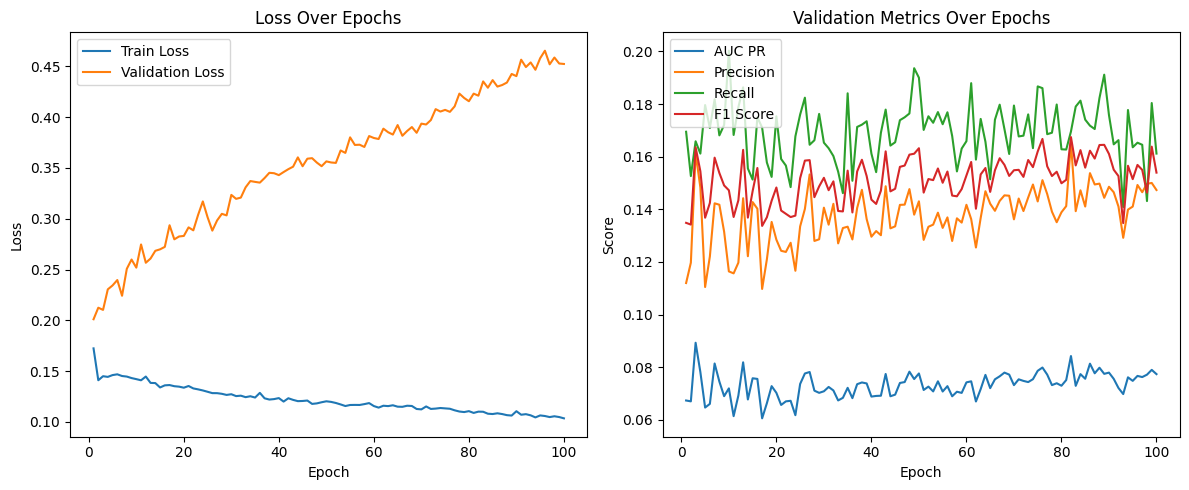

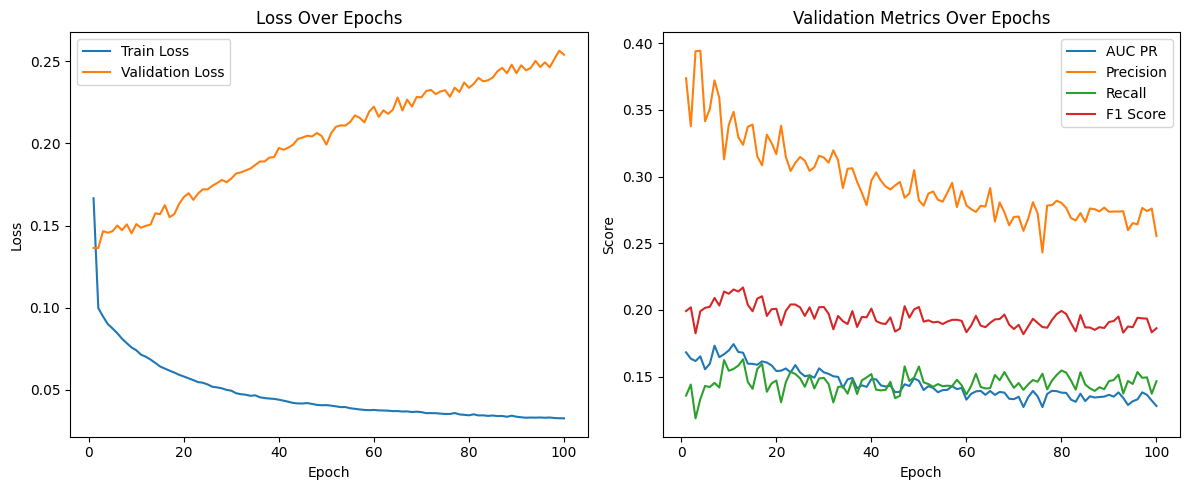

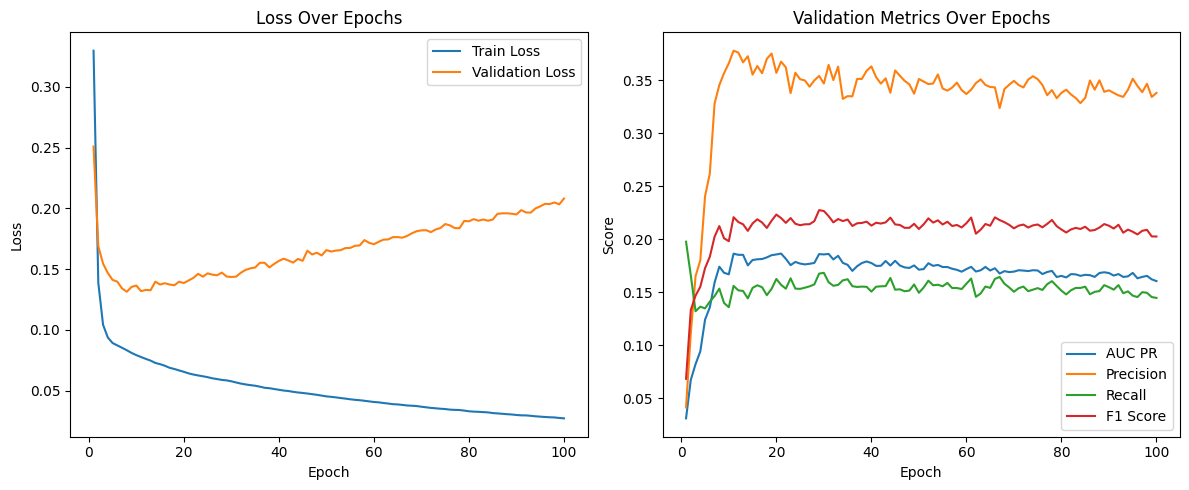

In [30]:
plot_training_history(history_withlr[0])
plot_training_history(history_withlr[1])
plot_training_history(history_withlr[2])

In [12]:
def train_model_test(model, train_loader, test_loader, lr ,pos_weight=3.0, num_epochs=10, device=None): #For Testing dataset
    """Train the wildfire segmentation model with comprehensive metrics."""
    # Set device
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([pos_weight], device=device)
    )

    # Optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr
    )

    # Training history
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_reg_loss': [],
        'test_reg_loss': [],
        'test_auc_pr': [],
        'test_precision': [],
        'test_recall': [],
        'test_f1_score': []
    }

    # Best model tracking
    best_auc_pr = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_reg_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.view(targets.size(0), -1).float()
            #targets = targets.view(-1, 4096).float()
            # Calculate losses 
            bce_loss = criterion(outputs, targets)
            #reg_loss = model.get_regularization_loss()
            #total_loss = bce_loss + reg_loss
            total_loss = bce_loss

            total_loss.backward()
            optimizer.step()

            train_loss += bce_loss.item() * inputs.size(0)
            #train_reg_loss += reg_loss.item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        #avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        #history['train_reg_loss'].append(avg_train_reg_loss)

        # Validation phase
        model.eval()
        test_loss = 0.0
        #val_reg_loss = 0.0

        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Test"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                targets = targets.view(targets.size(0), -1).float()
                #targets = targets.view(-1, 4096).float()
                # Calculate losses
                bce_loss = criterion(outputs, targets)
                #reg_loss = model.get_regularization_loss()

                test_loss += bce_loss.item() * inputs.size(0)
                #val_reg_loss += reg_loss.item() * inputs.size(0)

        avg_test_loss = test_loss / len(test_loader.dataset)
        #avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
        history['test_loss'].append(avg_test_loss)
        #history['val_reg_loss'].append(avg_val_reg_loss)

        # Calculate metrics
        metrics = evaluate_model_metrics(model, test_loader, device=device)

        # Store metrics in history
        for metric_name, metric_value in metrics.items():
            history[f'test_{metric_name}'].append(metric_value)

        # Save best model based on AUC PR
        auc_pr = metrics['auc_pr']
        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_model_state = model.state_dict().copy()
            print(f"New best model with AUC PR: {best_auc_pr:.4f}")

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Test Loss: {avg_test_loss:.4f} "
              f"AUC PR: {metrics['auc_pr']:.4f} "
              f"Precision: {metrics['precision']:.4f} "
              f"Recall: {metrics['recall']:.4f} "
              f"F1: {metrics['f1_score']:.4f}")

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    final_metrics = evaluate_model_metrics(model, test_loader, device=device)
    print("\nFinal Model Performance:")
    print(f"AUC PR: {final_metrics['auc_pr']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1 Score: {final_metrics['f1_score']:.4f}")

    return model, history, final_metrics

In [40]:
lr_list = [0.001,0.0001]
n_inputs=64*64*12
n_outputs=64*64*1
for lr in lr_list:
    print(f"learning rate: {lr}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = RNNClassifier(input_size=n_inputs, hidden_size=512, num_layers=2,num_classes=n_outputs).to(device)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_trained, history, final_metrics = train_model_test(model, train_loader, test_loader, lr=lr, pos_weight=3, num_epochs=100, device=device)
    #model_withlr.append(model_trained)
    history_withlr.append(history)
    final_metrics_withlr.append(final_metrics)

learning rate: 0.001


[Epoch 1/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.22it/s]


New best model with AUC PR: 0.1726
Epoch [1/100] Train Loss: 0.1649 Test Loss: 0.1219 AUC PR: 0.1726 Precision: 0.3535 Recall: 0.1549 F1: 0.2154


[Epoch 2/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.86it/s]


New best model with AUC PR: 0.1741
Epoch [2/100] Train Loss: 0.0997 Test Loss: 0.1274 AUC PR: 0.1741 Precision: 0.3427 Recall: 0.1733 F1: 0.2302


[Epoch 3/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.44it/s]


New best model with AUC PR: 0.1822
Epoch [3/100] Train Loss: 0.0944 Test Loss: 0.1274 AUC PR: 0.1822 Precision: 0.3716 Recall: 0.1574 F1: 0.2211


[Epoch 4/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 61.32it/s]


Epoch [4/100] Train Loss: 0.0900 Test Loss: 0.1290 AUC PR: 0.1787 Precision: 0.3670 Recall: 0.1557 F1: 0.2187


[Epoch 5/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 67.16it/s]


New best model with AUC PR: 0.1852
Epoch [5/100] Train Loss: 0.0862 Test Loss: 0.1266 AUC PR: 0.1852 Precision: 0.3746 Recall: 0.1566 F1: 0.2209


[Epoch 6/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 60.35it/s]


New best model with AUC PR: 0.1878
Epoch [6/100] Train Loss: 0.0837 Test Loss: 0.1260 AUC PR: 0.1878 Precision: 0.3732 Recall: 0.1566 F1: 0.2207


[Epoch 7/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 63.03it/s]


Epoch [7/100] Train Loss: 0.0810 Test Loss: 0.1350 AUC PR: 0.1651 Precision: 0.3393 Recall: 0.1469 F1: 0.2050


[Epoch 8/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.57it/s]


Epoch [8/100] Train Loss: 0.0777 Test Loss: 0.1349 AUC PR: 0.1865 Precision: 0.3638 Recall: 0.1698 F1: 0.2316


[Epoch 9/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 55.75it/s]


Epoch [9/100] Train Loss: 0.0751 Test Loss: 0.1357 AUC PR: 0.1831 Precision: 0.3605 Recall: 0.1675 F1: 0.2287


[Epoch 10/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.46it/s]


Epoch [10/100] Train Loss: 0.0728 Test Loss: 0.1304 AUC PR: 0.1851 Precision: 0.3421 Recall: 0.1724 F1: 0.2293


[Epoch 11/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.05it/s]


Epoch [11/100] Train Loss: 0.0713 Test Loss: 0.1340 AUC PR: 0.1809 Precision: 0.3681 Recall: 0.1626 F1: 0.2255


[Epoch 12/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.26it/s]


Epoch [12/100] Train Loss: 0.0694 Test Loss: 0.1333 AUC PR: 0.1771 Precision: 0.3393 Recall: 0.1619 F1: 0.2192


[Epoch 13/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.94it/s]


Epoch [13/100] Train Loss: 0.0670 Test Loss: 0.1317 AUC PR: 0.1654 Precision: 0.2829 Recall: 0.1871 F1: 0.2252


[Epoch 14/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.30it/s]


Epoch [14/100] Train Loss: 0.0647 Test Loss: 0.1393 AUC PR: 0.1703 Precision: 0.3165 Recall: 0.1724 F1: 0.2232


[Epoch 15/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.97it/s]


Epoch [15/100] Train Loss: 0.0638 Test Loss: 0.1340 AUC PR: 0.1693 Precision: 0.2891 Recall: 0.1907 F1: 0.2298


[Epoch 16/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.71it/s]


Epoch [16/100] Train Loss: 0.0625 Test Loss: 0.1402 AUC PR: 0.1665 Precision: 0.3326 Recall: 0.1562 F1: 0.2126


[Epoch 17/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.30it/s]


Epoch [17/100] Train Loss: 0.0611 Test Loss: 0.1418 AUC PR: 0.1733 Precision: 0.3320 Recall: 0.1731 F1: 0.2275


[Epoch 18/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.20it/s]


Epoch [18/100] Train Loss: 0.0593 Test Loss: 0.1418 AUC PR: 0.1678 Precision: 0.3196 Recall: 0.1632 F1: 0.2161


[Epoch 19/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.63it/s]


Epoch [19/100] Train Loss: 0.0581 Test Loss: 0.1445 AUC PR: 0.1697 Precision: 0.3291 Recall: 0.1619 F1: 0.2171


[Epoch 20/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.17it/s]


Epoch [20/100] Train Loss: 0.0571 Test Loss: 0.1464 AUC PR: 0.1673 Precision: 0.3205 Recall: 0.1657 F1: 0.2185


[Epoch 21/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.14it/s]


Epoch [21/100] Train Loss: 0.0564 Test Loss: 0.1430 AUC PR: 0.1611 Precision: 0.2910 Recall: 0.1763 F1: 0.2196


[Epoch 22/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.77it/s]


Epoch [22/100] Train Loss: 0.0556 Test Loss: 0.1469 AUC PR: 0.1664 Precision: 0.3197 Recall: 0.1708 F1: 0.2227


[Epoch 23/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.95it/s]


Epoch [23/100] Train Loss: 0.0542 Test Loss: 0.1469 AUC PR: 0.1626 Precision: 0.3053 Recall: 0.1668 F1: 0.2158


[Epoch 24/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 48.82it/s]


Epoch [24/100] Train Loss: 0.0535 Test Loss: 0.1527 AUC PR: 0.1607 Precision: 0.3133 Recall: 0.1600 F1: 0.2118


[Epoch 25/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 44.83it/s]


Epoch [25/100] Train Loss: 0.0526 Test Loss: 0.1520 AUC PR: 0.1631 Precision: 0.3187 Recall: 0.1553 F1: 0.2088


[Epoch 26/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.63it/s]


Epoch [26/100] Train Loss: 0.0522 Test Loss: 0.1546 AUC PR: 0.1595 Precision: 0.3135 Recall: 0.1637 F1: 0.2150


[Epoch 27/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 49.58it/s]


Epoch [27/100] Train Loss: 0.0513 Test Loss: 0.1550 AUC PR: 0.1645 Precision: 0.3249 Recall: 0.1680 F1: 0.2215


[Epoch 28/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.86it/s]


Epoch [28/100] Train Loss: 0.0505 Test Loss: 0.1562 AUC PR: 0.1573 Precision: 0.3068 Recall: 0.1586 F1: 0.2091


[Epoch 29/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 46.35it/s]


Epoch [29/100] Train Loss: 0.0494 Test Loss: 0.1600 AUC PR: 0.1609 Precision: 0.3144 Recall: 0.1636 F1: 0.2152


[Epoch 30/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 56.06it/s]


Epoch [30/100] Train Loss: 0.0485 Test Loss: 0.1595 AUC PR: 0.1680 Precision: 0.3240 Recall: 0.1730 F1: 0.2256


[Epoch 31/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.62it/s]


Epoch [31/100] Train Loss: 0.0481 Test Loss: 0.1585 AUC PR: 0.1685 Precision: 0.3320 Recall: 0.1658 F1: 0.2212


[Epoch 32/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.88it/s]


Epoch [32/100] Train Loss: 0.0475 Test Loss: 0.1583 AUC PR: 0.1615 Precision: 0.2961 Recall: 0.1765 F1: 0.2212


[Epoch 33/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.26it/s]


Epoch [33/100] Train Loss: 0.0470 Test Loss: 0.1600 AUC PR: 0.1657 Precision: 0.3175 Recall: 0.1711 F1: 0.2224


[Epoch 34/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.45it/s]


Epoch [34/100] Train Loss: 0.0467 Test Loss: 0.1603 AUC PR: 0.1629 Precision: 0.2947 Recall: 0.1862 F1: 0.2282


[Epoch 35/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.64it/s]


Epoch [35/100] Train Loss: 0.0462 Test Loss: 0.1613 AUC PR: 0.1630 Precision: 0.3015 Recall: 0.1801 F1: 0.2255


[Epoch 36/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 48.84it/s]


Epoch [36/100] Train Loss: 0.0458 Test Loss: 0.1672 AUC PR: 0.1617 Precision: 0.3067 Recall: 0.1714 F1: 0.2199


[Epoch 37/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.84it/s]


Epoch [37/100] Train Loss: 0.0453 Test Loss: 0.1678 AUC PR: 0.1650 Precision: 0.3094 Recall: 0.1810 F1: 0.2284


[Epoch 38/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.84it/s]


Epoch [38/100] Train Loss: 0.0445 Test Loss: 0.1678 AUC PR: 0.1580 Precision: 0.2976 Recall: 0.1705 F1: 0.2168


[Epoch 39/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.40it/s]


Epoch [39/100] Train Loss: 0.0447 Test Loss: 0.1709 AUC PR: 0.1433 Precision: 0.2735 Recall: 0.1562 F1: 0.1988


[Epoch 40/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 49.05it/s]


Epoch [40/100] Train Loss: 0.0437 Test Loss: 0.1706 AUC PR: 0.1460 Precision: 0.2694 Recall: 0.1719 F1: 0.2099


[Epoch 41/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 47.12it/s]


Epoch [41/100] Train Loss: 0.0434 Test Loss: 0.1743 AUC PR: 0.1488 Precision: 0.2929 Recall: 0.1616 F1: 0.2083


[Epoch 42/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.78it/s]


Epoch [42/100] Train Loss: 0.0428 Test Loss: 0.1764 AUC PR: 0.1477 Precision: 0.2930 Recall: 0.1572 F1: 0.2046


[Epoch 43/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.59it/s]


Epoch [43/100] Train Loss: 0.0424 Test Loss: 0.1758 AUC PR: 0.1477 Precision: 0.2827 Recall: 0.1627 F1: 0.2065


[Epoch 44/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 60.65it/s]


Epoch [44/100] Train Loss: 0.0422 Test Loss: 0.1740 AUC PR: 0.1559 Precision: 0.2982 Recall: 0.1677 F1: 0.2147


[Epoch 45/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.50it/s]


Epoch [45/100] Train Loss: 0.0422 Test Loss: 0.1796 AUC PR: 0.1483 Precision: 0.2930 Recall: 0.1572 F1: 0.2046


[Epoch 46/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.16it/s]


Epoch [46/100] Train Loss: 0.0415 Test Loss: 0.1804 AUC PR: 0.1496 Precision: 0.2866 Recall: 0.1617 F1: 0.2068


[Epoch 47/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.36it/s]


Epoch [47/100] Train Loss: 0.0414 Test Loss: 0.1813 AUC PR: 0.1475 Precision: 0.2889 Recall: 0.1602 F1: 0.2061


[Epoch 48/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.51it/s]


Epoch [48/100] Train Loss: 0.0410 Test Loss: 0.1804 AUC PR: 0.1555 Precision: 0.2928 Recall: 0.1725 F1: 0.2171


[Epoch 49/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.66it/s]


Epoch [49/100] Train Loss: 0.0409 Test Loss: 0.1812 AUC PR: 0.1487 Precision: 0.2860 Recall: 0.1651 F1: 0.2093


[Epoch 50/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.98it/s]


Epoch [50/100] Train Loss: 0.0403 Test Loss: 0.1805 AUC PR: 0.1556 Precision: 0.2875 Recall: 0.1767 F1: 0.2189


[Epoch 51/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 56.97it/s]


Epoch [51/100] Train Loss: 0.0402 Test Loss: 0.1856 AUC PR: 0.1547 Precision: 0.3017 Recall: 0.1655 F1: 0.2137


[Epoch 52/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.95it/s]


Epoch [52/100] Train Loss: 0.0412 Test Loss: 0.1824 AUC PR: 0.1467 Precision: 0.2767 Recall: 0.1700 F1: 0.2106


[Epoch 53/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 49.67it/s]


Epoch [53/100] Train Loss: 0.0398 Test Loss: 0.1854 AUC PR: 0.1575 Precision: 0.2910 Recall: 0.1805 F1: 0.2228


[Epoch 54/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 48.02it/s]


Epoch [54/100] Train Loss: 0.0396 Test Loss: 0.1878 AUC PR: 0.1464 Precision: 0.2832 Recall: 0.1660 F1: 0.2093


[Epoch 55/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 27.41it/s]


Epoch [55/100] Train Loss: 0.0388 Test Loss: 0.1904 AUC PR: 0.1506 Precision: 0.3018 Recall: 0.1546 F1: 0.2045


[Epoch 56/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 47.00it/s]


Epoch [56/100] Train Loss: 0.0387 Test Loss: 0.1874 AUC PR: 0.1561 Precision: 0.2977 Recall: 0.1699 F1: 0.2163


[Epoch 57/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.24it/s]


Epoch [57/100] Train Loss: 0.0382 Test Loss: 0.1888 AUC PR: 0.1494 Precision: 0.2942 Recall: 0.1605 F1: 0.2077


[Epoch 58/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.64it/s]


Epoch [58/100] Train Loss: 0.0392 Test Loss: 0.1909 AUC PR: 0.1497 Precision: 0.2929 Recall: 0.1653 F1: 0.2113


[Epoch 59/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 64.21it/s]


Epoch [59/100] Train Loss: 0.0381 Test Loss: 0.1914 AUC PR: 0.1460 Precision: 0.2800 Recall: 0.1631 F1: 0.2061


[Epoch 60/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 63.72it/s]


Epoch [60/100] Train Loss: 0.0380 Test Loss: 0.1929 AUC PR: 0.1460 Precision: 0.2814 Recall: 0.1661 F1: 0.2089


[Epoch 61/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 69.28it/s]


Epoch [61/100] Train Loss: 0.0378 Test Loss: 0.1959 AUC PR: 0.1431 Precision: 0.2760 Recall: 0.1692 F1: 0.2098


[Epoch 62/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.05it/s]


Epoch [62/100] Train Loss: 0.0373 Test Loss: 0.1921 AUC PR: 0.1466 Precision: 0.2872 Recall: 0.1618 F1: 0.2070


[Epoch 63/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 60.42it/s]


Epoch [63/100] Train Loss: 0.0378 Test Loss: 0.1969 AUC PR: 0.1467 Precision: 0.2879 Recall: 0.1665 F1: 0.2110


[Epoch 64/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.46it/s]


Epoch [64/100] Train Loss: 0.0375 Test Loss: 0.1941 AUC PR: 0.1465 Precision: 0.2833 Recall: 0.1719 F1: 0.2140


[Epoch 65/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.03it/s]


Epoch [65/100] Train Loss: 0.0370 Test Loss: 0.1998 AUC PR: 0.1493 Precision: 0.2895 Recall: 0.1695 F1: 0.2138


[Epoch 66/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 55.22it/s]


Epoch [66/100] Train Loss: 0.0370 Test Loss: 0.1988 AUC PR: 0.1496 Precision: 0.2892 Recall: 0.1762 F1: 0.2190


[Epoch 67/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 76.87it/s]


Epoch [67/100] Train Loss: 0.0368 Test Loss: 0.1988 AUC PR: 0.1431 Precision: 0.2760 Recall: 0.1708 F1: 0.2110


[Epoch 68/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.53it/s]


Epoch [68/100] Train Loss: 0.0367 Test Loss: 0.1995 AUC PR: 0.1478 Precision: 0.2819 Recall: 0.1703 F1: 0.2123


[Epoch 69/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 46.21it/s]


Epoch [69/100] Train Loss: 0.0366 Test Loss: 0.2013 AUC PR: 0.1463 Precision: 0.2855 Recall: 0.1644 F1: 0.2086


[Epoch 70/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.67it/s]


Epoch [70/100] Train Loss: 0.0360 Test Loss: 0.1998 AUC PR: 0.1447 Precision: 0.2733 Recall: 0.1733 F1: 0.2121


[Epoch 71/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.88it/s]


Epoch [71/100] Train Loss: 0.0357 Test Loss: 0.2035 AUC PR: 0.1479 Precision: 0.2912 Recall: 0.1693 F1: 0.2141


[Epoch 72/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 40.56it/s]


Epoch [72/100] Train Loss: 0.0358 Test Loss: 0.2043 AUC PR: 0.1477 Precision: 0.2841 Recall: 0.1734 F1: 0.2153


[Epoch 73/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.50it/s]


Epoch [73/100] Train Loss: 0.0360 Test Loss: 0.2051 AUC PR: 0.1435 Precision: 0.2798 Recall: 0.1686 F1: 0.2104


[Epoch 74/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.43it/s]


Epoch [74/100] Train Loss: 0.0355 Test Loss: 0.2044 AUC PR: 0.1484 Precision: 0.2867 Recall: 0.1711 F1: 0.2143


[Epoch 75/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 61.21it/s]


Epoch [75/100] Train Loss: 0.0354 Test Loss: 0.2025 AUC PR: 0.1535 Precision: 0.2916 Recall: 0.1768 F1: 0.2201


[Epoch 76/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.07it/s]


Epoch [76/100] Train Loss: 0.0351 Test Loss: 0.2054 AUC PR: 0.1511 Precision: 0.2939 Recall: 0.1720 F1: 0.2170


[Epoch 77/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.63it/s]


Epoch [77/100] Train Loss: 0.0351 Test Loss: 0.2022 AUC PR: 0.1499 Precision: 0.2775 Recall: 0.1820 F1: 0.2198


[Epoch 78/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 64.15it/s]


Epoch [78/100] Train Loss: 0.0349 Test Loss: 0.2090 AUC PR: 0.1498 Precision: 0.2915 Recall: 0.1691 F1: 0.2141


[Epoch 79/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.91it/s]


Epoch [79/100] Train Loss: 0.0348 Test Loss: 0.2092 AUC PR: 0.1509 Precision: 0.2937 Recall: 0.1689 F1: 0.2145


[Epoch 80/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.56it/s]


Epoch [80/100] Train Loss: 0.0349 Test Loss: 0.2079 AUC PR: 0.1469 Precision: 0.2897 Recall: 0.1678 F1: 0.2125


[Epoch 81/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 60.55it/s]


Epoch [81/100] Train Loss: 0.0345 Test Loss: 0.2082 AUC PR: 0.1520 Precision: 0.2937 Recall: 0.1719 F1: 0.2169


[Epoch 82/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.80it/s]


Epoch [82/100] Train Loss: 0.0342 Test Loss: 0.2100 AUC PR: 0.1473 Precision: 0.2889 Recall: 0.1696 F1: 0.2138


[Epoch 83/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 64.16it/s]


Epoch [83/100] Train Loss: 0.0342 Test Loss: 0.2086 AUC PR: 0.1430 Precision: 0.2756 Recall: 0.1696 F1: 0.2100


[Epoch 84/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.51it/s]


Epoch [84/100] Train Loss: 0.0341 Test Loss: 0.2111 AUC PR: 0.1470 Precision: 0.2850 Recall: 0.1677 F1: 0.2112


[Epoch 85/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 36.69it/s]


Epoch [85/100] Train Loss: 0.0337 Test Loss: 0.2133 AUC PR: 0.1474 Precision: 0.2876 Recall: 0.1703 F1: 0.2139


[Epoch 86/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 40.99it/s]


Epoch [86/100] Train Loss: 0.0338 Test Loss: 0.2125 AUC PR: 0.1423 Precision: 0.2713 Recall: 0.1715 F1: 0.2101


[Epoch 87/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.30it/s]


Epoch [87/100] Train Loss: 0.0337 Test Loss: 0.2151 AUC PR: 0.1400 Precision: 0.2691 Recall: 0.1740 F1: 0.2113


[Epoch 88/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.67it/s]


Epoch [88/100] Train Loss: 0.0340 Test Loss: 0.2175 AUC PR: 0.1363 Precision: 0.2663 Recall: 0.1592 F1: 0.1993


[Epoch 89/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.36it/s]


Epoch [89/100] Train Loss: 0.0341 Test Loss: 0.2172 AUC PR: 0.1411 Precision: 0.2802 Recall: 0.1596 F1: 0.2034


[Epoch 90/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.94it/s]


Epoch [90/100] Train Loss: 0.0335 Test Loss: 0.2165 AUC PR: 0.1402 Precision: 0.2759 Recall: 0.1630 F1: 0.2050


[Epoch 91/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.45it/s]


Epoch [91/100] Train Loss: 0.0332 Test Loss: 0.2210 AUC PR: 0.1398 Precision: 0.2769 Recall: 0.1568 F1: 0.2002


[Epoch 92/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.66it/s]


Epoch [92/100] Train Loss: 0.0327 Test Loss: 0.2249 AUC PR: 0.1344 Precision: 0.2767 Recall: 0.1512 F1: 0.1955


[Epoch 93/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.22it/s]


Epoch [93/100] Train Loss: 0.0329 Test Loss: 0.2206 AUC PR: 0.1383 Precision: 0.2715 Recall: 0.1636 F1: 0.2042


[Epoch 94/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 46.74it/s]


Epoch [94/100] Train Loss: 0.0331 Test Loss: 0.2225 AUC PR: 0.1342 Precision: 0.2634 Recall: 0.1631 F1: 0.2014


[Epoch 95/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.46it/s]


Epoch [95/100] Train Loss: 0.0331 Test Loss: 0.2224 AUC PR: 0.1375 Precision: 0.2651 Recall: 0.1700 F1: 0.2071


[Epoch 96/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.27it/s]


Epoch [96/100] Train Loss: 0.0331 Test Loss: 0.2242 AUC PR: 0.1399 Precision: 0.2722 Recall: 0.1625 F1: 0.2035


[Epoch 97/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.32it/s]


Epoch [97/100] Train Loss: 0.0326 Test Loss: 0.2261 AUC PR: 0.1353 Precision: 0.2712 Recall: 0.1605 F1: 0.2016


[Epoch 98/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 62.94it/s]


Epoch [98/100] Train Loss: 0.0328 Test Loss: 0.2213 AUC PR: 0.1422 Precision: 0.2697 Recall: 0.1781 F1: 0.2145


[Epoch 99/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 64.24it/s]


Epoch [99/100] Train Loss: 0.0323 Test Loss: 0.2257 AUC PR: 0.1406 Precision: 0.2705 Recall: 0.1723 F1: 0.2105


[Epoch 100/100] Test: 100%|████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 60.12it/s]


Epoch [100/100] Train Loss: 0.0323 Test Loss: 0.2283 AUC PR: 0.1368 Precision: 0.2704 Recall: 0.1638 F1: 0.2040

Final Model Performance:
AUC PR: 0.1368
Precision: 0.2704
Recall: 0.1638
F1 Score: 0.2040
learning rate: 0.0001


[Epoch 1/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 60.01it/s]


New best model with AUC PR: 0.0277
Epoch [1/100] Train Loss: 0.3343 Test Loss: 0.2460 AUC PR: 0.0277 Precision: 0.0435 Recall: 0.1826 F1: 0.0702


[Epoch 2/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.70it/s]


New best model with AUC PR: 0.0477
Epoch [2/100] Train Loss: 0.1385 Test Loss: 0.1701 AUC PR: 0.0477 Precision: 0.0877 Recall: 0.1674 F1: 0.1151


[Epoch 3/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 56.22it/s]


New best model with AUC PR: 0.0613
Epoch [3/100] Train Loss: 0.1030 Test Loss: 0.1520 AUC PR: 0.0613 Precision: 0.1010 Recall: 0.1526 F1: 0.1215


[Epoch 4/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.36it/s]


New best model with AUC PR: 0.0715
Epoch [4/100] Train Loss: 0.0940 Test Loss: 0.1472 AUC PR: 0.0715 Precision: 0.1155 Recall: 0.1700 F1: 0.1376


[Epoch 5/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.36it/s]


New best model with AUC PR: 0.0963
Epoch [5/100] Train Loss: 0.0894 Test Loss: 0.1399 AUC PR: 0.0963 Precision: 0.1432 Recall: 0.1653 F1: 0.1534


[Epoch 6/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.13it/s]


New best model with AUC PR: 0.1355
Epoch [6/100] Train Loss: 0.0876 Test Loss: 0.1322 AUC PR: 0.1355 Precision: 0.2206 Recall: 0.1571 F1: 0.1835


[Epoch 7/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.99it/s]


New best model with AUC PR: 0.1457
Epoch [7/100] Train Loss: 0.0849 Test Loss: 0.1295 AUC PR: 0.1457 Precision: 0.2316 Recall: 0.1671 F1: 0.1942


[Epoch 8/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.98it/s]


New best model with AUC PR: 0.1727
Epoch [8/100] Train Loss: 0.0829 Test Loss: 0.1235 AUC PR: 0.1727 Precision: 0.3395 Recall: 0.1601 F1: 0.2176


[Epoch 9/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 61.51it/s]


Epoch [9/100] Train Loss: 0.0813 Test Loss: 0.1233 AUC PR: 0.1542 Precision: 0.2903 Recall: 0.1604 F1: 0.2067


[Epoch 10/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.17it/s]


New best model with AUC PR: 0.1837
Epoch [10/100] Train Loss: 0.0792 Test Loss: 0.1204 AUC PR: 0.1837 Precision: 0.3179 Recall: 0.1757 F1: 0.2264


[Epoch 11/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.91it/s]


Epoch [11/100] Train Loss: 0.0775 Test Loss: 0.1213 AUC PR: 0.1817 Precision: 0.3335 Recall: 0.1713 F1: 0.2263


[Epoch 12/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.96it/s]


New best model with AUC PR: 0.1946
Epoch [12/100] Train Loss: 0.0762 Test Loss: 0.1189 AUC PR: 0.1946 Precision: 0.3804 Recall: 0.1661 F1: 0.2313


[Epoch 13/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 63.12it/s]


New best model with AUC PR: 0.2001
Epoch [13/100] Train Loss: 0.0742 Test Loss: 0.1189 AUC PR: 0.2001 Precision: 0.3817 Recall: 0.1735 F1: 0.2386


[Epoch 14/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.89it/s]


New best model with AUC PR: 0.2091
Epoch [14/100] Train Loss: 0.0733 Test Loss: 0.1155 AUC PR: 0.2091 Precision: 0.3959 Recall: 0.1759 F1: 0.2436


[Epoch 15/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.90it/s]


Epoch [15/100] Train Loss: 0.0717 Test Loss: 0.1160 AUC PR: 0.1991 Precision: 0.3518 Recall: 0.1754 F1: 0.2341


[Epoch 16/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 55.22it/s]


Epoch [16/100] Train Loss: 0.0698 Test Loss: 0.1194 AUC PR: 0.1977 Precision: 0.3619 Recall: 0.1747 F1: 0.2357


[Epoch 17/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.87it/s]


Epoch [17/100] Train Loss: 0.0686 Test Loss: 0.1224 AUC PR: 0.1980 Precision: 0.3865 Recall: 0.1631 F1: 0.2294


[Epoch 18/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 63.17it/s]


Epoch [18/100] Train Loss: 0.0678 Test Loss: 0.1219 AUC PR: 0.1989 Precision: 0.3801 Recall: 0.1748 F1: 0.2395


[Epoch 19/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 40.72it/s]


Epoch [19/100] Train Loss: 0.0667 Test Loss: 0.1227 AUC PR: 0.2069 Precision: 0.3948 Recall: 0.1732 F1: 0.2408


[Epoch 20/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 49.89it/s]


Epoch [20/100] Train Loss: 0.0657 Test Loss: 0.1257 AUC PR: 0.2005 Precision: 0.3784 Recall: 0.1766 F1: 0.2408


[Epoch 21/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.99it/s]


Epoch [21/100] Train Loss: 0.0647 Test Loss: 0.1232 AUC PR: 0.1987 Precision: 0.3563 Recall: 0.1819 F1: 0.2408


[Epoch 22/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.73it/s]


Epoch [22/100] Train Loss: 0.0636 Test Loss: 0.1221 AUC PR: 0.1975 Precision: 0.3562 Recall: 0.1790 F1: 0.2382


[Epoch 23/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.36it/s]


Epoch [23/100] Train Loss: 0.0627 Test Loss: 0.1238 AUC PR: 0.1949 Precision: 0.3321 Recall: 0.1897 F1: 0.2415


[Epoch 24/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.39it/s]


Epoch [24/100] Train Loss: 0.0617 Test Loss: 0.1295 AUC PR: 0.1929 Precision: 0.3748 Recall: 0.1737 F1: 0.2374


[Epoch 25/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.88it/s]


Epoch [25/100] Train Loss: 0.0609 Test Loss: 0.1257 AUC PR: 0.2053 Precision: 0.3762 Recall: 0.1842 F1: 0.2473


[Epoch 26/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 55.57it/s]


Epoch [26/100] Train Loss: 0.0599 Test Loss: 0.1267 AUC PR: 0.2054 Precision: 0.3739 Recall: 0.1879 F1: 0.2501


[Epoch 27/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.46it/s]


Epoch [27/100] Train Loss: 0.0595 Test Loss: 0.1279 AUC PR: 0.1973 Precision: 0.3498 Recall: 0.1911 F1: 0.2471


[Epoch 28/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.53it/s]


Epoch [28/100] Train Loss: 0.0591 Test Loss: 0.1278 AUC PR: 0.2037 Precision: 0.3739 Recall: 0.1841 F1: 0.2467


[Epoch 29/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.99it/s]


Epoch [29/100] Train Loss: 0.0582 Test Loss: 0.1289 AUC PR: 0.1989 Precision: 0.3789 Recall: 0.1691 F1: 0.2339


[Epoch 30/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 68.37it/s]


Epoch [30/100] Train Loss: 0.0574 Test Loss: 0.1263 AUC PR: 0.2008 Precision: 0.3555 Recall: 0.1824 F1: 0.2411


[Epoch 31/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.09it/s]


Epoch [31/100] Train Loss: 0.0567 Test Loss: 0.1299 AUC PR: 0.1985 Precision: 0.3675 Recall: 0.1723 F1: 0.2346


[Epoch 32/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 56.99it/s]


Epoch [32/100] Train Loss: 0.0559 Test Loss: 0.1315 AUC PR: 0.1921 Precision: 0.3693 Recall: 0.1702 F1: 0.2330


[Epoch 33/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.15it/s]


Epoch [33/100] Train Loss: 0.0551 Test Loss: 0.1335 AUC PR: 0.1974 Precision: 0.3771 Recall: 0.1704 F1: 0.2347


[Epoch 34/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.46it/s]


Epoch [34/100] Train Loss: 0.0545 Test Loss: 0.1355 AUC PR: 0.1941 Precision: 0.3712 Recall: 0.1727 F1: 0.2357


[Epoch 35/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.70it/s]


Epoch [35/100] Train Loss: 0.0537 Test Loss: 0.1316 AUC PR: 0.1952 Precision: 0.3625 Recall: 0.1758 F1: 0.2367


[Epoch 36/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.66it/s]


Epoch [36/100] Train Loss: 0.0532 Test Loss: 0.1357 AUC PR: 0.1927 Precision: 0.3738 Recall: 0.1732 F1: 0.2367


[Epoch 37/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.87it/s]


Epoch [37/100] Train Loss: 0.0523 Test Loss: 0.1346 AUC PR: 0.1946 Precision: 0.3698 Recall: 0.1710 F1: 0.2339


[Epoch 38/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.91it/s]


Epoch [38/100] Train Loss: 0.0517 Test Loss: 0.1354 AUC PR: 0.1922 Precision: 0.3599 Recall: 0.1692 F1: 0.2302


[Epoch 39/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 36.78it/s]


Epoch [39/100] Train Loss: 0.0511 Test Loss: 0.1379 AUC PR: 0.1888 Precision: 0.3685 Recall: 0.1650 F1: 0.2279


[Epoch 40/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.31it/s]


Epoch [40/100] Train Loss: 0.0507 Test Loss: 0.1366 AUC PR: 0.1919 Precision: 0.3540 Recall: 0.1772 F1: 0.2362


[Epoch 41/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 63.65it/s]


Epoch [41/100] Train Loss: 0.0499 Test Loss: 0.1404 AUC PR: 0.1874 Precision: 0.3577 Recall: 0.1683 F1: 0.2289


[Epoch 42/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.79it/s]


Epoch [42/100] Train Loss: 0.0495 Test Loss: 0.1390 AUC PR: 0.1931 Precision: 0.3662 Recall: 0.1738 F1: 0.2358


[Epoch 43/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 60.14it/s]


Epoch [43/100] Train Loss: 0.0493 Test Loss: 0.1387 AUC PR: 0.1918 Precision: 0.3634 Recall: 0.1717 F1: 0.2332


[Epoch 44/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.06it/s]


Epoch [44/100] Train Loss: 0.0486 Test Loss: 0.1380 AUC PR: 0.1932 Precision: 0.3539 Recall: 0.1753 F1: 0.2345


[Epoch 45/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.95it/s]


Epoch [45/100] Train Loss: 0.0480 Test Loss: 0.1362 AUC PR: 0.2040 Precision: 0.3651 Recall: 0.1906 F1: 0.2505


[Epoch 46/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 55.52it/s]


Epoch [46/100] Train Loss: 0.0473 Test Loss: 0.1416 AUC PR: 0.1990 Precision: 0.3725 Recall: 0.1812 F1: 0.2438


[Epoch 47/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.84it/s]


Epoch [47/100] Train Loss: 0.0466 Test Loss: 0.1410 AUC PR: 0.1928 Precision: 0.3695 Recall: 0.1716 F1: 0.2344


[Epoch 48/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.49it/s]


Epoch [48/100] Train Loss: 0.0462 Test Loss: 0.1419 AUC PR: 0.1975 Precision: 0.3677 Recall: 0.1820 F1: 0.2435


[Epoch 49/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.06it/s]


Epoch [49/100] Train Loss: 0.0460 Test Loss: 0.1395 AUC PR: 0.1996 Precision: 0.3736 Recall: 0.1816 F1: 0.2444


[Epoch 50/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 35.24it/s]


Epoch [50/100] Train Loss: 0.0456 Test Loss: 0.1424 AUC PR: 0.1963 Precision: 0.3715 Recall: 0.1776 F1: 0.2403


[Epoch 51/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.69it/s]


Epoch [51/100] Train Loss: 0.0450 Test Loss: 0.1432 AUC PR: 0.1986 Precision: 0.3682 Recall: 0.1909 F1: 0.2515


[Epoch 52/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.18it/s]


Epoch [52/100] Train Loss: 0.0444 Test Loss: 0.1472 AUC PR: 0.1943 Precision: 0.3738 Recall: 0.1785 F1: 0.2417


[Epoch 53/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.81it/s]


Epoch [53/100] Train Loss: 0.0442 Test Loss: 0.1439 AUC PR: 0.1934 Precision: 0.3517 Recall: 0.1913 F1: 0.2478


[Epoch 54/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 63.12it/s]


Epoch [54/100] Train Loss: 0.0436 Test Loss: 0.1496 AUC PR: 0.1893 Precision: 0.3595 Recall: 0.1822 F1: 0.2419


[Epoch 55/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 56.33it/s]


Epoch [55/100] Train Loss: 0.0432 Test Loss: 0.1474 AUC PR: 0.1854 Precision: 0.3532 Recall: 0.1752 F1: 0.2342


[Epoch 56/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.39it/s]


Epoch [56/100] Train Loss: 0.0426 Test Loss: 0.1507 AUC PR: 0.1839 Precision: 0.3640 Recall: 0.1669 F1: 0.2289


[Epoch 57/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.50it/s]


Epoch [57/100] Train Loss: 0.0422 Test Loss: 0.1505 AUC PR: 0.1847 Precision: 0.3537 Recall: 0.1743 F1: 0.2335


[Epoch 58/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.67it/s]


Epoch [58/100] Train Loss: 0.0418 Test Loss: 0.1504 AUC PR: 0.1854 Precision: 0.3601 Recall: 0.1704 F1: 0.2313


[Epoch 59/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.65it/s]


Epoch [59/100] Train Loss: 0.0412 Test Loss: 0.1487 AUC PR: 0.1864 Precision: 0.3590 Recall: 0.1766 F1: 0.2367


[Epoch 60/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.48it/s]


Epoch [60/100] Train Loss: 0.0406 Test Loss: 0.1515 AUC PR: 0.1851 Precision: 0.3589 Recall: 0.1747 F1: 0.2350


[Epoch 61/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.73it/s]


Epoch [61/100] Train Loss: 0.0403 Test Loss: 0.1547 AUC PR: 0.1861 Precision: 0.3572 Recall: 0.1828 F1: 0.2418


[Epoch 62/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.40it/s]


Epoch [62/100] Train Loss: 0.0401 Test Loss: 0.1512 AUC PR: 0.1917 Precision: 0.3675 Recall: 0.1827 F1: 0.2441


[Epoch 63/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.05it/s]


Epoch [63/100] Train Loss: 0.0399 Test Loss: 0.1542 AUC PR: 0.1880 Precision: 0.3631 Recall: 0.1762 F1: 0.2372


[Epoch 64/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.41it/s]


Epoch [64/100] Train Loss: 0.0392 Test Loss: 0.1565 AUC PR: 0.1842 Precision: 0.3700 Recall: 0.1710 F1: 0.2339


[Epoch 65/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.38it/s]


Epoch [65/100] Train Loss: 0.0387 Test Loss: 0.1565 AUC PR: 0.1839 Precision: 0.3582 Recall: 0.1743 F1: 0.2345


[Epoch 66/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.16it/s]


Epoch [66/100] Train Loss: 0.0381 Test Loss: 0.1572 AUC PR: 0.1809 Precision: 0.3448 Recall: 0.1811 F1: 0.2375


[Epoch 67/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.62it/s]


Epoch [67/100] Train Loss: 0.0380 Test Loss: 0.1563 AUC PR: 0.1852 Precision: 0.3589 Recall: 0.1777 F1: 0.2377


[Epoch 68/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 61.62it/s]


Epoch [68/100] Train Loss: 0.0374 Test Loss: 0.1593 AUC PR: 0.1882 Precision: 0.3693 Recall: 0.1800 F1: 0.2420


[Epoch 69/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 63.62it/s]


Epoch [69/100] Train Loss: 0.0370 Test Loss: 0.1612 AUC PR: 0.1827 Precision: 0.3622 Recall: 0.1694 F1: 0.2309


[Epoch 70/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 60.89it/s]


Epoch [70/100] Train Loss: 0.0367 Test Loss: 0.1608 AUC PR: 0.1834 Precision: 0.3667 Recall: 0.1688 F1: 0.2311


[Epoch 71/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.22it/s]


Epoch [71/100] Train Loss: 0.0363 Test Loss: 0.1623 AUC PR: 0.1841 Precision: 0.3651 Recall: 0.1713 F1: 0.2332


[Epoch 72/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 60.58it/s]


Epoch [72/100] Train Loss: 0.0361 Test Loss: 0.1619 AUC PR: 0.1833 Precision: 0.3558 Recall: 0.1748 F1: 0.2344


[Epoch 73/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 55.98it/s]


Epoch [73/100] Train Loss: 0.0358 Test Loss: 0.1629 AUC PR: 0.1813 Precision: 0.3638 Recall: 0.1700 F1: 0.2318


[Epoch 74/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.02it/s]


Epoch [74/100] Train Loss: 0.0353 Test Loss: 0.1651 AUC PR: 0.1832 Precision: 0.3724 Recall: 0.1691 F1: 0.2326


[Epoch 75/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.12it/s]


Epoch [75/100] Train Loss: 0.0350 Test Loss: 0.1640 AUC PR: 0.1833 Precision: 0.3626 Recall: 0.1741 F1: 0.2353


[Epoch 76/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 47.98it/s]


Epoch [76/100] Train Loss: 0.0347 Test Loss: 0.1671 AUC PR: 0.1811 Precision: 0.3636 Recall: 0.1659 F1: 0.2279


[Epoch 77/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.83it/s]


Epoch [77/100] Train Loss: 0.0341 Test Loss: 0.1659 AUC PR: 0.1825 Precision: 0.3580 Recall: 0.1746 F1: 0.2348


[Epoch 78/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 40.43it/s]


Epoch [78/100] Train Loss: 0.0336 Test Loss: 0.1674 AUC PR: 0.1811 Precision: 0.3695 Recall: 0.1689 F1: 0.2319


[Epoch 79/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 47.65it/s]


Epoch [79/100] Train Loss: 0.0334 Test Loss: 0.1705 AUC PR: 0.1776 Precision: 0.3606 Recall: 0.1631 F1: 0.2246


[Epoch 80/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 40.15it/s]


Epoch [80/100] Train Loss: 0.0331 Test Loss: 0.1701 AUC PR: 0.1809 Precision: 0.3695 Recall: 0.1678 F1: 0.2308


[Epoch 81/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.93it/s]


Epoch [81/100] Train Loss: 0.0328 Test Loss: 0.1694 AUC PR: 0.1805 Precision: 0.3665 Recall: 0.1653 F1: 0.2279


[Epoch 82/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 64.16it/s]


Epoch [82/100] Train Loss: 0.0324 Test Loss: 0.1711 AUC PR: 0.1781 Precision: 0.3638 Recall: 0.1632 F1: 0.2254


[Epoch 83/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 66.42it/s]


Epoch [83/100] Train Loss: 0.0322 Test Loss: 0.1695 AUC PR: 0.1852 Precision: 0.3687 Recall: 0.1755 F1: 0.2378


[Epoch 84/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 61.26it/s]


Epoch [84/100] Train Loss: 0.0319 Test Loss: 0.1701 AUC PR: 0.1829 Precision: 0.3656 Recall: 0.1660 F1: 0.2283


[Epoch 85/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.89it/s]


Epoch [85/100] Train Loss: 0.0315 Test Loss: 0.1706 AUC PR: 0.1820 Precision: 0.3572 Recall: 0.1762 F1: 0.2360


[Epoch 86/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.71it/s]


Epoch [86/100] Train Loss: 0.0313 Test Loss: 0.1734 AUC PR: 0.1827 Precision: 0.3696 Recall: 0.1685 F1: 0.2315


[Epoch 87/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.78it/s]


Epoch [87/100] Train Loss: 0.0310 Test Loss: 0.1723 AUC PR: 0.1797 Precision: 0.3559 Recall: 0.1663 F1: 0.2267


[Epoch 88/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.01it/s]


Epoch [88/100] Train Loss: 0.0307 Test Loss: 0.1737 AUC PR: 0.1819 Precision: 0.3594 Recall: 0.1695 F1: 0.2303


[Epoch 89/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.95it/s]


Epoch [89/100] Train Loss: 0.0303 Test Loss: 0.1774 AUC PR: 0.1785 Precision: 0.3677 Recall: 0.1638 F1: 0.2266


[Epoch 90/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 36.31it/s]


Epoch [90/100] Train Loss: 0.0301 Test Loss: 0.1803 AUC PR: 0.1753 Precision: 0.3665 Recall: 0.1602 F1: 0.2229


[Epoch 91/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.54it/s]


Epoch [91/100] Train Loss: 0.0298 Test Loss: 0.1761 AUC PR: 0.1778 Precision: 0.3612 Recall: 0.1639 F1: 0.2255


[Epoch 92/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 40.13it/s]


Epoch [92/100] Train Loss: 0.0294 Test Loss: 0.1787 AUC PR: 0.1762 Precision: 0.3636 Recall: 0.1611 F1: 0.2232


[Epoch 93/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 49.66it/s]


Epoch [93/100] Train Loss: 0.0292 Test Loss: 0.1766 AUC PR: 0.1767 Precision: 0.3575 Recall: 0.1664 F1: 0.2271


[Epoch 94/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 56.78it/s]


Epoch [94/100] Train Loss: 0.0289 Test Loss: 0.1791 AUC PR: 0.1742 Precision: 0.3457 Recall: 0.1661 F1: 0.2244


[Epoch 95/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.94it/s]


Epoch [95/100] Train Loss: 0.0288 Test Loss: 0.1799 AUC PR: 0.1766 Precision: 0.3512 Recall: 0.1672 F1: 0.2265


[Epoch 96/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 61.38it/s]


Epoch [96/100] Train Loss: 0.0286 Test Loss: 0.1813 AUC PR: 0.1785 Precision: 0.3547 Recall: 0.1731 F1: 0.2327


[Epoch 97/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 62.90it/s]


Epoch [97/100] Train Loss: 0.0282 Test Loss: 0.1818 AUC PR: 0.1764 Precision: 0.3537 Recall: 0.1653 F1: 0.2253


[Epoch 98/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 62.14it/s]


Epoch [98/100] Train Loss: 0.0279 Test Loss: 0.1825 AUC PR: 0.1803 Precision: 0.3675 Recall: 0.1665 F1: 0.2292


[Epoch 99/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.16it/s]


Epoch [99/100] Train Loss: 0.0276 Test Loss: 0.1830 AUC PR: 0.1824 Precision: 0.3704 Recall: 0.1674 F1: 0.2306


[Epoch 100/100] Test: 100%|████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 59.98it/s]


Epoch [100/100] Train Loss: 0.0273 Test Loss: 0.1831 AUC PR: 0.1786 Precision: 0.3634 Recall: 0.1671 F1: 0.2290

Final Model Performance:
AUC PR: 0.1786
Precision: 0.3634
Recall: 0.1671
F1 Score: 0.2290


LSTM

In [17]:
import random
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
 torch.cuda.manual_seed_all(SEED)
# define model
class LSTMClassifier(nn.Module):
 def __init__(self, input_size, hidden_size, num_layers, num_classes):
  super(LSTMClassifier, self).__init__()
  self.hidden_size = hidden_size
  self.num_layers = num_layers
  self.LSTM = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
  self.fc = nn.Linear(hidden_size, num_classes)
 def forward(self, x):
  x = x.view(x.size(0), 1, -1)
  h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
  c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
  out, _ = self.LSTM(x, (h0,c0))
  logit = self.fc(out[:, -1, :])
  #prob = nn.functional.softmax(logit, dim=1)
  return logit

In [18]:
lr_list = [0.01, 0.001,0.0001]
n_inputs=64*64*12
n_outputs=64*64*1
history_withlr = []
final_metrics_withlr = []
for lr in lr_list:
    print(f"learning rate: {lr}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = LSTMClassifier(input_size=n_inputs, hidden_size=512, num_layers=1,num_classes=n_outputs).to(device)
    model_trained, history, final_metrics = train_model(model, train_loader, val_loader, lr=lr, pos_weight=3, num_epochs=100, device=device)
    #model_withlr.append(model_trained)
    history_withlr.append(history)
    final_metrics_withlr.append(final_metrics)

learning rate: 0.01


[Epoch 1/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.48it/s]


New best model with AUC PR: 0.1305
Epoch [1/100] Train Loss: 0.1204 Val Loss: 0.1569 AUC PR: 0.1305 Precision: 0.2506 Recall: 0.1603 F1: 0.1955


[Epoch 2/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 37.17it/s]


New best model with AUC PR: 0.1344
Epoch [2/100] Train Loss: 0.1096 Val Loss: 0.1641 AUC PR: 0.1344 Precision: 0.2536 Recall: 0.1636 F1: 0.1989


[Epoch 3/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 38.38it/s]


Epoch [3/100] Train Loss: 0.1056 Val Loss: 0.1781 AUC PR: 0.1174 Precision: 0.2203 Recall: 0.1591 F1: 0.1848


[Epoch 4/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.99it/s]


Epoch [4/100] Train Loss: 0.1015 Val Loss: 0.1760 AUC PR: 0.1108 Precision: 0.2160 Recall: 0.1427 F1: 0.1719


[Epoch 5/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 38.79it/s]


Epoch [5/100] Train Loss: 0.0984 Val Loss: 0.1836 AUC PR: 0.1111 Precision: 0.2262 Recall: 0.1418 F1: 0.1743


[Epoch 6/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.72it/s]


Epoch [6/100] Train Loss: 0.0983 Val Loss: 0.1801 AUC PR: 0.1165 Precision: 0.2050 Recall: 0.1686 F1: 0.1850


[Epoch 7/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.97it/s]


Epoch [7/100] Train Loss: 0.0961 Val Loss: 0.1809 AUC PR: 0.1094 Precision: 0.1965 Recall: 0.1587 F1: 0.1756


[Epoch 8/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.03it/s]


Epoch [8/100] Train Loss: 0.0944 Val Loss: 0.1879 AUC PR: 0.0976 Precision: 0.1841 Recall: 0.1441 F1: 0.1617


[Epoch 9/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.23it/s]


Epoch [9/100] Train Loss: 0.0919 Val Loss: 0.1917 AUC PR: 0.1103 Precision: 0.2030 Recall: 0.1634 F1: 0.1811


[Epoch 10/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.58it/s]


Epoch [10/100] Train Loss: 0.0917 Val Loss: 0.1946 AUC PR: 0.0984 Precision: 0.1864 Recall: 0.1521 F1: 0.1675


[Epoch 11/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.39it/s]


Epoch [11/100] Train Loss: 0.0904 Val Loss: 0.1986 AUC PR: 0.0954 Precision: 0.1846 Recall: 0.1486 F1: 0.1647


[Epoch 12/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 37.55it/s]


Epoch [12/100] Train Loss: 0.0896 Val Loss: 0.2023 AUC PR: 0.1029 Precision: 0.1968 Recall: 0.1570 F1: 0.1746


[Epoch 13/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 37.65it/s]


Epoch [13/100] Train Loss: 0.0883 Val Loss: 0.2067 AUC PR: 0.0986 Precision: 0.1849 Recall: 0.1600 F1: 0.1716


[Epoch 14/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.33it/s]


Epoch [14/100] Train Loss: 0.0872 Val Loss: 0.2062 AUC PR: 0.0948 Precision: 0.1789 Recall: 0.1638 F1: 0.1710


[Epoch 15/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.25it/s]


Epoch [15/100] Train Loss: 0.0862 Val Loss: 0.2100 AUC PR: 0.1040 Precision: 0.1902 Recall: 0.1693 F1: 0.1791


[Epoch 16/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 36.37it/s]


Epoch [16/100] Train Loss: 0.0864 Val Loss: 0.2167 AUC PR: 0.0938 Precision: 0.1917 Recall: 0.1401 F1: 0.1619


[Epoch 17/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 36.59it/s]


Epoch [17/100] Train Loss: 0.0859 Val Loss: 0.2132 AUC PR: 0.0939 Precision: 0.1816 Recall: 0.1426 F1: 0.1598


[Epoch 18/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 38.15it/s]


Epoch [18/100] Train Loss: 0.0852 Val Loss: 0.2188 AUC PR: 0.0943 Precision: 0.1836 Recall: 0.1517 F1: 0.1661


[Epoch 19/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.76it/s]


Epoch [19/100] Train Loss: 0.0848 Val Loss: 0.2183 AUC PR: 0.0887 Precision: 0.1761 Recall: 0.1464 F1: 0.1599


[Epoch 20/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.95it/s]


Epoch [20/100] Train Loss: 0.0838 Val Loss: 0.2240 AUC PR: 0.0975 Precision: 0.1879 Recall: 0.1615 F1: 0.1737


[Epoch 21/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.77it/s]


Epoch [21/100] Train Loss: 0.0829 Val Loss: 0.2257 AUC PR: 0.0923 Precision: 0.1791 Recall: 0.1535 F1: 0.1653


[Epoch 22/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.39it/s]


Epoch [22/100] Train Loss: 0.0821 Val Loss: 0.2275 AUC PR: 0.0912 Precision: 0.1693 Recall: 0.1709 F1: 0.1701


[Epoch 23/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 36.51it/s]


Epoch [23/100] Train Loss: 0.0814 Val Loss: 0.2278 AUC PR: 0.0929 Precision: 0.1839 Recall: 0.1472 F1: 0.1635


[Epoch 24/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.96it/s]


Epoch [24/100] Train Loss: 0.0818 Val Loss: 0.2318 AUC PR: 0.0862 Precision: 0.1715 Recall: 0.1497 F1: 0.1598


[Epoch 25/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 37.85it/s]


Epoch [25/100] Train Loss: 0.0814 Val Loss: 0.2298 AUC PR: 0.0902 Precision: 0.1702 Recall: 0.1701 F1: 0.1702


[Epoch 26/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.61it/s]


Epoch [26/100] Train Loss: 0.0813 Val Loss: 0.2343 AUC PR: 0.0894 Precision: 0.1686 Recall: 0.1608 F1: 0.1646


[Epoch 27/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.40it/s]


Epoch [27/100] Train Loss: 0.0811 Val Loss: 0.2355 AUC PR: 0.0866 Precision: 0.1697 Recall: 0.1522 F1: 0.1604


[Epoch 28/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.64it/s]


Epoch [28/100] Train Loss: 0.0805 Val Loss: 0.2374 AUC PR: 0.0906 Precision: 0.1746 Recall: 0.1602 F1: 0.1671


[Epoch 29/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.49it/s]


Epoch [29/100] Train Loss: 0.0796 Val Loss: 0.2387 AUC PR: 0.0896 Precision: 0.1753 Recall: 0.1464 F1: 0.1596


[Epoch 30/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 38.05it/s]


Epoch [30/100] Train Loss: 0.0791 Val Loss: 0.2428 AUC PR: 0.0834 Precision: 0.1598 Recall: 0.1569 F1: 0.1583


[Epoch 31/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.84it/s]


Epoch [31/100] Train Loss: 0.0793 Val Loss: 0.2438 AUC PR: 0.0830 Precision: 0.1677 Recall: 0.1468 F1: 0.1565


[Epoch 32/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.63it/s]


Epoch [32/100] Train Loss: 0.0783 Val Loss: 0.2392 AUC PR: 0.0870 Precision: 0.1680 Recall: 0.1561 F1: 0.1618


[Epoch 33/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.34it/s]


Epoch [33/100] Train Loss: 0.0782 Val Loss: 0.2431 AUC PR: 0.0843 Precision: 0.1580 Recall: 0.1758 F1: 0.1664


[Epoch 34/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.60it/s]


Epoch [34/100] Train Loss: 0.0779 Val Loss: 0.2464 AUC PR: 0.0797 Precision: 0.1571 Recall: 0.1539 F1: 0.1555


[Epoch 35/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.11it/s]


Epoch [35/100] Train Loss: 0.0769 Val Loss: 0.2479 AUC PR: 0.0824 Precision: 0.1581 Recall: 0.1560 F1: 0.1571


[Epoch 36/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.36it/s]


Epoch [36/100] Train Loss: 0.0768 Val Loss: 0.2486 AUC PR: 0.0807 Precision: 0.1604 Recall: 0.1464 F1: 0.1530


[Epoch 37/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.58it/s]


Epoch [37/100] Train Loss: 0.0764 Val Loss: 0.2533 AUC PR: 0.0812 Precision: 0.1614 Recall: 0.1499 F1: 0.1554


[Epoch 38/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:03<00:00, 18.29it/s]


Epoch [38/100] Train Loss: 0.0762 Val Loss: 0.2534 AUC PR: 0.0829 Precision: 0.1668 Recall: 0.1492 F1: 0.1575


[Epoch 39/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:02<00:00, 28.64it/s]


Epoch [39/100] Train Loss: 0.0754 Val Loss: 0.2540 AUC PR: 0.0848 Precision: 0.1673 Recall: 0.1415 F1: 0.1533


[Epoch 40/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.72it/s]


Epoch [40/100] Train Loss: 0.0758 Val Loss: 0.2573 AUC PR: 0.0836 Precision: 0.1623 Recall: 0.1542 F1: 0.1582


[Epoch 41/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.58it/s]


Epoch [41/100] Train Loss: 0.0761 Val Loss: 0.2568 AUC PR: 0.0880 Precision: 0.1733 Recall: 0.1639 F1: 0.1684


[Epoch 42/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.08it/s]


Epoch [42/100] Train Loss: 0.0750 Val Loss: 0.2569 AUC PR: 0.0877 Precision: 0.1705 Recall: 0.1636 F1: 0.1670


[Epoch 43/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.19it/s]


Epoch [43/100] Train Loss: 0.0745 Val Loss: 0.2564 AUC PR: 0.0869 Precision: 0.1719 Recall: 0.1501 F1: 0.1603


[Epoch 44/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.20it/s]


Epoch [44/100] Train Loss: 0.0743 Val Loss: 0.2611 AUC PR: 0.0857 Precision: 0.1676 Recall: 0.1571 F1: 0.1622


[Epoch 45/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.51it/s]


Epoch [45/100] Train Loss: 0.0740 Val Loss: 0.2620 AUC PR: 0.0856 Precision: 0.1685 Recall: 0.1689 F1: 0.1687


[Epoch 46/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.55it/s]


Epoch [46/100] Train Loss: 0.0744 Val Loss: 0.2614 AUC PR: 0.0783 Precision: 0.1480 Recall: 0.1539 F1: 0.1509


[Epoch 47/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.47it/s]


Epoch [47/100] Train Loss: 0.0735 Val Loss: 0.2630 AUC PR: 0.0825 Precision: 0.1617 Recall: 0.1515 F1: 0.1564


[Epoch 48/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.89it/s]


Epoch [48/100] Train Loss: 0.0732 Val Loss: 0.2677 AUC PR: 0.0798 Precision: 0.1554 Recall: 0.1492 F1: 0.1522


[Epoch 49/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.88it/s]


Epoch [49/100] Train Loss: 0.0735 Val Loss: 0.2686 AUC PR: 0.0831 Precision: 0.1629 Recall: 0.1555 F1: 0.1591


[Epoch 50/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.67it/s]


Epoch [50/100] Train Loss: 0.0743 Val Loss: 0.2704 AUC PR: 0.0792 Precision: 0.1563 Recall: 0.1531 F1: 0.1547


[Epoch 51/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.31it/s]


Epoch [51/100] Train Loss: 0.0738 Val Loss: 0.2713 AUC PR: 0.0824 Precision: 0.1627 Recall: 0.1625 F1: 0.1626


[Epoch 52/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.13it/s]


Epoch [52/100] Train Loss: 0.0738 Val Loss: 0.2699 AUC PR: 0.0856 Precision: 0.1640 Recall: 0.1803 F1: 0.1718


[Epoch 53/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.31it/s]


Epoch [53/100] Train Loss: 0.0736 Val Loss: 0.2749 AUC PR: 0.0835 Precision: 0.1640 Recall: 0.1599 F1: 0.1619


[Epoch 54/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.57it/s]


Epoch [54/100] Train Loss: 0.0734 Val Loss: 0.2727 AUC PR: 0.0810 Precision: 0.1580 Recall: 0.1667 F1: 0.1622


[Epoch 55/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.42it/s]


Epoch [55/100] Train Loss: 0.0735 Val Loss: 0.2706 AUC PR: 0.0858 Precision: 0.1610 Recall: 0.1746 F1: 0.1675


[Epoch 56/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.79it/s]


Epoch [56/100] Train Loss: 0.0735 Val Loss: 0.2763 AUC PR: 0.0865 Precision: 0.1687 Recall: 0.1603 F1: 0.1644


[Epoch 57/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.29it/s]


Epoch [57/100] Train Loss: 0.0729 Val Loss: 0.2786 AUC PR: 0.0813 Precision: 0.1605 Recall: 0.1532 F1: 0.1568


[Epoch 58/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.01it/s]


Epoch [58/100] Train Loss: 0.0730 Val Loss: 0.2804 AUC PR: 0.0819 Precision: 0.1631 Recall: 0.1544 F1: 0.1586


[Epoch 59/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.25it/s]


Epoch [59/100] Train Loss: 0.0728 Val Loss: 0.2826 AUC PR: 0.0800 Precision: 0.1577 Recall: 0.1533 F1: 0.1555


[Epoch 60/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.48it/s]


Epoch [60/100] Train Loss: 0.0722 Val Loss: 0.2877 AUC PR: 0.0766 Precision: 0.1549 Recall: 0.1414 F1: 0.1478


[Epoch 61/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.00it/s]


Epoch [61/100] Train Loss: 0.0720 Val Loss: 0.2827 AUC PR: 0.0794 Precision: 0.1561 Recall: 0.1538 F1: 0.1549


[Epoch 62/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.52it/s]


Epoch [62/100] Train Loss: 0.0715 Val Loss: 0.2866 AUC PR: 0.0841 Precision: 0.1630 Recall: 0.1681 F1: 0.1655


[Epoch 63/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.46it/s]


Epoch [63/100] Train Loss: 0.0717 Val Loss: 0.2884 AUC PR: 0.0779 Precision: 0.1547 Recall: 0.1483 F1: 0.1514


[Epoch 64/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.32it/s]


Epoch [64/100] Train Loss: 0.0720 Val Loss: 0.2890 AUC PR: 0.0808 Precision: 0.1579 Recall: 0.1674 F1: 0.1625


[Epoch 65/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.28it/s]


Epoch [65/100] Train Loss: 0.0714 Val Loss: 0.2890 AUC PR: 0.0793 Precision: 0.1559 Recall: 0.1615 F1: 0.1587


[Epoch 66/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.29it/s]


Epoch [66/100] Train Loss: 0.0710 Val Loss: 0.2929 AUC PR: 0.0751 Precision: 0.1467 Recall: 0.1519 F1: 0.1493


[Epoch 67/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.25it/s]


Epoch [67/100] Train Loss: 0.0712 Val Loss: 0.2909 AUC PR: 0.0784 Precision: 0.1509 Recall: 0.1635 F1: 0.1569


[Epoch 68/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.83it/s]


Epoch [68/100] Train Loss: 0.0704 Val Loss: 0.2923 AUC PR: 0.0818 Precision: 0.1565 Recall: 0.1762 F1: 0.1658


[Epoch 69/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.82it/s]


Epoch [69/100] Train Loss: 0.0704 Val Loss: 0.2956 AUC PR: 0.0823 Precision: 0.1619 Recall: 0.1665 F1: 0.1642


[Epoch 70/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.80it/s]


Epoch [70/100] Train Loss: 0.0693 Val Loss: 0.2978 AUC PR: 0.0772 Precision: 0.1524 Recall: 0.1584 F1: 0.1553


[Epoch 71/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.76it/s]


Epoch [71/100] Train Loss: 0.0691 Val Loss: 0.2961 AUC PR: 0.0797 Precision: 0.1573 Recall: 0.1574 F1: 0.1574


[Epoch 72/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.34it/s]


Epoch [72/100] Train Loss: 0.0688 Val Loss: 0.2989 AUC PR: 0.0803 Precision: 0.1586 Recall: 0.1626 F1: 0.1606


[Epoch 73/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.39it/s]


Epoch [73/100] Train Loss: 0.0693 Val Loss: 0.3001 AUC PR: 0.0733 Precision: 0.1423 Recall: 0.1463 F1: 0.1443


[Epoch 74/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.08it/s]


Epoch [74/100] Train Loss: 0.0705 Val Loss: 0.3026 AUC PR: 0.0741 Precision: 0.1471 Recall: 0.1458 F1: 0.1464


[Epoch 75/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.60it/s]


Epoch [75/100] Train Loss: 0.0698 Val Loss: 0.3002 AUC PR: 0.0771 Precision: 0.1495 Recall: 0.1635 F1: 0.1562


[Epoch 76/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.73it/s]


Epoch [76/100] Train Loss: 0.0696 Val Loss: 0.3014 AUC PR: 0.0769 Precision: 0.1502 Recall: 0.1675 F1: 0.1584


[Epoch 77/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.17it/s]


Epoch [77/100] Train Loss: 0.0696 Val Loss: 0.3002 AUC PR: 0.0772 Precision: 0.1502 Recall: 0.1500 F1: 0.1501


[Epoch 78/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.33it/s]


Epoch [78/100] Train Loss: 0.0697 Val Loss: 0.3022 AUC PR: 0.0778 Precision: 0.1475 Recall: 0.1614 F1: 0.1541


[Epoch 79/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.42it/s]


Epoch [79/100] Train Loss: 0.0697 Val Loss: 0.3055 AUC PR: 0.0769 Precision: 0.1500 Recall: 0.1518 F1: 0.1509


[Epoch 80/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.70it/s]


Epoch [80/100] Train Loss: 0.0693 Val Loss: 0.3083 AUC PR: 0.0782 Precision: 0.1548 Recall: 0.1539 F1: 0.1544


[Epoch 81/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.78it/s]


Epoch [81/100] Train Loss: 0.0689 Val Loss: 0.3117 AUC PR: 0.0770 Precision: 0.1477 Recall: 0.1586 F1: 0.1530


[Epoch 82/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.86it/s]


Epoch [82/100] Train Loss: 0.0688 Val Loss: 0.3104 AUC PR: 0.0752 Precision: 0.1427 Recall: 0.1616 F1: 0.1516


[Epoch 83/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.16it/s]


Epoch [83/100] Train Loss: 0.0691 Val Loss: 0.3131 AUC PR: 0.0711 Precision: 0.1377 Recall: 0.1395 F1: 0.1386


[Epoch 84/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.67it/s]


Epoch [84/100] Train Loss: 0.0690 Val Loss: 0.3197 AUC PR: 0.0725 Precision: 0.1448 Recall: 0.1471 F1: 0.1459


[Epoch 85/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 68.01it/s]


Epoch [85/100] Train Loss: 0.0696 Val Loss: 0.3203 AUC PR: 0.0748 Precision: 0.1520 Recall: 0.1496 F1: 0.1508


[Epoch 86/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.89it/s]


Epoch [86/100] Train Loss: 0.0693 Val Loss: 0.3198 AUC PR: 0.0721 Precision: 0.1397 Recall: 0.1459 F1: 0.1427


[Epoch 87/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.69it/s]


Epoch [87/100] Train Loss: 0.0692 Val Loss: 0.3146 AUC PR: 0.0750 Precision: 0.1498 Recall: 0.1561 F1: 0.1529


[Epoch 88/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.60it/s]


Epoch [88/100] Train Loss: 0.0685 Val Loss: 0.3199 AUC PR: 0.0803 Precision: 0.1598 Recall: 0.1541 F1: 0.1569


[Epoch 89/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.89it/s]


Epoch [89/100] Train Loss: 0.0683 Val Loss: 0.3171 AUC PR: 0.0766 Precision: 0.1466 Recall: 0.1567 F1: 0.1515


[Epoch 90/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.50it/s]


Epoch [90/100] Train Loss: 0.0684 Val Loss: 0.3131 AUC PR: 0.0758 Precision: 0.1453 Recall: 0.1566 F1: 0.1508


[Epoch 91/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.12it/s]


Epoch [91/100] Train Loss: 0.0682 Val Loss: 0.3164 AUC PR: 0.0773 Precision: 0.1481 Recall: 0.1704 F1: 0.1585


[Epoch 92/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.21it/s]


Epoch [92/100] Train Loss: 0.0679 Val Loss: 0.3195 AUC PR: 0.0775 Precision: 0.1499 Recall: 0.1575 F1: 0.1536


[Epoch 93/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.85it/s]


Epoch [93/100] Train Loss: 0.0675 Val Loss: 0.3167 AUC PR: 0.0731 Precision: 0.1365 Recall: 0.1436 F1: 0.1400


[Epoch 94/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.71it/s]


Epoch [94/100] Train Loss: 0.0673 Val Loss: 0.3182 AUC PR: 0.0746 Precision: 0.1408 Recall: 0.1561 F1: 0.1480


[Epoch 95/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.99it/s]


Epoch [95/100] Train Loss: 0.0663 Val Loss: 0.3183 AUC PR: 0.0791 Precision: 0.1474 Recall: 0.1765 F1: 0.1607


[Epoch 96/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.99it/s]


Epoch [96/100] Train Loss: 0.0677 Val Loss: 0.3204 AUC PR: 0.0781 Precision: 0.1477 Recall: 0.1621 F1: 0.1546


[Epoch 97/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.09it/s]


Epoch [97/100] Train Loss: 0.0679 Val Loss: 0.3214 AUC PR: 0.0809 Precision: 0.1536 Recall: 0.1761 F1: 0.1641


[Epoch 98/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.26it/s]


Epoch [98/100] Train Loss: 0.0671 Val Loss: 0.3225 AUC PR: 0.0786 Precision: 0.1546 Recall: 0.1523 F1: 0.1535


[Epoch 99/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.73it/s]


Epoch [99/100] Train Loss: 0.0666 Val Loss: 0.3236 AUC PR: 0.0748 Precision: 0.1429 Recall: 0.1498 F1: 0.1463


[Epoch 100/100] Validation: 100%|██████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.19it/s]


Epoch [100/100] Train Loss: 0.0666 Val Loss: 0.3251 AUC PR: 0.0819 Precision: 0.1580 Recall: 0.1668 F1: 0.1623

Final Model Performance:
AUC PR: 0.0819
Precision: 0.1580
Recall: 0.1668
F1 Score: 0.1623
learning rate: 0.001


[Epoch 1/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.90it/s]


New best model with AUC PR: 0.1724
Epoch [1/100] Train Loss: 0.1223 Val Loss: 0.1334 AUC PR: 0.1724 Precision: 0.3974 Recall: 0.1382 F1: 0.2051


[Epoch 2/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.70it/s]


New best model with AUC PR: 0.1727
Epoch [2/100] Train Loss: 0.0973 Val Loss: 0.1359 AUC PR: 0.1727 Precision: 0.4294 Recall: 0.1244 F1: 0.1929


[Epoch 3/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.92it/s]


New best model with AUC PR: 0.1759
Epoch [3/100] Train Loss: 0.0932 Val Loss: 0.1340 AUC PR: 0.1759 Precision: 0.4109 Recall: 0.1335 F1: 0.2016


[Epoch 4/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.30it/s]


New best model with AUC PR: 0.1772
Epoch [4/100] Train Loss: 0.0894 Val Loss: 0.1346 AUC PR: 0.1772 Precision: 0.3974 Recall: 0.1425 F1: 0.2098


[Epoch 5/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.71it/s]


Epoch [5/100] Train Loss: 0.0867 Val Loss: 0.1359 AUC PR: 0.1728 Precision: 0.3910 Recall: 0.1345 F1: 0.2001


[Epoch 6/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.77it/s]


Epoch [6/100] Train Loss: 0.0843 Val Loss: 0.1386 AUC PR: 0.1714 Precision: 0.3942 Recall: 0.1364 F1: 0.2026


[Epoch 7/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.75it/s]


Epoch [7/100] Train Loss: 0.0826 Val Loss: 0.1383 AUC PR: 0.1739 Precision: 0.3881 Recall: 0.1384 F1: 0.2040


[Epoch 8/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.34it/s]


Epoch [8/100] Train Loss: 0.0807 Val Loss: 0.1372 AUC PR: 0.1703 Precision: 0.3768 Recall: 0.1395 F1: 0.2036


[Epoch 9/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.73it/s]


Epoch [9/100] Train Loss: 0.0790 Val Loss: 0.1440 AUC PR: 0.1652 Precision: 0.3770 Recall: 0.1376 F1: 0.2016


[Epoch 10/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.41it/s]


Epoch [10/100] Train Loss: 0.0773 Val Loss: 0.1442 AUC PR: 0.1675 Precision: 0.3871 Recall: 0.1338 F1: 0.1989


[Epoch 11/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.05it/s]


Epoch [11/100] Train Loss: 0.0761 Val Loss: 0.1426 AUC PR: 0.1737 Precision: 0.4009 Recall: 0.1370 F1: 0.2042


[Epoch 12/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.80it/s]


Epoch [12/100] Train Loss: 0.0752 Val Loss: 0.1447 AUC PR: 0.1679 Precision: 0.3702 Recall: 0.1431 F1: 0.2064


[Epoch 13/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.39it/s]


Epoch [13/100] Train Loss: 0.0742 Val Loss: 0.1440 AUC PR: 0.1662 Precision: 0.3485 Recall: 0.1471 F1: 0.2069


[Epoch 14/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.28it/s]


Epoch [14/100] Train Loss: 0.0729 Val Loss: 0.1465 AUC PR: 0.1636 Precision: 0.3493 Recall: 0.1450 F1: 0.2049


[Epoch 15/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.42it/s]


Epoch [15/100] Train Loss: 0.0719 Val Loss: 0.1478 AUC PR: 0.1631 Precision: 0.3508 Recall: 0.1438 F1: 0.2039


[Epoch 16/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.88it/s]


Epoch [16/100] Train Loss: 0.0712 Val Loss: 0.1486 AUC PR: 0.1602 Precision: 0.3356 Recall: 0.1482 F1: 0.2056


[Epoch 17/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.00it/s]


Epoch [17/100] Train Loss: 0.0697 Val Loss: 0.1487 AUC PR: 0.1623 Precision: 0.3547 Recall: 0.1373 F1: 0.1979


[Epoch 18/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.05it/s]


Epoch [18/100] Train Loss: 0.0684 Val Loss: 0.1493 AUC PR: 0.1601 Precision: 0.3363 Recall: 0.1455 F1: 0.2031


[Epoch 19/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.14it/s]


Epoch [19/100] Train Loss: 0.0682 Val Loss: 0.1479 AUC PR: 0.1599 Precision: 0.3268 Recall: 0.1434 F1: 0.1993


[Epoch 20/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.37it/s]


Epoch [20/100] Train Loss: 0.0675 Val Loss: 0.1499 AUC PR: 0.1645 Precision: 0.3350 Recall: 0.1510 F1: 0.2082


[Epoch 21/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 90.51it/s]


Epoch [21/100] Train Loss: 0.0667 Val Loss: 0.1526 AUC PR: 0.1571 Precision: 0.3266 Recall: 0.1430 F1: 0.1989


[Epoch 22/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.36it/s]


Epoch [22/100] Train Loss: 0.0660 Val Loss: 0.1521 AUC PR: 0.1638 Precision: 0.3382 Recall: 0.1487 F1: 0.2066


[Epoch 23/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.39it/s]


Epoch [23/100] Train Loss: 0.0651 Val Loss: 0.1546 AUC PR: 0.1600 Precision: 0.3226 Recall: 0.1535 F1: 0.2080


[Epoch 24/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.39it/s]


Epoch [24/100] Train Loss: 0.0645 Val Loss: 0.1556 AUC PR: 0.1636 Precision: 0.3233 Recall: 0.1580 F1: 0.2122


[Epoch 25/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.82it/s]


Epoch [25/100] Train Loss: 0.0642 Val Loss: 0.1567 AUC PR: 0.1633 Precision: 0.3249 Recall: 0.1562 F1: 0.2109


[Epoch 26/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.52it/s]


Epoch [26/100] Train Loss: 0.0635 Val Loss: 0.1549 AUC PR: 0.1651 Precision: 0.3053 Recall: 0.1604 F1: 0.2103


[Epoch 27/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.41it/s]


Epoch [27/100] Train Loss: 0.0630 Val Loss: 0.1575 AUC PR: 0.1594 Precision: 0.3057 Recall: 0.1578 F1: 0.2082


[Epoch 28/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.01it/s]


Epoch [28/100] Train Loss: 0.0626 Val Loss: 0.1581 AUC PR: 0.1569 Precision: 0.3108 Recall: 0.1558 F1: 0.2075


[Epoch 29/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.78it/s]


Epoch [29/100] Train Loss: 0.0621 Val Loss: 0.1596 AUC PR: 0.1571 Precision: 0.3074 Recall: 0.1554 F1: 0.2064


[Epoch 30/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.40it/s]


Epoch [30/100] Train Loss: 0.0618 Val Loss: 0.1618 AUC PR: 0.1554 Precision: 0.3040 Recall: 0.1529 F1: 0.2034


[Epoch 31/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.52it/s]


Epoch [31/100] Train Loss: 0.0615 Val Loss: 0.1605 AUC PR: 0.1532 Precision: 0.2980 Recall: 0.1535 F1: 0.2026


[Epoch 32/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.10it/s]


Epoch [32/100] Train Loss: 0.0611 Val Loss: 0.1594 AUC PR: 0.1574 Precision: 0.2934 Recall: 0.1597 F1: 0.2069


[Epoch 33/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.98it/s]


Epoch [33/100] Train Loss: 0.0609 Val Loss: 0.1601 AUC PR: 0.1513 Precision: 0.2849 Recall: 0.1555 F1: 0.2012


[Epoch 34/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.78it/s]


Epoch [34/100] Train Loss: 0.0603 Val Loss: 0.1585 AUC PR: 0.1608 Precision: 0.2958 Recall: 0.1654 F1: 0.2122


[Epoch 35/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.42it/s]


Epoch [35/100] Train Loss: 0.0597 Val Loss: 0.1605 AUC PR: 0.1602 Precision: 0.3082 Recall: 0.1533 F1: 0.2047


[Epoch 36/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.79it/s]


Epoch [36/100] Train Loss: 0.0594 Val Loss: 0.1585 AUC PR: 0.1591 Precision: 0.2902 Recall: 0.1627 F1: 0.2085


[Epoch 37/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.89it/s]


Epoch [37/100] Train Loss: 0.0590 Val Loss: 0.1627 AUC PR: 0.1562 Precision: 0.2973 Recall: 0.1568 F1: 0.2053


[Epoch 38/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.80it/s]


Epoch [38/100] Train Loss: 0.0585 Val Loss: 0.1625 AUC PR: 0.1584 Precision: 0.2980 Recall: 0.1621 F1: 0.2100


[Epoch 39/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.67it/s]


Epoch [39/100] Train Loss: 0.0582 Val Loss: 0.1632 AUC PR: 0.1523 Precision: 0.2880 Recall: 0.1560 F1: 0.2024


[Epoch 40/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.61it/s]


Epoch [40/100] Train Loss: 0.0578 Val Loss: 0.1667 AUC PR: 0.1494 Precision: 0.2906 Recall: 0.1555 F1: 0.2026


[Epoch 41/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.92it/s]


Epoch [41/100] Train Loss: 0.0573 Val Loss: 0.1653 AUC PR: 0.1486 Precision: 0.2790 Recall: 0.1544 F1: 0.1988


[Epoch 42/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.75it/s]


Epoch [42/100] Train Loss: 0.0570 Val Loss: 0.1675 AUC PR: 0.1534 Precision: 0.2987 Recall: 0.1543 F1: 0.2035


[Epoch 43/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.36it/s]


Epoch [43/100] Train Loss: 0.0566 Val Loss: 0.1700 AUC PR: 0.1553 Precision: 0.2979 Recall: 0.1611 F1: 0.2091


[Epoch 44/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.80it/s]


Epoch [44/100] Train Loss: 0.0566 Val Loss: 0.1706 AUC PR: 0.1491 Precision: 0.2750 Recall: 0.1631 F1: 0.2047


[Epoch 45/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.00it/s]


Epoch [45/100] Train Loss: 0.0556 Val Loss: 0.1718 AUC PR: 0.1466 Precision: 0.2813 Recall: 0.1569 F1: 0.2014


[Epoch 46/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.79it/s]


Epoch [46/100] Train Loss: 0.0557 Val Loss: 0.1718 AUC PR: 0.1481 Precision: 0.2872 Recall: 0.1499 F1: 0.1970


[Epoch 47/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.59it/s]


Epoch [47/100] Train Loss: 0.0557 Val Loss: 0.1723 AUC PR: 0.1470 Precision: 0.2743 Recall: 0.1533 F1: 0.1967


[Epoch 48/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.00it/s]


Epoch [48/100] Train Loss: 0.0552 Val Loss: 0.1701 AUC PR: 0.1463 Precision: 0.2637 Recall: 0.1602 F1: 0.1993


[Epoch 49/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.05it/s]


Epoch [49/100] Train Loss: 0.0551 Val Loss: 0.1729 AUC PR: 0.1467 Precision: 0.2785 Recall: 0.1558 F1: 0.1998


[Epoch 50/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.30it/s]


Epoch [50/100] Train Loss: 0.0547 Val Loss: 0.1734 AUC PR: 0.1469 Precision: 0.2792 Recall: 0.1525 F1: 0.1973


[Epoch 51/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.97it/s]


Epoch [51/100] Train Loss: 0.0547 Val Loss: 0.1734 AUC PR: 0.1462 Precision: 0.2798 Recall: 0.1507 F1: 0.1959


[Epoch 52/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.99it/s]


Epoch [52/100] Train Loss: 0.0544 Val Loss: 0.1738 AUC PR: 0.1422 Precision: 0.2733 Recall: 0.1502 F1: 0.1938


[Epoch 53/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 60.90it/s]


Epoch [53/100] Train Loss: 0.0542 Val Loss: 0.1748 AUC PR: 0.1423 Precision: 0.2730 Recall: 0.1504 F1: 0.1940


[Epoch 54/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.95it/s]


Epoch [54/100] Train Loss: 0.0538 Val Loss: 0.1743 AUC PR: 0.1399 Precision: 0.2711 Recall: 0.1447 F1: 0.1887


[Epoch 55/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.31it/s]


Epoch [55/100] Train Loss: 0.0536 Val Loss: 0.1752 AUC PR: 0.1362 Precision: 0.2581 Recall: 0.1485 F1: 0.1885


[Epoch 56/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.03it/s]


Epoch [56/100] Train Loss: 0.0532 Val Loss: 0.1798 AUC PR: 0.1344 Precision: 0.2628 Recall: 0.1480 F1: 0.1894


[Epoch 57/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.42it/s]


Epoch [57/100] Train Loss: 0.0529 Val Loss: 0.1832 AUC PR: 0.1315 Precision: 0.2594 Recall: 0.1418 F1: 0.1833


[Epoch 58/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.15it/s]


Epoch [58/100] Train Loss: 0.0531 Val Loss: 0.1814 AUC PR: 0.1328 Precision: 0.2614 Recall: 0.1436 F1: 0.1853


[Epoch 59/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.54it/s]


Epoch [59/100] Train Loss: 0.0530 Val Loss: 0.1806 AUC PR: 0.1367 Precision: 0.2640 Recall: 0.1461 F1: 0.1881


[Epoch 60/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.31it/s]


Epoch [60/100] Train Loss: 0.0527 Val Loss: 0.1835 AUC PR: 0.1316 Precision: 0.2561 Recall: 0.1468 F1: 0.1866


[Epoch 61/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.24it/s]


Epoch [61/100] Train Loss: 0.0526 Val Loss: 0.1847 AUC PR: 0.1340 Precision: 0.2601 Recall: 0.1509 F1: 0.1910


[Epoch 62/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.26it/s]


Epoch [62/100] Train Loss: 0.0524 Val Loss: 0.1869 AUC PR: 0.1316 Precision: 0.2554 Recall: 0.1517 F1: 0.1903


[Epoch 63/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.49it/s]


Epoch [63/100] Train Loss: 0.0522 Val Loss: 0.1891 AUC PR: 0.1331 Precision: 0.2587 Recall: 0.1458 F1: 0.1865


[Epoch 64/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.33it/s]


Epoch [64/100] Train Loss: 0.0518 Val Loss: 0.1889 AUC PR: 0.1313 Precision: 0.2553 Recall: 0.1515 F1: 0.1902


[Epoch 65/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.47it/s]


Epoch [65/100] Train Loss: 0.0511 Val Loss: 0.1915 AUC PR: 0.1294 Precision: 0.2644 Recall: 0.1412 F1: 0.1841


[Epoch 66/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.17it/s]


Epoch [66/100] Train Loss: 0.0511 Val Loss: 0.1929 AUC PR: 0.1271 Precision: 0.2595 Recall: 0.1389 F1: 0.1809


[Epoch 67/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.39it/s]


Epoch [67/100] Train Loss: 0.0512 Val Loss: 0.1900 AUC PR: 0.1297 Precision: 0.2608 Recall: 0.1406 F1: 0.1827


[Epoch 68/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.50it/s]


Epoch [68/100] Train Loss: 0.0509 Val Loss: 0.1885 AUC PR: 0.1318 Precision: 0.2575 Recall: 0.1448 F1: 0.1854


[Epoch 69/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.90it/s]


Epoch [69/100] Train Loss: 0.0509 Val Loss: 0.1880 AUC PR: 0.1373 Precision: 0.2601 Recall: 0.1560 F1: 0.1950


[Epoch 70/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.37it/s]


Epoch [70/100] Train Loss: 0.0504 Val Loss: 0.1903 AUC PR: 0.1364 Precision: 0.2604 Recall: 0.1519 F1: 0.1919


[Epoch 71/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.42it/s]


Epoch [71/100] Train Loss: 0.0506 Val Loss: 0.1894 AUC PR: 0.1392 Precision: 0.2586 Recall: 0.1551 F1: 0.1939


[Epoch 72/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.66it/s]


Epoch [72/100] Train Loss: 0.0504 Val Loss: 0.1903 AUC PR: 0.1404 Precision: 0.2708 Recall: 0.1469 F1: 0.1905


[Epoch 73/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.12it/s]


Epoch [73/100] Train Loss: 0.0504 Val Loss: 0.1920 AUC PR: 0.1368 Precision: 0.2643 Recall: 0.1476 F1: 0.1895


[Epoch 74/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.95it/s]


Epoch [74/100] Train Loss: 0.0504 Val Loss: 0.1930 AUC PR: 0.1397 Precision: 0.2698 Recall: 0.1487 F1: 0.1917


[Epoch 75/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.86it/s]


Epoch [75/100] Train Loss: 0.0503 Val Loss: 0.1936 AUC PR: 0.1398 Precision: 0.2680 Recall: 0.1546 F1: 0.1961


[Epoch 76/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.67it/s]


Epoch [76/100] Train Loss: 0.0499 Val Loss: 0.1956 AUC PR: 0.1352 Precision: 0.2714 Recall: 0.1432 F1: 0.1875


[Epoch 77/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.12it/s]


Epoch [77/100] Train Loss: 0.0496 Val Loss: 0.1954 AUC PR: 0.1350 Precision: 0.2658 Recall: 0.1465 F1: 0.1889


[Epoch 78/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.43it/s]


Epoch [78/100] Train Loss: 0.0496 Val Loss: 0.1975 AUC PR: 0.1352 Precision: 0.2638 Recall: 0.1503 F1: 0.1915


[Epoch 79/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.27it/s]


Epoch [79/100] Train Loss: 0.0494 Val Loss: 0.1977 AUC PR: 0.1337 Precision: 0.2599 Recall: 0.1500 F1: 0.1903


[Epoch 80/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.47it/s]


Epoch [80/100] Train Loss: 0.0496 Val Loss: 0.1925 AUC PR: 0.1370 Precision: 0.2541 Recall: 0.1583 F1: 0.1951


[Epoch 81/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.32it/s]


Epoch [81/100] Train Loss: 0.0493 Val Loss: 0.1940 AUC PR: 0.1378 Precision: 0.2595 Recall: 0.1555 F1: 0.1945


[Epoch 82/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.64it/s]


Epoch [82/100] Train Loss: 0.0493 Val Loss: 0.1948 AUC PR: 0.1389 Precision: 0.2695 Recall: 0.1524 F1: 0.1947


[Epoch 83/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.17it/s]


Epoch [83/100] Train Loss: 0.0491 Val Loss: 0.1966 AUC PR: 0.1345 Precision: 0.2630 Recall: 0.1489 F1: 0.1902


[Epoch 84/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.23it/s]


Epoch [84/100] Train Loss: 0.0489 Val Loss: 0.1992 AUC PR: 0.1347 Precision: 0.2653 Recall: 0.1488 F1: 0.1906


[Epoch 85/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.74it/s]


Epoch [85/100] Train Loss: 0.0485 Val Loss: 0.1973 AUC PR: 0.1327 Precision: 0.2590 Recall: 0.1487 F1: 0.1889


[Epoch 86/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.52it/s]


Epoch [86/100] Train Loss: 0.0483 Val Loss: 0.2009 AUC PR: 0.1320 Precision: 0.2579 Recall: 0.1489 F1: 0.1888


[Epoch 87/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.63it/s]


Epoch [87/100] Train Loss: 0.0485 Val Loss: 0.1973 AUC PR: 0.1365 Precision: 0.2650 Recall: 0.1514 F1: 0.1927


[Epoch 88/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.67it/s]


Epoch [88/100] Train Loss: 0.0483 Val Loss: 0.1963 AUC PR: 0.1373 Precision: 0.2632 Recall: 0.1500 F1: 0.1911


[Epoch 89/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.35it/s]


Epoch [89/100] Train Loss: 0.0480 Val Loss: 0.1977 AUC PR: 0.1384 Precision: 0.2684 Recall: 0.1500 F1: 0.1925


[Epoch 90/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.72it/s]


Epoch [90/100] Train Loss: 0.0480 Val Loss: 0.1961 AUC PR: 0.1393 Precision: 0.2700 Recall: 0.1477 F1: 0.1909


[Epoch 91/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.20it/s]


Epoch [91/100] Train Loss: 0.0479 Val Loss: 0.1984 AUC PR: 0.1305 Precision: 0.2557 Recall: 0.1464 F1: 0.1862


[Epoch 92/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.90it/s]


Epoch [92/100] Train Loss: 0.0478 Val Loss: 0.2024 AUC PR: 0.1366 Precision: 0.2705 Recall: 0.1501 F1: 0.1931


[Epoch 93/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.40it/s]


Epoch [93/100] Train Loss: 0.0476 Val Loss: 0.2013 AUC PR: 0.1362 Precision: 0.2662 Recall: 0.1512 F1: 0.1929


[Epoch 94/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.54it/s]


Epoch [94/100] Train Loss: 0.0473 Val Loss: 0.2033 AUC PR: 0.1394 Precision: 0.2702 Recall: 0.1515 F1: 0.1942


[Epoch 95/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.47it/s]


Epoch [95/100] Train Loss: 0.0471 Val Loss: 0.2014 AUC PR: 0.1399 Precision: 0.2635 Recall: 0.1591 F1: 0.1984


[Epoch 96/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.35it/s]


Epoch [96/100] Train Loss: 0.0473 Val Loss: 0.2009 AUC PR: 0.1392 Precision: 0.2673 Recall: 0.1581 F1: 0.1987


[Epoch 97/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.36it/s]


Epoch [97/100] Train Loss: 0.0470 Val Loss: 0.2043 AUC PR: 0.1372 Precision: 0.2671 Recall: 0.1530 F1: 0.1945


[Epoch 98/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.19it/s]


Epoch [98/100] Train Loss: 0.0469 Val Loss: 0.2058 AUC PR: 0.1343 Precision: 0.2628 Recall: 0.1530 F1: 0.1934


[Epoch 99/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.75it/s]


Epoch [99/100] Train Loss: 0.0470 Val Loss: 0.2069 AUC PR: 0.1332 Precision: 0.2582 Recall: 0.1525 F1: 0.1917


[Epoch 100/100] Validation: 100%|██████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.96it/s]


Epoch [100/100] Train Loss: 0.0469 Val Loss: 0.2078 AUC PR: 0.1322 Precision: 0.2580 Recall: 0.1483 F1: 0.1884

Final Model Performance:
AUC PR: 0.1322
Precision: 0.2580
Recall: 0.1483
F1 Score: 0.1884
learning rate: 0.0001


[Epoch 1/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.27it/s]


New best model with AUC PR: 0.1555
Epoch [1/100] Train Loss: 0.2085 Val Loss: 0.1401 AUC PR: 0.1555 Precision: 0.4259 Recall: 0.1176 F1: 0.1843


[Epoch 2/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.46it/s]


New best model with AUC PR: 0.1669
Epoch [2/100] Train Loss: 0.1054 Val Loss: 0.1328 AUC PR: 0.1669 Precision: 0.4307 Recall: 0.1192 F1: 0.1867


[Epoch 3/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.27it/s]


New best model with AUC PR: 0.1721
Epoch [3/100] Train Loss: 0.0972 Val Loss: 0.1322 AUC PR: 0.1721 Precision: 0.4356 Recall: 0.1179 F1: 0.1856


[Epoch 4/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.75it/s]


New best model with AUC PR: 0.1766
Epoch [4/100] Train Loss: 0.0923 Val Loss: 0.1323 AUC PR: 0.1766 Precision: 0.4318 Recall: 0.1221 F1: 0.1904


[Epoch 5/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.72it/s]


New best model with AUC PR: 0.1798
Epoch [5/100] Train Loss: 0.0886 Val Loss: 0.1316 AUC PR: 0.1798 Precision: 0.4293 Recall: 0.1252 F1: 0.1938


[Epoch 6/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.37it/s]


New best model with AUC PR: 0.1828
Epoch [6/100] Train Loss: 0.0857 Val Loss: 0.1321 AUC PR: 0.1828 Precision: 0.4337 Recall: 0.1267 F1: 0.1961


[Epoch 7/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.12it/s]


New best model with AUC PR: 0.1845
Epoch [7/100] Train Loss: 0.0833 Val Loss: 0.1325 AUC PR: 0.1845 Precision: 0.4260 Recall: 0.1299 F1: 0.1991


[Epoch 8/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.84it/s]


New best model with AUC PR: 0.1889
Epoch [8/100] Train Loss: 0.0807 Val Loss: 0.1314 AUC PR: 0.1889 Precision: 0.4386 Recall: 0.1288 F1: 0.1991


[Epoch 9/100] Validation: 100%|████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.26it/s]


New best model with AUC PR: 0.1896
Epoch [9/100] Train Loss: 0.0786 Val Loss: 0.1315 AUC PR: 0.1896 Precision: 0.4304 Recall: 0.1335 F1: 0.2038


[Epoch 10/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.82it/s]


New best model with AUC PR: 0.1912
Epoch [10/100] Train Loss: 0.0768 Val Loss: 0.1324 AUC PR: 0.1912 Precision: 0.4394 Recall: 0.1284 F1: 0.1987


[Epoch 11/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.51it/s]


Epoch [11/100] Train Loss: 0.0748 Val Loss: 0.1334 AUC PR: 0.1904 Precision: 0.4371 Recall: 0.1277 F1: 0.1976


[Epoch 12/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.62it/s]


New best model with AUC PR: 0.1919
Epoch [12/100] Train Loss: 0.0732 Val Loss: 0.1339 AUC PR: 0.1919 Precision: 0.4390 Recall: 0.1326 F1: 0.2037


[Epoch 13/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.09it/s]


New best model with AUC PR: 0.1933
Epoch [13/100] Train Loss: 0.0716 Val Loss: 0.1343 AUC PR: 0.1933 Precision: 0.4426 Recall: 0.1314 F1: 0.2027


[Epoch 14/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.88it/s]


Epoch [14/100] Train Loss: 0.0699 Val Loss: 0.1345 AUC PR: 0.1926 Precision: 0.4373 Recall: 0.1329 F1: 0.2038


[Epoch 15/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.40it/s]


New best model with AUC PR: 0.1941
Epoch [15/100] Train Loss: 0.0683 Val Loss: 0.1349 AUC PR: 0.1941 Precision: 0.4410 Recall: 0.1327 F1: 0.2040


[Epoch 16/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.44it/s]


New best model with AUC PR: 0.1945
Epoch [16/100] Train Loss: 0.0668 Val Loss: 0.1349 AUC PR: 0.1945 Precision: 0.4387 Recall: 0.1317 F1: 0.2026


[Epoch 17/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.87it/s]


Epoch [17/100] Train Loss: 0.0652 Val Loss: 0.1375 AUC PR: 0.1918 Precision: 0.4427 Recall: 0.1291 F1: 0.1999


[Epoch 18/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.92it/s]


Epoch [18/100] Train Loss: 0.0638 Val Loss: 0.1375 AUC PR: 0.1926 Precision: 0.4437 Recall: 0.1292 F1: 0.2002


[Epoch 19/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.08it/s]


Epoch [19/100] Train Loss: 0.0625 Val Loss: 0.1388 AUC PR: 0.1932 Precision: 0.4461 Recall: 0.1290 F1: 0.2001


[Epoch 20/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.38it/s]


Epoch [20/100] Train Loss: 0.0612 Val Loss: 0.1388 AUC PR: 0.1923 Precision: 0.4329 Recall: 0.1341 F1: 0.2048


[Epoch 21/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.92it/s]


Epoch [21/100] Train Loss: 0.0600 Val Loss: 0.1382 AUC PR: 0.1944 Precision: 0.4438 Recall: 0.1310 F1: 0.2023


[Epoch 22/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.03it/s]


Epoch [22/100] Train Loss: 0.0586 Val Loss: 0.1397 AUC PR: 0.1921 Precision: 0.4446 Recall: 0.1283 F1: 0.1991


[Epoch 23/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.11it/s]


Epoch [23/100] Train Loss: 0.0574 Val Loss: 0.1399 AUC PR: 0.1934 Precision: 0.4411 Recall: 0.1302 F1: 0.2010


[Epoch 24/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 46.77it/s]


Epoch [24/100] Train Loss: 0.0562 Val Loss: 0.1405 AUC PR: 0.1943 Precision: 0.4484 Recall: 0.1279 F1: 0.1990


[Epoch 25/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.93it/s]


Epoch [25/100] Train Loss: 0.0552 Val Loss: 0.1422 AUC PR: 0.1918 Precision: 0.4454 Recall: 0.1282 F1: 0.1991


[Epoch 26/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.72it/s]


Epoch [26/100] Train Loss: 0.0540 Val Loss: 0.1418 AUC PR: 0.1933 Precision: 0.4349 Recall: 0.1349 F1: 0.2059


[Epoch 27/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.94it/s]


Epoch [27/100] Train Loss: 0.0531 Val Loss: 0.1418 AUC PR: 0.1911 Precision: 0.4289 Recall: 0.1317 F1: 0.2015


[Epoch 28/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.44it/s]


Epoch [28/100] Train Loss: 0.0521 Val Loss: 0.1435 AUC PR: 0.1904 Precision: 0.4402 Recall: 0.1290 F1: 0.1996


[Epoch 29/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.27it/s]


Epoch [29/100] Train Loss: 0.0511 Val Loss: 0.1451 AUC PR: 0.1902 Precision: 0.4407 Recall: 0.1280 F1: 0.1984


[Epoch 30/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.50it/s]


Epoch [30/100] Train Loss: 0.0501 Val Loss: 0.1450 AUC PR: 0.1928 Precision: 0.4341 Recall: 0.1331 F1: 0.2038


[Epoch 31/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.15it/s]


Epoch [31/100] Train Loss: 0.0492 Val Loss: 0.1461 AUC PR: 0.1927 Precision: 0.4398 Recall: 0.1312 F1: 0.2021


[Epoch 32/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.89it/s]


Epoch [32/100] Train Loss: 0.0484 Val Loss: 0.1464 AUC PR: 0.1922 Precision: 0.4440 Recall: 0.1287 F1: 0.1996


[Epoch 33/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.59it/s]


Epoch [33/100] Train Loss: 0.0475 Val Loss: 0.1471 AUC PR: 0.1917 Precision: 0.4419 Recall: 0.1310 F1: 0.2021


[Epoch 34/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.74it/s]


Epoch [34/100] Train Loss: 0.0467 Val Loss: 0.1484 AUC PR: 0.1905 Precision: 0.4341 Recall: 0.1315 F1: 0.2019


[Epoch 35/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.50it/s]


Epoch [35/100] Train Loss: 0.0457 Val Loss: 0.1488 AUC PR: 0.1894 Precision: 0.4318 Recall: 0.1294 F1: 0.1992


[Epoch 36/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.03it/s]


Epoch [36/100] Train Loss: 0.0449 Val Loss: 0.1507 AUC PR: 0.1883 Precision: 0.4398 Recall: 0.1268 F1: 0.1968


[Epoch 37/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.45it/s]


Epoch [37/100] Train Loss: 0.0442 Val Loss: 0.1511 AUC PR: 0.1897 Precision: 0.4364 Recall: 0.1311 F1: 0.2017


[Epoch 38/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.15it/s]


Epoch [38/100] Train Loss: 0.0435 Val Loss: 0.1518 AUC PR: 0.1884 Precision: 0.4337 Recall: 0.1281 F1: 0.1978


[Epoch 39/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.93it/s]


Epoch [39/100] Train Loss: 0.0429 Val Loss: 0.1518 AUC PR: 0.1905 Precision: 0.4337 Recall: 0.1333 F1: 0.2039


[Epoch 40/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.73it/s]


Epoch [40/100] Train Loss: 0.0422 Val Loss: 0.1549 AUC PR: 0.1873 Precision: 0.4416 Recall: 0.1255 F1: 0.1955


[Epoch 41/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.67it/s]


Epoch [41/100] Train Loss: 0.0416 Val Loss: 0.1535 AUC PR: 0.1870 Precision: 0.4319 Recall: 0.1253 F1: 0.1943


[Epoch 42/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 59.55it/s]


Epoch [42/100] Train Loss: 0.0408 Val Loss: 0.1561 AUC PR: 0.1846 Precision: 0.4384 Recall: 0.1230 F1: 0.1921


[Epoch 43/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.55it/s]


Epoch [43/100] Train Loss: 0.0403 Val Loss: 0.1545 AUC PR: 0.1876 Precision: 0.4331 Recall: 0.1283 F1: 0.1980


[Epoch 44/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.98it/s]


Epoch [44/100] Train Loss: 0.0396 Val Loss: 0.1561 AUC PR: 0.1872 Precision: 0.4325 Recall: 0.1293 F1: 0.1991


[Epoch 45/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.52it/s]


Epoch [45/100] Train Loss: 0.0389 Val Loss: 0.1565 AUC PR: 0.1878 Precision: 0.4317 Recall: 0.1301 F1: 0.1999


[Epoch 46/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.34it/s]


Epoch [46/100] Train Loss: 0.0383 Val Loss: 0.1565 AUC PR: 0.1853 Precision: 0.4287 Recall: 0.1257 F1: 0.1944


[Epoch 47/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.63it/s]


Epoch [47/100] Train Loss: 0.0379 Val Loss: 0.1594 AUC PR: 0.1844 Precision: 0.4410 Recall: 0.1229 F1: 0.1922


[Epoch 48/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.69it/s]


Epoch [48/100] Train Loss: 0.0373 Val Loss: 0.1591 AUC PR: 0.1856 Precision: 0.4359 Recall: 0.1267 F1: 0.1963


[Epoch 49/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.83it/s]


Epoch [49/100] Train Loss: 0.0366 Val Loss: 0.1597 AUC PR: 0.1849 Precision: 0.4365 Recall: 0.1242 F1: 0.1934


[Epoch 50/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.87it/s]


Epoch [50/100] Train Loss: 0.0361 Val Loss: 0.1615 AUC PR: 0.1817 Precision: 0.4273 Recall: 0.1240 F1: 0.1922


[Epoch 51/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.75it/s]


Epoch [51/100] Train Loss: 0.0355 Val Loss: 0.1628 AUC PR: 0.1813 Precision: 0.4273 Recall: 0.1240 F1: 0.1922


[Epoch 52/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.62it/s]


Epoch [52/100] Train Loss: 0.0351 Val Loss: 0.1628 AUC PR: 0.1827 Precision: 0.4352 Recall: 0.1235 F1: 0.1924


[Epoch 53/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.79it/s]


Epoch [53/100] Train Loss: 0.0347 Val Loss: 0.1636 AUC PR: 0.1823 Precision: 0.4277 Recall: 0.1243 F1: 0.1926


[Epoch 54/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.62it/s]


Epoch [54/100] Train Loss: 0.0343 Val Loss: 0.1645 AUC PR: 0.1806 Precision: 0.4250 Recall: 0.1221 F1: 0.1897


[Epoch 55/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.03it/s]


Epoch [55/100] Train Loss: 0.0338 Val Loss: 0.1646 AUC PR: 0.1811 Precision: 0.4271 Recall: 0.1217 F1: 0.1895


[Epoch 56/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.01it/s]


Epoch [56/100] Train Loss: 0.0334 Val Loss: 0.1652 AUC PR: 0.1797 Precision: 0.4282 Recall: 0.1216 F1: 0.1894


[Epoch 57/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.56it/s]


Epoch [57/100] Train Loss: 0.0330 Val Loss: 0.1667 AUC PR: 0.1799 Precision: 0.4293 Recall: 0.1202 F1: 0.1878


[Epoch 58/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.21it/s]


Epoch [58/100] Train Loss: 0.0324 Val Loss: 0.1694 AUC PR: 0.1758 Precision: 0.4233 Recall: 0.1164 F1: 0.1826


[Epoch 59/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.47it/s]


Epoch [59/100] Train Loss: 0.0320 Val Loss: 0.1681 AUC PR: 0.1788 Precision: 0.4282 Recall: 0.1189 F1: 0.1861


[Epoch 60/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.66it/s]


Epoch [60/100] Train Loss: 0.0316 Val Loss: 0.1689 AUC PR: 0.1793 Precision: 0.4293 Recall: 0.1199 F1: 0.1875


[Epoch 61/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 62.47it/s]


Epoch [61/100] Train Loss: 0.0312 Val Loss: 0.1699 AUC PR: 0.1790 Precision: 0.4254 Recall: 0.1206 F1: 0.1879


[Epoch 62/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 57.51it/s]


Epoch [62/100] Train Loss: 0.0309 Val Loss: 0.1706 AUC PR: 0.1784 Precision: 0.4294 Recall: 0.1194 F1: 0.1868


[Epoch 63/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.87it/s]


Epoch [63/100] Train Loss: 0.0305 Val Loss: 0.1708 AUC PR: 0.1753 Precision: 0.4108 Recall: 0.1221 F1: 0.1883


[Epoch 64/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.85it/s]


Epoch [64/100] Train Loss: 0.0301 Val Loss: 0.1725 AUC PR: 0.1751 Precision: 0.4211 Recall: 0.1191 F1: 0.1856


[Epoch 65/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 48.84it/s]


Epoch [65/100] Train Loss: 0.0296 Val Loss: 0.1721 AUC PR: 0.1749 Precision: 0.4197 Recall: 0.1144 F1: 0.1798


[Epoch 66/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.27it/s]


Epoch [66/100] Train Loss: 0.0293 Val Loss: 0.1727 AUC PR: 0.1747 Precision: 0.4168 Recall: 0.1177 F1: 0.1836


[Epoch 67/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.64it/s]


Epoch [67/100] Train Loss: 0.0289 Val Loss: 0.1743 AUC PR: 0.1741 Precision: 0.4163 Recall: 0.1188 F1: 0.1848


[Epoch 68/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.61it/s]


Epoch [68/100] Train Loss: 0.0287 Val Loss: 0.1741 AUC PR: 0.1742 Precision: 0.4170 Recall: 0.1180 F1: 0.1839


[Epoch 69/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 39.76it/s]


Epoch [69/100] Train Loss: 0.0284 Val Loss: 0.1763 AUC PR: 0.1741 Precision: 0.4265 Recall: 0.1156 F1: 0.1818


[Epoch 70/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 55.61it/s]


Epoch [70/100] Train Loss: 0.0281 Val Loss: 0.1760 AUC PR: 0.1742 Precision: 0.4142 Recall: 0.1184 F1: 0.1842


[Epoch 71/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.61it/s]


Epoch [71/100] Train Loss: 0.0277 Val Loss: 0.1775 AUC PR: 0.1741 Precision: 0.4177 Recall: 0.1185 F1: 0.1846


[Epoch 72/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:00<00:00, 61.13it/s]


Epoch [72/100] Train Loss: 0.0274 Val Loss: 0.1769 AUC PR: 0.1738 Precision: 0.4191 Recall: 0.1190 F1: 0.1853


[Epoch 73/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 47.64it/s]


Epoch [73/100] Train Loss: 0.0271 Val Loss: 0.1790 AUC PR: 0.1726 Precision: 0.4170 Recall: 0.1157 F1: 0.1811


[Epoch 74/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 44.29it/s]


Epoch [74/100] Train Loss: 0.0268 Val Loss: 0.1791 AUC PR: 0.1733 Precision: 0.4120 Recall: 0.1172 F1: 0.1825


[Epoch 75/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.31it/s]


Epoch [75/100] Train Loss: 0.0265 Val Loss: 0.1813 AUC PR: 0.1720 Precision: 0.4141 Recall: 0.1183 F1: 0.1840


[Epoch 76/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 45.49it/s]


Epoch [76/100] Train Loss: 0.0263 Val Loss: 0.1828 AUC PR: 0.1704 Precision: 0.4188 Recall: 0.1129 F1: 0.1778


[Epoch 77/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.15it/s]


Epoch [77/100] Train Loss: 0.0259 Val Loss: 0.1833 AUC PR: 0.1709 Precision: 0.4219 Recall: 0.1157 F1: 0.1815


[Epoch 78/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 52.32it/s]


Epoch [78/100] Train Loss: 0.0257 Val Loss: 0.1831 AUC PR: 0.1693 Precision: 0.4182 Recall: 0.1126 F1: 0.1774


[Epoch 79/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.91it/s]


Epoch [79/100] Train Loss: 0.0254 Val Loss: 0.1853 AUC PR: 0.1709 Precision: 0.4244 Recall: 0.1132 F1: 0.1787


[Epoch 80/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 56.52it/s]


Epoch [80/100] Train Loss: 0.0251 Val Loss: 0.1853 AUC PR: 0.1694 Precision: 0.4178 Recall: 0.1130 F1: 0.1779


[Epoch 81/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.99it/s]


Epoch [81/100] Train Loss: 0.0249 Val Loss: 0.1854 AUC PR: 0.1695 Precision: 0.4181 Recall: 0.1125 F1: 0.1773


[Epoch 82/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.22it/s]


Epoch [82/100] Train Loss: 0.0246 Val Loss: 0.1860 AUC PR: 0.1691 Precision: 0.4165 Recall: 0.1144 F1: 0.1795


[Epoch 83/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.79it/s]


Epoch [83/100] Train Loss: 0.0244 Val Loss: 0.1874 AUC PR: 0.1685 Precision: 0.4105 Recall: 0.1181 F1: 0.1835


[Epoch 84/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.43it/s]


Epoch [84/100] Train Loss: 0.0243 Val Loss: 0.1868 AUC PR: 0.1708 Precision: 0.4165 Recall: 0.1169 F1: 0.1826


[Epoch 85/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 43.01it/s]


Epoch [85/100] Train Loss: 0.0239 Val Loss: 0.1881 AUC PR: 0.1696 Precision: 0.4217 Recall: 0.1154 F1: 0.1813


[Epoch 86/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.62it/s]


Epoch [86/100] Train Loss: 0.0237 Val Loss: 0.1896 AUC PR: 0.1673 Precision: 0.4115 Recall: 0.1167 F1: 0.1818


[Epoch 87/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.07it/s]


Epoch [87/100] Train Loss: 0.0236 Val Loss: 0.1893 AUC PR: 0.1667 Precision: 0.4136 Recall: 0.1146 F1: 0.1794


[Epoch 88/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 58.17it/s]


Epoch [88/100] Train Loss: 0.0233 Val Loss: 0.1910 AUC PR: 0.1661 Precision: 0.4176 Recall: 0.1115 F1: 0.1760


[Epoch 89/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 51.45it/s]


Epoch [89/100] Train Loss: 0.0230 Val Loss: 0.1918 AUC PR: 0.1682 Precision: 0.4228 Recall: 0.1118 F1: 0.1768


[Epoch 90/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.30it/s]


Epoch [90/100] Train Loss: 0.0228 Val Loss: 0.1926 AUC PR: 0.1683 Precision: 0.4166 Recall: 0.1138 F1: 0.1788


[Epoch 91/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.94it/s]


Epoch [91/100] Train Loss: 0.0225 Val Loss: 0.1930 AUC PR: 0.1675 Precision: 0.4180 Recall: 0.1138 F1: 0.1789


[Epoch 92/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.44it/s]


Epoch [92/100] Train Loss: 0.0223 Val Loss: 0.1941 AUC PR: 0.1655 Precision: 0.4152 Recall: 0.1112 F1: 0.1754


[Epoch 93/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.97it/s]


Epoch [93/100] Train Loss: 0.0222 Val Loss: 0.1937 AUC PR: 0.1658 Precision: 0.4118 Recall: 0.1129 F1: 0.1772


[Epoch 94/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 41.08it/s]


Epoch [94/100] Train Loss: 0.0220 Val Loss: 0.1947 AUC PR: 0.1669 Precision: 0.4142 Recall: 0.1118 F1: 0.1761


[Epoch 95/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.53it/s]


Epoch [95/100] Train Loss: 0.0218 Val Loss: 0.1947 AUC PR: 0.1681 Precision: 0.4131 Recall: 0.1133 F1: 0.1778


[Epoch 96/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.48it/s]


Epoch [96/100] Train Loss: 0.0216 Val Loss: 0.1969 AUC PR: 0.1654 Precision: 0.4191 Recall: 0.1130 F1: 0.1779


[Epoch 97/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 53.47it/s]


Epoch [97/100] Train Loss: 0.0215 Val Loss: 0.1946 AUC PR: 0.1663 Precision: 0.4024 Recall: 0.1151 F1: 0.1790


[Epoch 98/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 50.59it/s]


Epoch [98/100] Train Loss: 0.0213 Val Loss: 0.1965 AUC PR: 0.1663 Precision: 0.4054 Recall: 0.1171 F1: 0.1817


[Epoch 99/100] Validation: 100%|███████████████████████████████████████████████████████| 59/59 [00:01<00:00, 49.64it/s]


Epoch [99/100] Train Loss: 0.0211 Val Loss: 0.1988 AUC PR: 0.1650 Precision: 0.4104 Recall: 0.1126 F1: 0.1767


[Epoch 100/100] Validation: 100%|██████████████████████████████████████████████████████| 59/59 [00:01<00:00, 42.34it/s]


Epoch [100/100] Train Loss: 0.0210 Val Loss: 0.1985 AUC PR: 0.1649 Precision: 0.4078 Recall: 0.1124 F1: 0.1762

Final Model Performance:
AUC PR: 0.1649
Precision: 0.4078
Recall: 0.1124
F1 Score: 0.1762


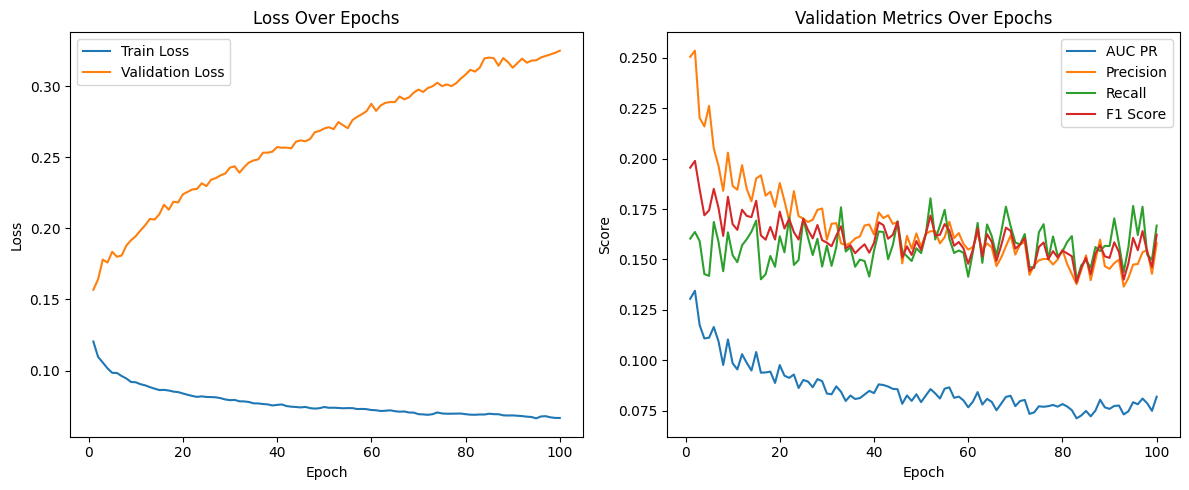

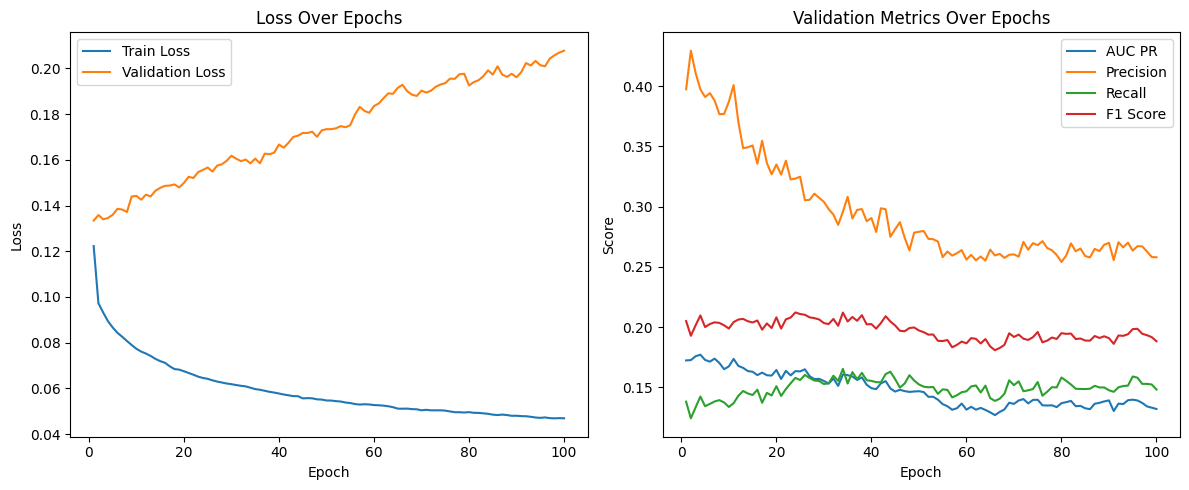

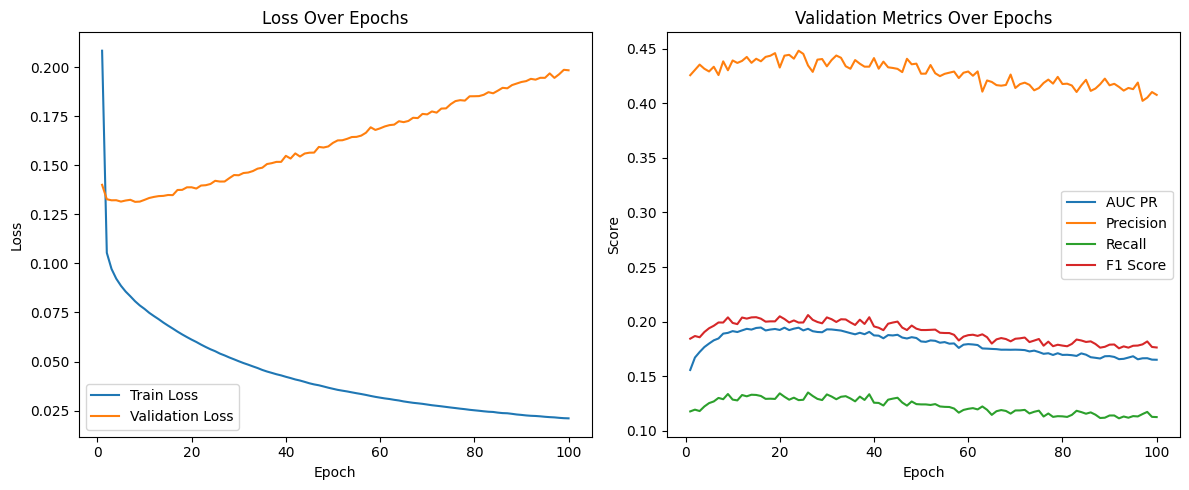

In [21]:
plot_training_history(history_withlr[0])
plot_training_history(history_withlr[1])
plot_training_history(history_withlr[2])

In [22]:
lr_list = [0.0001]
n_inputs=64*64*12
n_outputs=64*64*1
for lr in lr_list:
    print(f"learning rate: {lr}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = LSTMClassifier(input_size=n_inputs, hidden_size=512, num_layers=1,num_classes=n_outputs).to(device)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_trained, history, final_metrics = train_model_test(model, train_loader, test_loader, lr=lr, pos_weight=3, num_epochs=100, device=device)
    #model_withlr.append(model_trained)
    history_withlr.append(history)
    final_metrics_withlr.append(final_metrics)

learning rate: 0.0001


[Epoch 1/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.53it/s]


New best model with AUC PR: 0.1581
Epoch [1/100] Train Loss: 0.2097 Test Loss: 0.1307 AUC PR: 0.1581 Precision: 0.4136 Recall: 0.1293 F1: 0.1970


[Epoch 2/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.97it/s]


New best model with AUC PR: 0.1773
Epoch [2/100] Train Loss: 0.1053 Test Loss: 0.1206 AUC PR: 0.1773 Precision: 0.4201 Recall: 0.1281 F1: 0.1964


[Epoch 3/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.47it/s]


New best model with AUC PR: 0.1856
Epoch [3/100] Train Loss: 0.0973 Test Loss: 0.1185 AUC PR: 0.1856 Precision: 0.4217 Recall: 0.1343 F1: 0.2037


[Epoch 4/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.50it/s]


New best model with AUC PR: 0.1937
Epoch [4/100] Train Loss: 0.0922 Test Loss: 0.1171 AUC PR: 0.1937 Precision: 0.4332 Recall: 0.1361 F1: 0.2071


[Epoch 5/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.57it/s]


New best model with AUC PR: 0.1993
Epoch [5/100] Train Loss: 0.0885 Test Loss: 0.1169 AUC PR: 0.1993 Precision: 0.4299 Recall: 0.1451 F1: 0.2170


[Epoch 6/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.20it/s]


New best model with AUC PR: 0.2013
Epoch [6/100] Train Loss: 0.0857 Test Loss: 0.1168 AUC PR: 0.2013 Precision: 0.4314 Recall: 0.1455 F1: 0.2177


[Epoch 7/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.36it/s]


New best model with AUC PR: 0.2070
Epoch [7/100] Train Loss: 0.0831 Test Loss: 0.1159 AUC PR: 0.2070 Precision: 0.4373 Recall: 0.1497 F1: 0.2230


[Epoch 8/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 49.43it/s]


New best model with AUC PR: 0.2073
Epoch [8/100] Train Loss: 0.0808 Test Loss: 0.1157 AUC PR: 0.2073 Precision: 0.4325 Recall: 0.1525 F1: 0.2255


[Epoch 9/100] Test: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.03it/s]


New best model with AUC PR: 0.2095
Epoch [9/100] Train Loss: 0.0786 Test Loss: 0.1164 AUC PR: 0.2095 Precision: 0.4379 Recall: 0.1496 F1: 0.2231


[Epoch 10/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.13it/s]


New best model with AUC PR: 0.2118
Epoch [10/100] Train Loss: 0.0767 Test Loss: 0.1162 AUC PR: 0.2118 Precision: 0.4389 Recall: 0.1541 F1: 0.2281


[Epoch 11/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.29it/s]


New best model with AUC PR: 0.2130
Epoch [11/100] Train Loss: 0.0748 Test Loss: 0.1176 AUC PR: 0.2130 Precision: 0.4452 Recall: 0.1537 F1: 0.2285


[Epoch 12/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.60it/s]


New best model with AUC PR: 0.2133
Epoch [12/100] Train Loss: 0.0731 Test Loss: 0.1178 AUC PR: 0.2133 Precision: 0.4484 Recall: 0.1538 F1: 0.2290


[Epoch 13/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 47.83it/s]


New best model with AUC PR: 0.2165
Epoch [13/100] Train Loss: 0.0713 Test Loss: 0.1160 AUC PR: 0.2165 Precision: 0.4448 Recall: 0.1563 F1: 0.2313


[Epoch 14/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.46it/s]


Epoch [14/100] Train Loss: 0.0696 Test Loss: 0.1182 AUC PR: 0.2136 Precision: 0.4482 Recall: 0.1521 F1: 0.2271


[Epoch 15/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 44.14it/s]


Epoch [15/100] Train Loss: 0.0682 Test Loss: 0.1177 AUC PR: 0.2149 Precision: 0.4423 Recall: 0.1520 F1: 0.2262


[Epoch 16/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.19it/s]


Epoch [16/100] Train Loss: 0.0666 Test Loss: 0.1176 AUC PR: 0.2140 Precision: 0.4466 Recall: 0.1489 F1: 0.2234


[Epoch 17/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.96it/s]


Epoch [17/100] Train Loss: 0.0651 Test Loss: 0.1176 AUC PR: 0.2158 Precision: 0.4554 Recall: 0.1470 F1: 0.2222


[Epoch 18/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.42it/s]


New best model with AUC PR: 0.2182
Epoch [18/100] Train Loss: 0.0637 Test Loss: 0.1170 AUC PR: 0.2182 Precision: 0.4520 Recall: 0.1510 F1: 0.2263


[Epoch 19/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 55.96it/s]


Epoch [19/100] Train Loss: 0.0624 Test Loss: 0.1180 AUC PR: 0.2181 Precision: 0.4561 Recall: 0.1473 F1: 0.2227


[Epoch 20/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.00it/s]


Epoch [20/100] Train Loss: 0.0611 Test Loss: 0.1186 AUC PR: 0.2163 Precision: 0.4561 Recall: 0.1474 F1: 0.2228


[Epoch 21/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.36it/s]


New best model with AUC PR: 0.2191
Epoch [21/100] Train Loss: 0.0598 Test Loss: 0.1178 AUC PR: 0.2191 Precision: 0.4427 Recall: 0.1558 F1: 0.2305


[Epoch 22/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.23it/s]


New best model with AUC PR: 0.2192
Epoch [22/100] Train Loss: 0.0585 Test Loss: 0.1198 AUC PR: 0.2192 Precision: 0.4622 Recall: 0.1462 F1: 0.2222


[Epoch 23/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.29it/s]


Epoch [23/100] Train Loss: 0.0571 Test Loss: 0.1207 AUC PR: 0.2164 Precision: 0.4597 Recall: 0.1484 F1: 0.2244


[Epoch 24/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.28it/s]


Epoch [24/100] Train Loss: 0.0559 Test Loss: 0.1212 AUC PR: 0.2162 Precision: 0.4543 Recall: 0.1459 F1: 0.2209


[Epoch 25/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.83it/s]


Epoch [25/100] Train Loss: 0.0549 Test Loss: 0.1211 AUC PR: 0.2168 Precision: 0.4533 Recall: 0.1510 F1: 0.2265


[Epoch 26/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.71it/s]


Epoch [26/100] Train Loss: 0.0538 Test Loss: 0.1213 AUC PR: 0.2158 Precision: 0.4534 Recall: 0.1511 F1: 0.2267


[Epoch 27/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.26it/s]


Epoch [27/100] Train Loss: 0.0528 Test Loss: 0.1232 AUC PR: 0.2155 Precision: 0.4598 Recall: 0.1487 F1: 0.2247


[Epoch 28/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.24it/s]


Epoch [28/100] Train Loss: 0.0518 Test Loss: 0.1226 AUC PR: 0.2163 Precision: 0.4576 Recall: 0.1489 F1: 0.2247


[Epoch 29/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.28it/s]


Epoch [29/100] Train Loss: 0.0508 Test Loss: 0.1236 AUC PR: 0.2165 Precision: 0.4587 Recall: 0.1472 F1: 0.2229


[Epoch 30/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.51it/s]


Epoch [30/100] Train Loss: 0.0499 Test Loss: 0.1237 AUC PR: 0.2171 Precision: 0.4621 Recall: 0.1467 F1: 0.2227


[Epoch 31/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.12it/s]


Epoch [31/100] Train Loss: 0.0490 Test Loss: 0.1241 AUC PR: 0.2147 Precision: 0.4492 Recall: 0.1468 F1: 0.2213


[Epoch 32/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 46.13it/s]


Epoch [32/100] Train Loss: 0.0482 Test Loss: 0.1253 AUC PR: 0.2144 Precision: 0.4566 Recall: 0.1434 F1: 0.2183


[Epoch 33/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.63it/s]


Epoch [33/100] Train Loss: 0.0473 Test Loss: 0.1259 AUC PR: 0.2126 Precision: 0.4440 Recall: 0.1508 F1: 0.2251


[Epoch 34/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 48.73it/s]


Epoch [34/100] Train Loss: 0.0465 Test Loss: 0.1267 AUC PR: 0.2154 Precision: 0.4621 Recall: 0.1442 F1: 0.2198


[Epoch 35/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 56.41it/s]


Epoch [35/100] Train Loss: 0.0457 Test Loss: 0.1268 AUC PR: 0.2151 Precision: 0.4551 Recall: 0.1456 F1: 0.2207


[Epoch 36/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.81it/s]


Epoch [36/100] Train Loss: 0.0448 Test Loss: 0.1275 AUC PR: 0.2144 Precision: 0.4636 Recall: 0.1409 F1: 0.2161


[Epoch 37/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.25it/s]


Epoch [37/100] Train Loss: 0.0442 Test Loss: 0.1287 AUC PR: 0.2125 Precision: 0.4618 Recall: 0.1403 F1: 0.2152


[Epoch 38/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.07it/s]


Epoch [38/100] Train Loss: 0.0433 Test Loss: 0.1300 AUC PR: 0.2114 Precision: 0.4582 Recall: 0.1406 F1: 0.2152


[Epoch 39/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.22it/s]


Epoch [39/100] Train Loss: 0.0426 Test Loss: 0.1294 AUC PR: 0.2125 Precision: 0.4490 Recall: 0.1515 F1: 0.2266


[Epoch 40/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 44.57it/s]


Epoch [40/100] Train Loss: 0.0420 Test Loss: 0.1304 AUC PR: 0.2106 Precision: 0.4601 Recall: 0.1417 F1: 0.2166


[Epoch 41/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.15it/s]


Epoch [41/100] Train Loss: 0.0413 Test Loss: 0.1303 AUC PR: 0.2146 Precision: 0.4515 Recall: 0.1501 F1: 0.2253


[Epoch 42/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.54it/s]


Epoch [42/100] Train Loss: 0.0405 Test Loss: 0.1315 AUC PR: 0.2121 Precision: 0.4581 Recall: 0.1425 F1: 0.2174


[Epoch 43/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.46it/s]


Epoch [43/100] Train Loss: 0.0400 Test Loss: 0.1317 AUC PR: 0.2125 Precision: 0.4529 Recall: 0.1467 F1: 0.2216


[Epoch 44/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 55.17it/s]


Epoch [44/100] Train Loss: 0.0394 Test Loss: 0.1326 AUC PR: 0.2109 Precision: 0.4504 Recall: 0.1470 F1: 0.2217


[Epoch 45/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 56.23it/s]


Epoch [45/100] Train Loss: 0.0389 Test Loss: 0.1331 AUC PR: 0.2115 Precision: 0.4542 Recall: 0.1488 F1: 0.2241


[Epoch 46/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.89it/s]


Epoch [46/100] Train Loss: 0.0382 Test Loss: 0.1341 AUC PR: 0.2102 Precision: 0.4594 Recall: 0.1397 F1: 0.2142


[Epoch 47/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.54it/s]


Epoch [47/100] Train Loss: 0.0375 Test Loss: 0.1345 AUC PR: 0.2097 Precision: 0.4590 Recall: 0.1403 F1: 0.2149


[Epoch 48/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.40it/s]


Epoch [48/100] Train Loss: 0.0371 Test Loss: 0.1345 AUC PR: 0.2096 Precision: 0.4577 Recall: 0.1405 F1: 0.2150


[Epoch 49/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.01it/s]


Epoch [49/100] Train Loss: 0.0365 Test Loss: 0.1353 AUC PR: 0.2094 Precision: 0.4610 Recall: 0.1371 F1: 0.2114


[Epoch 50/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.17it/s]


Epoch [50/100] Train Loss: 0.0359 Test Loss: 0.1372 AUC PR: 0.2060 Precision: 0.4514 Recall: 0.1395 F1: 0.2131


[Epoch 51/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.83it/s]


Epoch [51/100] Train Loss: 0.0354 Test Loss: 0.1360 AUC PR: 0.2106 Precision: 0.4578 Recall: 0.1502 F1: 0.2262


[Epoch 52/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.78it/s]


Epoch [52/100] Train Loss: 0.0350 Test Loss: 0.1369 AUC PR: 0.2104 Precision: 0.4585 Recall: 0.1434 F1: 0.2184


[Epoch 53/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 46.71it/s]


Epoch [53/100] Train Loss: 0.0345 Test Loss: 0.1384 AUC PR: 0.2082 Precision: 0.4604 Recall: 0.1399 F1: 0.2145


[Epoch 54/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 57.43it/s]


Epoch [54/100] Train Loss: 0.0341 Test Loss: 0.1393 AUC PR: 0.2043 Precision: 0.4517 Recall: 0.1383 F1: 0.2118


[Epoch 55/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.23it/s]


Epoch [55/100] Train Loss: 0.0337 Test Loss: 0.1405 AUC PR: 0.2066 Precision: 0.4563 Recall: 0.1408 F1: 0.2153


[Epoch 56/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.78it/s]


Epoch [56/100] Train Loss: 0.0331 Test Loss: 0.1406 AUC PR: 0.2048 Precision: 0.4571 Recall: 0.1383 F1: 0.2123


[Epoch 57/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.95it/s]


Epoch [57/100] Train Loss: 0.0326 Test Loss: 0.1425 AUC PR: 0.2050 Precision: 0.4640 Recall: 0.1372 F1: 0.2118


[Epoch 58/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.96it/s]


Epoch [58/100] Train Loss: 0.0324 Test Loss: 0.1421 AUC PR: 0.2100 Precision: 0.4652 Recall: 0.1435 F1: 0.2193


[Epoch 59/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.02it/s]


Epoch [59/100] Train Loss: 0.0318 Test Loss: 0.1432 AUC PR: 0.2040 Precision: 0.4599 Recall: 0.1359 F1: 0.2098


[Epoch 60/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.32it/s]


Epoch [60/100] Train Loss: 0.0314 Test Loss: 0.1433 AUC PR: 0.2054 Precision: 0.4560 Recall: 0.1387 F1: 0.2127


[Epoch 61/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.56it/s]


Epoch [61/100] Train Loss: 0.0310 Test Loss: 0.1433 AUC PR: 0.2035 Precision: 0.4567 Recall: 0.1389 F1: 0.2130


[Epoch 62/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 48.03it/s]


Epoch [62/100] Train Loss: 0.0306 Test Loss: 0.1429 AUC PR: 0.2061 Precision: 0.4537 Recall: 0.1402 F1: 0.2142


[Epoch 63/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.37it/s]


Epoch [63/100] Train Loss: 0.0302 Test Loss: 0.1439 AUC PR: 0.2041 Precision: 0.4583 Recall: 0.1365 F1: 0.2104


[Epoch 64/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.62it/s]


Epoch [64/100] Train Loss: 0.0299 Test Loss: 0.1447 AUC PR: 0.2040 Precision: 0.4543 Recall: 0.1397 F1: 0.2136


[Epoch 65/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.84it/s]


Epoch [65/100] Train Loss: 0.0296 Test Loss: 0.1461 AUC PR: 0.2020 Precision: 0.4560 Recall: 0.1381 F1: 0.2119


[Epoch 66/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.05it/s]


Epoch [66/100] Train Loss: 0.0292 Test Loss: 0.1467 AUC PR: 0.2031 Precision: 0.4522 Recall: 0.1425 F1: 0.2167


[Epoch 67/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.49it/s]


Epoch [67/100] Train Loss: 0.0289 Test Loss: 0.1473 AUC PR: 0.2037 Precision: 0.4553 Recall: 0.1427 F1: 0.2173


[Epoch 68/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.10it/s]


Epoch [68/100] Train Loss: 0.0286 Test Loss: 0.1480 AUC PR: 0.2005 Precision: 0.4504 Recall: 0.1356 F1: 0.2085


[Epoch 69/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.94it/s]


Epoch [69/100] Train Loss: 0.0283 Test Loss: 0.1492 AUC PR: 0.1994 Precision: 0.4478 Recall: 0.1420 F1: 0.2157


[Epoch 70/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 48.38it/s]


Epoch [70/100] Train Loss: 0.0279 Test Loss: 0.1493 AUC PR: 0.2006 Precision: 0.4509 Recall: 0.1368 F1: 0.2099


[Epoch 71/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.84it/s]


Epoch [71/100] Train Loss: 0.0275 Test Loss: 0.1496 AUC PR: 0.1996 Precision: 0.4464 Recall: 0.1403 F1: 0.2135


[Epoch 72/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.66it/s]


Epoch [72/100] Train Loss: 0.0273 Test Loss: 0.1523 AUC PR: 0.1966 Precision: 0.4433 Recall: 0.1359 F1: 0.2080


[Epoch 73/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.51it/s]


Epoch [73/100] Train Loss: 0.0269 Test Loss: 0.1514 AUC PR: 0.1971 Precision: 0.4459 Recall: 0.1358 F1: 0.2082


[Epoch 74/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.05it/s]


Epoch [74/100] Train Loss: 0.0265 Test Loss: 0.1522 AUC PR: 0.2003 Precision: 0.4621 Recall: 0.1351 F1: 0.2090


[Epoch 75/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 43.83it/s]


Epoch [75/100] Train Loss: 0.0263 Test Loss: 0.1512 AUC PR: 0.2009 Precision: 0.4553 Recall: 0.1357 F1: 0.2091


[Epoch 76/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.70it/s]


Epoch [76/100] Train Loss: 0.0261 Test Loss: 0.1541 AUC PR: 0.1974 Precision: 0.4578 Recall: 0.1330 F1: 0.2061


[Epoch 77/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.86it/s]


Epoch [77/100] Train Loss: 0.0258 Test Loss: 0.1536 AUC PR: 0.1950 Precision: 0.4513 Recall: 0.1363 F1: 0.2094


[Epoch 78/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.39it/s]


Epoch [78/100] Train Loss: 0.0256 Test Loss: 0.1542 AUC PR: 0.1990 Precision: 0.4507 Recall: 0.1423 F1: 0.2163


[Epoch 79/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 28.15it/s]


Epoch [79/100] Train Loss: 0.0253 Test Loss: 0.1559 AUC PR: 0.1967 Precision: 0.4525 Recall: 0.1359 F1: 0.2090


[Epoch 80/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 52.05it/s]


Epoch [80/100] Train Loss: 0.0251 Test Loss: 0.1570 AUC PR: 0.1957 Precision: 0.4556 Recall: 0.1312 F1: 0.2038


[Epoch 81/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.86it/s]


Epoch [81/100] Train Loss: 0.0248 Test Loss: 0.1567 AUC PR: 0.1971 Precision: 0.4486 Recall: 0.1366 F1: 0.2094


[Epoch 82/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.63it/s]


Epoch [82/100] Train Loss: 0.0246 Test Loss: 0.1554 AUC PR: 0.1965 Precision: 0.4496 Recall: 0.1338 F1: 0.2062


[Epoch 83/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 44.51it/s]


Epoch [83/100] Train Loss: 0.0243 Test Loss: 0.1577 AUC PR: 0.1943 Precision: 0.4478 Recall: 0.1352 F1: 0.2077


[Epoch 84/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.01it/s]


Epoch [84/100] Train Loss: 0.0240 Test Loss: 0.1588 AUC PR: 0.1951 Precision: 0.4525 Recall: 0.1329 F1: 0.2054


[Epoch 85/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.55it/s]


Epoch [85/100] Train Loss: 0.0238 Test Loss: 0.1590 AUC PR: 0.1921 Precision: 0.4404 Recall: 0.1326 F1: 0.2039


[Epoch 86/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 47.96it/s]


Epoch [86/100] Train Loss: 0.0236 Test Loss: 0.1592 AUC PR: 0.1960 Precision: 0.4520 Recall: 0.1331 F1: 0.2056


[Epoch 87/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.34it/s]


Epoch [87/100] Train Loss: 0.0235 Test Loss: 0.1594 AUC PR: 0.1957 Precision: 0.4430 Recall: 0.1373 F1: 0.2096


[Epoch 88/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 54.77it/s]


Epoch [88/100] Train Loss: 0.0232 Test Loss: 0.1604 AUC PR: 0.1949 Precision: 0.4490 Recall: 0.1366 F1: 0.2095


[Epoch 89/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 53.57it/s]


Epoch [89/100] Train Loss: 0.0229 Test Loss: 0.1612 AUC PR: 0.1950 Precision: 0.4469 Recall: 0.1388 F1: 0.2118


[Epoch 90/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 51.74it/s]


Epoch [90/100] Train Loss: 0.0228 Test Loss: 0.1616 AUC PR: 0.1919 Precision: 0.4425 Recall: 0.1330 F1: 0.2045


[Epoch 91/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.91it/s]


Epoch [91/100] Train Loss: 0.0225 Test Loss: 0.1636 AUC PR: 0.1931 Precision: 0.4514 Recall: 0.1346 F1: 0.2074


[Epoch 92/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 44.10it/s]


Epoch [92/100] Train Loss: 0.0223 Test Loss: 0.1657 AUC PR: 0.1920 Precision: 0.4506 Recall: 0.1313 F1: 0.2033


[Epoch 93/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.95it/s]


Epoch [93/100] Train Loss: 0.0221 Test Loss: 0.1654 AUC PR: 0.1895 Precision: 0.4516 Recall: 0.1256 F1: 0.1965


[Epoch 94/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 42.43it/s]


Epoch [94/100] Train Loss: 0.0219 Test Loss: 0.1656 AUC PR: 0.1897 Precision: 0.4408 Recall: 0.1296 F1: 0.2003


[Epoch 95/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.31it/s]


Epoch [95/100] Train Loss: 0.0218 Test Loss: 0.1662 AUC PR: 0.1901 Precision: 0.4431 Recall: 0.1318 F1: 0.2032


[Epoch 96/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.81it/s]


Epoch [96/100] Train Loss: 0.0215 Test Loss: 0.1669 AUC PR: 0.1896 Precision: 0.4514 Recall: 0.1306 F1: 0.2026


[Epoch 97/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 50.29it/s]


Epoch [97/100] Train Loss: 0.0213 Test Loss: 0.1673 AUC PR: 0.1893 Precision: 0.4442 Recall: 0.1308 F1: 0.2021


[Epoch 98/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 45.53it/s]


Epoch [98/100] Train Loss: 0.0211 Test Loss: 0.1675 AUC PR: 0.1932 Precision: 0.4533 Recall: 0.1339 F1: 0.2068


[Epoch 99/100] Test: 100%|█████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 41.63it/s]


Epoch [99/100] Train Loss: 0.0209 Test Loss: 0.1687 AUC PR: 0.1891 Precision: 0.4421 Recall: 0.1311 F1: 0.2022


[Epoch 100/100] Test: 100%|████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 47.68it/s]


Epoch [100/100] Train Loss: 0.0208 Test Loss: 0.1693 AUC PR: 0.1894 Precision: 0.4433 Recall: 0.1341 F1: 0.2059

Final Model Performance:
AUC PR: 0.1894
Precision: 0.4433
Recall: 0.1341
F1 Score: 0.2059
